In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1','fe':['b10','b25','b50','b75'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b10_b25_b50_b75_t1_mask_t1_normalized_k5_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4629816, 460)
(4629816, 8)
validation
(621056, 460)
(621056, 8)
test
(624904, 460)
(624904, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 460)]             0         


 dense (Dense)               (None, 1024)              472064    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1162120 (4.43 MB)


Trainable params: 1162120 (4.43 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/463 [..............................] - ETA: 13:12 - loss: 2.4635 - STD: 0.0988 - MAE: 0.2208

  4/463 [..............................] - ETA: 9s - loss: 2.2188 - STD: 0.0467 - MAE: 0.2195   

  7/463 [..............................] - ETA: 9s - loss: 2.1611 - STD: 0.0575 - MAE: 0.2172

 10/463 [..............................] - ETA: 8s - loss: 2.1421 - STD: 0.0607 - MAE: 0.2164

 13/463 [..............................] - ETA: 8s - loss: 2.1273 - STD: 0.0557 - MAE: 0.2165

 16/463 [>.............................] - ETA: 8s - loss: 2.1153 - STD: 0.0503 - MAE: 0.2167

 19/463 [>.............................] - ETA: 8s - loss: 2.1055 - STD: 0.0469 - MAE: 0.2167

 22/463 [>.............................] - ETA: 8s - loss: 2.0997 - STD: 0.0455 - MAE: 0.2167

 25/463 [>.............................] - ETA: 8s - loss: 2.0948 - STD: 0.0442 - MAE: 0.2167

 28/463 [>.............................] - ETA: 8s - loss: 2.0904 - STD: 0.0426 - MAE: 0.2168

 31/463 [=>............................] - ETA: 8s - loss: 2.0868 - STD: 0.0413 - MAE: 0.2168

 34/463 [=>............................] - ETA: 8s - loss: 2.0837 - STD: 0.0407 - MAE: 0.2168

 37/463 [=>............................] - ETA: 8s - loss: 2.0816 - STD: 0.0406 - MAE: 0.2167

 40/463 [=>............................] - ETA: 8s - loss: 2.0794 - STD: 0.0402 - MAE: 0.2167

 43/463 [=>............................] - ETA: 8s - loss: 2.0776 - STD: 0.0396 - MAE: 0.2167

 46/463 [=>............................] - ETA: 8s - loss: 2.0758 - STD: 0.0390 - MAE: 0.2167

 49/463 [==>...........................] - ETA: 8s - loss: 2.0744 - STD: 0.0384 - MAE: 0.2167

 52/463 [==>...........................] - ETA: 8s - loss: 2.0733 - STD: 0.0380 - MAE: 0.2167

 55/463 [==>...........................] - ETA: 7s - loss: 2.0721 - STD: 0.0376 - MAE: 0.2167

 58/463 [==>...........................] - ETA: 7s - loss: 2.0710 - STD: 0.0373 - MAE: 0.2167

 61/463 [==>...........................] - ETA: 7s - loss: 2.0700 - STD: 0.0371 - MAE: 0.2167

 64/463 [===>..........................] - ETA: 7s - loss: 2.0691 - STD: 0.0370 - MAE: 0.2167

 67/463 [===>..........................] - ETA: 7s - loss: 2.0684 - STD: 0.0368 - MAE: 0.2167

 70/463 [===>..........................] - ETA: 7s - loss: 2.0676 - STD: 0.0365 - MAE: 0.2167

 73/463 [===>..........................] - ETA: 7s - loss: 2.0668 - STD: 0.0362 - MAE: 0.2167

 76/463 [===>..........................] - ETA: 7s - loss: 2.0662 - STD: 0.0362 - MAE: 0.2167

 79/463 [====>.........................] - ETA: 7s - loss: 2.0657 - STD: 0.0360 - MAE: 0.2167

 82/463 [====>.........................] - ETA: 7s - loss: 2.0650 - STD: 0.0358 - MAE: 0.2167

 85/463 [====>.........................] - ETA: 7s - loss: 2.0645 - STD: 0.0356 - MAE: 0.2167

 88/463 [====>.........................] - ETA: 7s - loss: 2.0640 - STD: 0.0356 - MAE: 0.2167

 91/463 [====>.........................] - ETA: 7s - loss: 2.0634 - STD: 0.0355 - MAE: 0.2167

 94/463 [=====>........................] - ETA: 7s - loss: 2.0628 - STD: 0.0353 - MAE: 0.2167

 97/463 [=====>........................] - ETA: 7s - loss: 2.0622 - STD: 0.0352 - MAE: 0.2167

100/463 [=====>........................] - ETA: 7s - loss: 2.0616 - STD: 0.0351 - MAE: 0.2167

103/463 [=====>........................] - ETA: 7s - loss: 2.0608 - STD: 0.0350 - MAE: 0.2167

106/463 [=====>........................] - ETA: 6s - loss: 2.0598 - STD: 0.0348 - MAE: 0.2167

109/463 [======>.......................] - ETA: 6s - loss: 2.0587 - STD: 0.0349 - MAE: 0.2166

112/463 [======>.......................] - ETA: 6s - loss: 2.0572 - STD: 0.0349 - MAE: 0.2166

115/463 [======>.......................] - ETA: 6s - loss: 2.0555 - STD: 0.0350 - MAE: 0.2165

118/463 [======>.......................] - ETA: 6s - loss: 2.0535 - STD: 0.0352 - MAE: 0.2165

121/463 [======>.......................] - ETA: 6s - loss: 2.0514 - STD: 0.0354 - MAE: 0.2164

124/463 [=======>......................] - ETA: 6s - loss: 2.0491 - STD: 0.0359 - MAE: 0.2163

127/463 [=======>......................] - ETA: 6s - loss: 2.0469 - STD: 0.0364 - MAE: 0.2162

130/463 [=======>......................] - ETA: 6s - loss: 2.0447 - STD: 0.0370 - MAE: 0.2161

133/463 [=======>......................] - ETA: 6s - loss: 2.0427 - STD: 0.0376 - MAE: 0.2160

136/463 [=======>......................] - ETA: 6s - loss: 2.0404 - STD: 0.0382 - MAE: 0.2159

139/463 [========>.....................] - ETA: 6s - loss: 2.0382 - STD: 0.0387 - MAE: 0.2158

142/463 [========>.....................] - ETA: 6s - loss: 2.0362 - STD: 0.0392 - MAE: 0.2157

145/463 [========>.....................] - ETA: 6s - loss: 2.0342 - STD: 0.0397 - MAE: 0.2156

148/463 [========>.....................] - ETA: 6s - loss: 2.0322 - STD: 0.0401 - MAE: 0.2155

151/463 [========>.....................] - ETA: 6s - loss: 2.0303 - STD: 0.0406 - MAE: 0.2154

154/463 [========>.....................] - ETA: 5s - loss: 2.0285 - STD: 0.0410 - MAE: 0.2153

157/463 [=========>....................] - ETA: 5s - loss: 2.0267 - STD: 0.0414 - MAE: 0.2152

160/463 [=========>....................] - ETA: 5s - loss: 2.0249 - STD: 0.0419 - MAE: 0.2151

163/463 [=========>....................] - ETA: 5s - loss: 2.0232 - STD: 0.0423 - MAE: 0.2150

166/463 [=========>....................] - ETA: 5s - loss: 2.0214 - STD: 0.0427 - MAE: 0.2149

169/463 [=========>....................] - ETA: 5s - loss: 2.0198 - STD: 0.0430 - MAE: 0.2149

172/463 [==========>...................] - ETA: 5s - loss: 2.0181 - STD: 0.0434 - MAE: 0.2148

175/463 [==========>...................] - ETA: 5s - loss: 2.0166 - STD: 0.0438 - MAE: 0.2147

178/463 [==========>...................] - ETA: 5s - loss: 2.0150 - STD: 0.0441 - MAE: 0.2146

181/463 [==========>...................] - ETA: 5s - loss: 2.0134 - STD: 0.0445 - MAE: 0.2145

184/463 [==========>...................] - ETA: 5s - loss: 2.0118 - STD: 0.0448 - MAE: 0.2145

187/463 [===========>..................] - ETA: 5s - loss: 2.0103 - STD: 0.0451 - MAE: 0.2144

190/463 [===========>..................] - ETA: 5s - loss: 2.0089 - STD: 0.0455 - MAE: 0.2143

193/463 [===========>..................] - ETA: 5s - loss: 2.0075 - STD: 0.0457 - MAE: 0.2143

196/463 [===========>..................] - ETA: 5s - loss: 2.0060 - STD: 0.0461 - MAE: 0.2142

199/463 [===========>..................] - ETA: 5s - loss: 2.0046 - STD: 0.0464 - MAE: 0.2141

202/463 [============>.................] - ETA: 5s - loss: 2.0031 - STD: 0.0467 - MAE: 0.2140

205/463 [============>.................] - ETA: 4s - loss: 2.0016 - STD: 0.0470 - MAE: 0.2140

208/463 [============>.................] - ETA: 4s - loss: 2.0001 - STD: 0.0473 - MAE: 0.2139

211/463 [============>.................] - ETA: 4s - loss: 1.9987 - STD: 0.0477 - MAE: 0.2138

214/463 [============>.................] - ETA: 4s - loss: 1.9972 - STD: 0.0480 - MAE: 0.2137

217/463 [=============>................] - ETA: 4s - loss: 1.9958 - STD: 0.0483 - MAE: 0.2136

220/463 [=============>................] - ETA: 4s - loss: 1.9944 - STD: 0.0486 - MAE: 0.2136

223/463 [=============>................] - ETA: 4s - loss: 1.9931 - STD: 0.0489 - MAE: 0.2135

226/463 [=============>................] - ETA: 4s - loss: 1.9916 - STD: 0.0493 - MAE: 0.2134

229/463 [=============>................] - ETA: 4s - loss: 1.9902 - STD: 0.0496 - MAE: 0.2133

232/463 [==============>...............] - ETA: 4s - loss: 1.9888 - STD: 0.0499 - MAE: 0.2132

235/463 [==============>...............] - ETA: 4s - loss: 1.9874 - STD: 0.0503 - MAE: 0.2132

238/463 [==============>...............] - ETA: 4s - loss: 1.9860 - STD: 0.0506 - MAE: 0.2131

241/463 [==============>...............] - ETA: 4s - loss: 1.9846 - STD: 0.0509 - MAE: 0.2130

244/463 [==============>...............] - ETA: 4s - loss: 1.9833 - STD: 0.0513 - MAE: 0.2129

247/463 [===============>..............] - ETA: 4s - loss: 1.9819 - STD: 0.0516 - MAE: 0.2128

250/463 [===============>..............] - ETA: 4s - loss: 1.9804 - STD: 0.0519 - MAE: 0.2128

253/463 [===============>..............] - ETA: 4s - loss: 1.9791 - STD: 0.0522 - MAE: 0.2127

256/463 [===============>..............] - ETA: 3s - loss: 1.9777 - STD: 0.0525 - MAE: 0.2126

259/463 [===============>..............] - ETA: 3s - loss: 1.9763 - STD: 0.0529 - MAE: 0.2125

262/463 [===============>..............] - ETA: 3s - loss: 1.9749 - STD: 0.0531 - MAE: 0.2124

265/463 [================>.............] - ETA: 3s - loss: 1.9734 - STD: 0.0535 - MAE: 0.2123

268/463 [================>.............] - ETA: 3s - loss: 1.9718 - STD: 0.0538 - MAE: 0.2123

271/463 [================>.............] - ETA: 3s - loss: 1.9703 - STD: 0.0541 - MAE: 0.2122

274/463 [================>.............] - ETA: 3s - loss: 1.9686 - STD: 0.0544 - MAE: 0.2121

277/463 [================>.............] - ETA: 3s - loss: 1.9669 - STD: 0.0547 - MAE: 0.2120

280/463 [=================>............] - ETA: 3s - loss: 1.9653 - STD: 0.0551 - MAE: 0.2119

283/463 [=================>............] - ETA: 3s - loss: 1.9635 - STD: 0.0554 - MAE: 0.2118

286/463 [=================>............] - ETA: 3s - loss: 1.9617 - STD: 0.0558 - MAE: 0.2117

289/463 [=================>............] - ETA: 3s - loss: 1.9603 - STD: 0.0562 - MAE: 0.2115

292/463 [=================>............] - ETA: 3s - loss: 1.9587 - STD: 0.0566 - MAE: 0.2114

295/463 [==================>...........] - ETA: 3s - loss: 1.9570 - STD: 0.0569 - MAE: 0.2113

298/463 [==================>...........] - ETA: 3s - loss: 1.9555 - STD: 0.0573 - MAE: 0.2112

301/463 [==================>...........] - ETA: 3s - loss: 1.9538 - STD: 0.0577 - MAE: 0.2111

304/463 [==================>...........] - ETA: 3s - loss: 1.9521 - STD: 0.0580 - MAE: 0.2110

307/463 [==================>...........] - ETA: 3s - loss: 1.9504 - STD: 0.0584 - MAE: 0.2109

310/463 [===================>..........] - ETA: 2s - loss: 1.9488 - STD: 0.0587 - MAE: 0.2108

313/463 [===================>..........] - ETA: 2s - loss: 1.9472 - STD: 0.0591 - MAE: 0.2107

316/463 [===================>..........] - ETA: 2s - loss: 1.9455 - STD: 0.0594 - MAE: 0.2106

319/463 [===================>..........] - ETA: 2s - loss: 1.9439 - STD: 0.0598 - MAE: 0.2105

322/463 [===================>..........] - ETA: 2s - loss: 1.9422 - STD: 0.0601 - MAE: 0.2104

325/463 [====================>.........] - ETA: 2s - loss: 1.9406 - STD: 0.0605 - MAE: 0.2103

328/463 [====================>.........] - ETA: 2s - loss: 1.9390 - STD: 0.0608 - MAE: 0.2102

331/463 [====================>.........] - ETA: 2s - loss: 1.9374 - STD: 0.0612 - MAE: 0.2101

334/463 [====================>.........] - ETA: 2s - loss: 1.9358 - STD: 0.0615 - MAE: 0.2100

337/463 [====================>.........] - ETA: 2s - loss: 1.9342 - STD: 0.0618 - MAE: 0.2099

338/463 [====================>.........] - ETA: 2s - loss: 1.9337 - STD: 0.0619 - MAE: 0.2098

341/463 [=====================>........] - ETA: 2s - loss: 1.9321 - STD: 0.0623 - MAE: 0.2097

344/463 [=====================>........] - ETA: 2s - loss: 1.9306 - STD: 0.0626 - MAE: 0.2096

347/463 [=====================>........] - ETA: 2s - loss: 1.9291 - STD: 0.0629 - MAE: 0.2095

350/463 [=====================>........] - ETA: 2s - loss: 1.9276 - STD: 0.0633 - MAE: 0.2094

353/463 [=====================>........] - ETA: 2s - loss: 1.9260 - STD: 0.0636 - MAE: 0.2093

356/463 [======================>.......] - ETA: 2s - loss: 1.9245 - STD: 0.0639 - MAE: 0.2092

359/463 [======================>.......] - ETA: 2s - loss: 1.9230 - STD: 0.0642 - MAE: 0.2091

362/463 [======================>.......] - ETA: 2s - loss: 1.9215 - STD: 0.0645 - MAE: 0.2090

365/463 [======================>.......] - ETA: 2s - loss: 1.9200 - STD: 0.0648 - MAE: 0.2089

368/463 [======================>.......] - ETA: 2s - loss: 1.9185 - STD: 0.0651 - MAE: 0.2088

371/463 [=======================>......] - ETA: 2s - loss: 1.9170 - STD: 0.0654 - MAE: 0.2087

374/463 [=======================>......] - ETA: 1s - loss: 1.9156 - STD: 0.0657 - MAE: 0.2086

377/463 [=======================>......] - ETA: 1s - loss: 1.9142 - STD: 0.0660 - MAE: 0.2086

380/463 [=======================>......] - ETA: 1s - loss: 1.9127 - STD: 0.0663 - MAE: 0.2085

383/463 [=======================>......] - ETA: 1s - loss: 1.9114 - STD: 0.0666 - MAE: 0.2084

386/463 [========================>.....] - ETA: 1s - loss: 1.9101 - STD: 0.0669 - MAE: 0.2083

389/463 [========================>.....] - ETA: 1s - loss: 1.9087 - STD: 0.0672 - MAE: 0.2082

392/463 [========================>.....] - ETA: 1s - loss: 1.9075 - STD: 0.0675 - MAE: 0.2081

395/463 [========================>.....] - ETA: 1s - loss: 1.9060 - STD: 0.0678 - MAE: 0.2080

398/463 [========================>.....] - ETA: 1s - loss: 1.9047 - STD: 0.0681 - MAE: 0.2079

401/463 [========================>.....] - ETA: 1s - loss: 1.9033 - STD: 0.0683 - MAE: 0.2078

404/463 [=========================>....] - ETA: 1s - loss: 1.9020 - STD: 0.0686 - MAE: 0.2077

407/463 [=========================>....] - ETA: 1s - loss: 1.9007 - STD: 0.0689 - MAE: 0.2076

410/463 [=========================>....] - ETA: 1s - loss: 1.8995 - STD: 0.0692 - MAE: 0.2075

413/463 [=========================>....] - ETA: 1s - loss: 1.8983 - STD: 0.0695 - MAE: 0.2075

416/463 [=========================>....] - ETA: 1s - loss: 1.8970 - STD: 0.0697 - MAE: 0.2074

419/463 [==========================>...] - ETA: 0s - loss: 1.8957 - STD: 0.0700 - MAE: 0.2073

422/463 [==========================>...] - ETA: 0s - loss: 1.8944 - STD: 0.0703 - MAE: 0.2072

425/463 [==========================>...] - ETA: 0s - loss: 1.8931 - STD: 0.0705 - MAE: 0.2071

428/463 [==========================>...] - ETA: 0s - loss: 1.8919 - STD: 0.0708 - MAE: 0.2070

431/463 [==========================>...] - ETA: 0s - loss: 1.8907 - STD: 0.0710 - MAE: 0.2070

434/463 [===========================>..] - ETA: 0s - loss: 1.8895 - STD: 0.0713 - MAE: 0.2069

437/463 [===========================>..] - ETA: 0s - loss: 1.8883 - STD: 0.0715 - MAE: 0.2068

440/463 [===========================>..] - ETA: 0s - loss: 1.8870 - STD: 0.0718 - MAE: 0.2067

443/463 [===========================>..] - ETA: 0s - loss: 1.8858 - STD: 0.0720 - MAE: 0.2066

446/463 [===========================>..] - ETA: 0s - loss: 1.8846 - STD: 0.0723 - MAE: 0.2065

449/463 [============================>.] - ETA: 0s - loss: 1.8834 - STD: 0.0725 - MAE: 0.2065

452/463 [============================>.] - ETA: 0s - loss: 1.8822 - STD: 0.0728 - MAE: 0.2064

455/463 [============================>.] - ETA: 0s - loss: 1.8811 - STD: 0.0730 - MAE: 0.2063

458/463 [============================>.] - ETA: 0s - loss: 1.8800 - STD: 0.0733 - MAE: 0.2062

461/463 [============================>.] - ETA: 0s - loss: 1.8790 - STD: 0.0735 - MAE: 0.2062

463/463 [==============================] - 13s 25ms/step - loss: 1.8783 - STD: 0.0736 - MAE: 0.2061 - val_loss: 1.7727 - val_STD: 0.1076 - val_MAE: 0.1965


Epoch 2/10000


  1/463 [..............................] - ETA: 21s - loss: 1.7019 - STD: 0.1112 - MAE: 0.1937

  4/463 [..............................] - ETA: 8s - loss: 1.7005 - STD: 0.1098 - MAE: 0.1941 

  7/463 [..............................] - ETA: 8s - loss: 1.7023 - STD: 0.1101 - MAE: 0.1941

 10/463 [..............................] - ETA: 8s - loss: 1.6994 - STD: 0.1097 - MAE: 0.1940

 13/463 [..............................] - ETA: 8s - loss: 1.6970 - STD: 0.1096 - MAE: 0.1940

 16/463 [>.............................] - ETA: 8s - loss: 1.6963 - STD: 0.1100 - MAE: 0.1939

 19/463 [>.............................] - ETA: 8s - loss: 1.6959 - STD: 0.1102 - MAE: 0.1938

 22/463 [>.............................] - ETA: 8s - loss: 1.6961 - STD: 0.1106 - MAE: 0.1937

 25/463 [>.............................] - ETA: 8s - loss: 1.6959 - STD: 0.1107 - MAE: 0.1937

 28/463 [>.............................] - ETA: 8s - loss: 1.6950 - STD: 0.1106 - MAE: 0.1937

 31/463 [=>............................] - ETA: 8s - loss: 1.6946 - STD: 0.1108 - MAE: 0.1937

 34/463 [=>............................] - ETA: 8s - loss: 1.6940 - STD: 0.1108 - MAE: 0.1936

 37/463 [=>............................] - ETA: 8s - loss: 1.6940 - STD: 0.1108 - MAE: 0.1936

 40/463 [=>............................] - ETA: 8s - loss: 1.6940 - STD: 0.1110 - MAE: 0.1936

 43/463 [=>............................] - ETA: 8s - loss: 1.6938 - STD: 0.1110 - MAE: 0.1936

 46/463 [=>............................] - ETA: 8s - loss: 1.6932 - STD: 0.1112 - MAE: 0.1935

 49/463 [==>...........................] - ETA: 8s - loss: 1.6930 - STD: 0.1113 - MAE: 0.1935

 52/463 [==>...........................] - ETA: 7s - loss: 1.6934 - STD: 0.1114 - MAE: 0.1935

 55/463 [==>...........................] - ETA: 7s - loss: 1.6930 - STD: 0.1114 - MAE: 0.1934

 58/463 [==>...........................] - ETA: 7s - loss: 1.6930 - STD: 0.1115 - MAE: 0.1934

 61/463 [==>...........................] - ETA: 7s - loss: 1.6925 - STD: 0.1115 - MAE: 0.1934

 64/463 [===>..........................] - ETA: 7s - loss: 1.6927 - STD: 0.1116 - MAE: 0.1934

 67/463 [===>..........................] - ETA: 7s - loss: 1.6924 - STD: 0.1117 - MAE: 0.1934

 70/463 [===>..........................] - ETA: 7s - loss: 1.6923 - STD: 0.1118 - MAE: 0.1933

 73/463 [===>..........................] - ETA: 7s - loss: 1.6923 - STD: 0.1118 - MAE: 0.1933

 76/463 [===>..........................] - ETA: 7s - loss: 1.6920 - STD: 0.1119 - MAE: 0.1933

 79/463 [====>.........................] - ETA: 7s - loss: 1.6917 - STD: 0.1119 - MAE: 0.1933

 82/463 [====>.........................] - ETA: 7s - loss: 1.6914 - STD: 0.1120 - MAE: 0.1932

 85/463 [====>.........................] - ETA: 7s - loss: 1.6911 - STD: 0.1121 - MAE: 0.1932

 88/463 [====>.........................] - ETA: 7s - loss: 1.6907 - STD: 0.1121 - MAE: 0.1932

 91/463 [====>.........................] - ETA: 7s - loss: 1.6905 - STD: 0.1122 - MAE: 0.1932

 94/463 [=====>........................] - ETA: 7s - loss: 1.6902 - STD: 0.1122 - MAE: 0.1932

 97/463 [=====>........................] - ETA: 7s - loss: 1.6897 - STD: 0.1123 - MAE: 0.1931

100/463 [=====>........................] - ETA: 7s - loss: 1.6893 - STD: 0.1123 - MAE: 0.1931

103/463 [=====>........................] - ETA: 7s - loss: 1.6888 - STD: 0.1123 - MAE: 0.1931

106/463 [=====>........................] - ETA: 6s - loss: 1.6886 - STD: 0.1124 - MAE: 0.1931

109/463 [======>.......................] - ETA: 6s - loss: 1.6883 - STD: 0.1125 - MAE: 0.1930

112/463 [======>.......................] - ETA: 6s - loss: 1.6883 - STD: 0.1126 - MAE: 0.1930

115/463 [======>.......................] - ETA: 6s - loss: 1.6881 - STD: 0.1127 - MAE: 0.1930

118/463 [======>.......................] - ETA: 6s - loss: 1.6882 - STD: 0.1126 - MAE: 0.1930

121/463 [======>.......................] - ETA: 6s - loss: 1.6877 - STD: 0.1127 - MAE: 0.1930

124/463 [=======>......................] - ETA: 6s - loss: 1.6875 - STD: 0.1128 - MAE: 0.1929

127/463 [=======>......................] - ETA: 6s - loss: 1.6876 - STD: 0.1128 - MAE: 0.1929

130/463 [=======>......................] - ETA: 6s - loss: 1.6876 - STD: 0.1129 - MAE: 0.1929

133/463 [=======>......................] - ETA: 6s - loss: 1.6878 - STD: 0.1129 - MAE: 0.1929

136/463 [=======>......................] - ETA: 6s - loss: 1.6883 - STD: 0.1130 - MAE: 0.1929

139/463 [========>.....................] - ETA: 6s - loss: 1.6886 - STD: 0.1130 - MAE: 0.1929

142/463 [========>.....................] - ETA: 6s - loss: 1.6883 - STD: 0.1130 - MAE: 0.1929

145/463 [========>.....................] - ETA: 6s - loss: 1.6881 - STD: 0.1130 - MAE: 0.1929

148/463 [========>.....................] - ETA: 6s - loss: 1.6878 - STD: 0.1130 - MAE: 0.1929

151/463 [========>.....................] - ETA: 6s - loss: 1.6875 - STD: 0.1130 - MAE: 0.1929

154/463 [========>.....................] - ETA: 6s - loss: 1.6872 - STD: 0.1130 - MAE: 0.1929

157/463 [=========>....................] - ETA: 5s - loss: 1.6868 - STD: 0.1131 - MAE: 0.1928

160/463 [=========>....................] - ETA: 5s - loss: 1.6862 - STD: 0.1131 - MAE: 0.1928

163/463 [=========>....................] - ETA: 5s - loss: 1.6859 - STD: 0.1132 - MAE: 0.1928

166/463 [=========>....................] - ETA: 5s - loss: 1.6854 - STD: 0.1132 - MAE: 0.1927

169/463 [=========>....................] - ETA: 5s - loss: 1.6851 - STD: 0.1133 - MAE: 0.1927

172/463 [==========>...................] - ETA: 5s - loss: 1.6847 - STD: 0.1133 - MAE: 0.1927

175/463 [==========>...................] - ETA: 5s - loss: 1.6843 - STD: 0.1133 - MAE: 0.1927

178/463 [==========>...................] - ETA: 5s - loss: 1.6839 - STD: 0.1134 - MAE: 0.1926

181/463 [==========>...................] - ETA: 5s - loss: 1.6836 - STD: 0.1134 - MAE: 0.1926

184/463 [==========>...................] - ETA: 5s - loss: 1.6836 - STD: 0.1135 - MAE: 0.1926

187/463 [===========>..................] - ETA: 5s - loss: 1.6836 - STD: 0.1136 - MAE: 0.1926

190/463 [===========>..................] - ETA: 5s - loss: 1.6835 - STD: 0.1136 - MAE: 0.1926

193/463 [===========>..................] - ETA: 5s - loss: 1.6834 - STD: 0.1137 - MAE: 0.1926

196/463 [===========>..................] - ETA: 5s - loss: 1.6831 - STD: 0.1137 - MAE: 0.1926

199/463 [===========>..................] - ETA: 5s - loss: 1.6829 - STD: 0.1137 - MAE: 0.1925

202/463 [============>.................] - ETA: 5s - loss: 1.6826 - STD: 0.1137 - MAE: 0.1925

205/463 [============>.................] - ETA: 5s - loss: 1.6825 - STD: 0.1137 - MAE: 0.1925

208/463 [============>.................] - ETA: 4s - loss: 1.6822 - STD: 0.1138 - MAE: 0.1925

211/463 [============>.................] - ETA: 4s - loss: 1.6818 - STD: 0.1138 - MAE: 0.1925

214/463 [============>.................] - ETA: 4s - loss: 1.6815 - STD: 0.1138 - MAE: 0.1925

217/463 [=============>................] - ETA: 4s - loss: 1.6813 - STD: 0.1139 - MAE: 0.1924

220/463 [=============>................] - ETA: 4s - loss: 1.6809 - STD: 0.1139 - MAE: 0.1924

223/463 [=============>................] - ETA: 4s - loss: 1.6807 - STD: 0.1139 - MAE: 0.1924

226/463 [=============>................] - ETA: 4s - loss: 1.6804 - STD: 0.1140 - MAE: 0.1924

229/463 [=============>................] - ETA: 4s - loss: 1.6800 - STD: 0.1140 - MAE: 0.1924

232/463 [==============>...............] - ETA: 4s - loss: 1.6796 - STD: 0.1141 - MAE: 0.1923

235/463 [==============>...............] - ETA: 4s - loss: 1.6793 - STD: 0.1141 - MAE: 0.1923

238/463 [==============>...............] - ETA: 4s - loss: 1.6789 - STD: 0.1142 - MAE: 0.1923

241/463 [==============>...............] - ETA: 4s - loss: 1.6786 - STD: 0.1142 - MAE: 0.1923

244/463 [==============>...............] - ETA: 4s - loss: 1.6783 - STD: 0.1143 - MAE: 0.1922

247/463 [===============>..............] - ETA: 4s - loss: 1.6780 - STD: 0.1143 - MAE: 0.1922

250/463 [===============>..............] - ETA: 4s - loss: 1.6778 - STD: 0.1144 - MAE: 0.1922

253/463 [===============>..............] - ETA: 4s - loss: 1.6775 - STD: 0.1144 - MAE: 0.1922

256/463 [===============>..............] - ETA: 4s - loss: 1.6773 - STD: 0.1144 - MAE: 0.1922

259/463 [===============>..............] - ETA: 3s - loss: 1.6773 - STD: 0.1145 - MAE: 0.1921

262/463 [===============>..............] - ETA: 3s - loss: 1.6771 - STD: 0.1145 - MAE: 0.1921

265/463 [================>.............] - ETA: 3s - loss: 1.6770 - STD: 0.1146 - MAE: 0.1921

268/463 [================>.............] - ETA: 3s - loss: 1.6768 - STD: 0.1146 - MAE: 0.1921

271/463 [================>.............] - ETA: 3s - loss: 1.6766 - STD: 0.1146 - MAE: 0.1921

274/463 [================>.............] - ETA: 3s - loss: 1.6765 - STD: 0.1147 - MAE: 0.1921

277/463 [================>.............] - ETA: 3s - loss: 1.6762 - STD: 0.1147 - MAE: 0.1921

280/463 [=================>............] - ETA: 3s - loss: 1.6760 - STD: 0.1147 - MAE: 0.1920

283/463 [=================>............] - ETA: 3s - loss: 1.6757 - STD: 0.1148 - MAE: 0.1920

286/463 [=================>............] - ETA: 3s - loss: 1.6754 - STD: 0.1148 - MAE: 0.1920

289/463 [=================>............] - ETA: 3s - loss: 1.6752 - STD: 0.1148 - MAE: 0.1920

292/463 [=================>............] - ETA: 3s - loss: 1.6749 - STD: 0.1149 - MAE: 0.1920

295/463 [==================>...........] - ETA: 3s - loss: 1.6747 - STD: 0.1149 - MAE: 0.1919

298/463 [==================>...........] - ETA: 3s - loss: 1.6745 - STD: 0.1149 - MAE: 0.1919

301/463 [==================>...........] - ETA: 3s - loss: 1.6743 - STD: 0.1150 - MAE: 0.1919

304/463 [==================>...........] - ETA: 3s - loss: 1.6741 - STD: 0.1150 - MAE: 0.1919

307/463 [==================>...........] - ETA: 3s - loss: 1.6741 - STD: 0.1150 - MAE: 0.1919

310/463 [===================>..........] - ETA: 2s - loss: 1.6739 - STD: 0.1151 - MAE: 0.1919

313/463 [===================>..........] - ETA: 2s - loss: 1.6738 - STD: 0.1151 - MAE: 0.1919

316/463 [===================>..........] - ETA: 2s - loss: 1.6735 - STD: 0.1151 - MAE: 0.1919

319/463 [===================>..........] - ETA: 2s - loss: 1.6733 - STD: 0.1152 - MAE: 0.1918

322/463 [===================>..........] - ETA: 2s - loss: 1.6732 - STD: 0.1152 - MAE: 0.1918

325/463 [====================>.........] - ETA: 2s - loss: 1.6730 - STD: 0.1152 - MAE: 0.1918

328/463 [====================>.........] - ETA: 2s - loss: 1.6728 - STD: 0.1153 - MAE: 0.1918

331/463 [====================>.........] - ETA: 2s - loss: 1.6726 - STD: 0.1153 - MAE: 0.1918

334/463 [====================>.........] - ETA: 2s - loss: 1.6723 - STD: 0.1153 - MAE: 0.1918

337/463 [====================>.........] - ETA: 2s - loss: 1.6721 - STD: 0.1154 - MAE: 0.1918

340/463 [=====================>........] - ETA: 2s - loss: 1.6719 - STD: 0.1154 - MAE: 0.1917

343/463 [=====================>........] - ETA: 2s - loss: 1.6717 - STD: 0.1154 - MAE: 0.1917

346/463 [=====================>........] - ETA: 2s - loss: 1.6714 - STD: 0.1155 - MAE: 0.1917

349/463 [=====================>........] - ETA: 2s - loss: 1.6712 - STD: 0.1155 - MAE: 0.1917

352/463 [=====================>........] - ETA: 2s - loss: 1.6709 - STD: 0.1155 - MAE: 0.1917

355/463 [======================>.......] - ETA: 2s - loss: 1.6707 - STD: 0.1156 - MAE: 0.1916

358/463 [======================>.......] - ETA: 2s - loss: 1.6703 - STD: 0.1156 - MAE: 0.1916

361/463 [======================>.......] - ETA: 1s - loss: 1.6701 - STD: 0.1156 - MAE: 0.1916

364/463 [======================>.......] - ETA: 1s - loss: 1.6699 - STD: 0.1157 - MAE: 0.1916

367/463 [======================>.......] - ETA: 1s - loss: 1.6696 - STD: 0.1157 - MAE: 0.1916

370/463 [======================>.......] - ETA: 1s - loss: 1.6694 - STD: 0.1158 - MAE: 0.1916

373/463 [=======================>......] - ETA: 1s - loss: 1.6691 - STD: 0.1158 - MAE: 0.1915

376/463 [=======================>......] - ETA: 1s - loss: 1.6689 - STD: 0.1158 - MAE: 0.1915

379/463 [=======================>......] - ETA: 1s - loss: 1.6687 - STD: 0.1159 - MAE: 0.1915

382/463 [=======================>......] - ETA: 1s - loss: 1.6685 - STD: 0.1159 - MAE: 0.1915

385/463 [=======================>......] - ETA: 1s - loss: 1.6683 - STD: 0.1159 - MAE: 0.1915

388/463 [========================>.....] - ETA: 1s - loss: 1.6682 - STD: 0.1160 - MAE: 0.1915

391/463 [========================>.....] - ETA: 1s - loss: 1.6681 - STD: 0.1160 - MAE: 0.1914

394/463 [========================>.....] - ETA: 1s - loss: 1.6682 - STD: 0.1160 - MAE: 0.1914

397/463 [========================>.....] - ETA: 1s - loss: 1.6683 - STD: 0.1161 - MAE: 0.1914

400/463 [========================>.....] - ETA: 1s - loss: 1.6683 - STD: 0.1161 - MAE: 0.1914

403/463 [=========================>....] - ETA: 1s - loss: 1.6683 - STD: 0.1161 - MAE: 0.1914

406/463 [=========================>....] - ETA: 1s - loss: 1.6681 - STD: 0.1161 - MAE: 0.1914

409/463 [=========================>....] - ETA: 1s - loss: 1.6679 - STD: 0.1161 - MAE: 0.1914

412/463 [=========================>....] - ETA: 0s - loss: 1.6677 - STD: 0.1161 - MAE: 0.1914

415/463 [=========================>....] - ETA: 0s - loss: 1.6675 - STD: 0.1161 - MAE: 0.1914

418/463 [==========================>...] - ETA: 0s - loss: 1.6673 - STD: 0.1161 - MAE: 0.1914

421/463 [==========================>...] - ETA: 0s - loss: 1.6671 - STD: 0.1162 - MAE: 0.1914

424/463 [==========================>...] - ETA: 0s - loss: 1.6669 - STD: 0.1162 - MAE: 0.1914

427/463 [==========================>...] - ETA: 0s - loss: 1.6666 - STD: 0.1162 - MAE: 0.1913

430/463 [==========================>...] - ETA: 0s - loss: 1.6664 - STD: 0.1163 - MAE: 0.1913

433/463 [===========================>..] - ETA: 0s - loss: 1.6662 - STD: 0.1163 - MAE: 0.1913

436/463 [===========================>..] - ETA: 0s - loss: 1.6660 - STD: 0.1163 - MAE: 0.1913

439/463 [===========================>..] - ETA: 0s - loss: 1.6658 - STD: 0.1164 - MAE: 0.1913

442/463 [===========================>..] - ETA: 0s - loss: 1.6656 - STD: 0.1164 - MAE: 0.1913

445/463 [===========================>..] - ETA: 0s - loss: 1.6653 - STD: 0.1164 - MAE: 0.1912

448/463 [============================>.] - ETA: 0s - loss: 1.6651 - STD: 0.1165 - MAE: 0.1912

451/463 [============================>.] - ETA: 0s - loss: 1.6649 - STD: 0.1165 - MAE: 0.1912

454/463 [============================>.] - ETA: 0s - loss: 1.6647 - STD: 0.1165 - MAE: 0.1912

457/463 [============================>.] - ETA: 0s - loss: 1.6644 - STD: 0.1166 - MAE: 0.1912

460/463 [============================>.] - ETA: 0s - loss: 1.6642 - STD: 0.1166 - MAE: 0.1912

463/463 [==============================] - ETA: 0s - loss: 1.6639 - STD: 0.1166 - MAE: 0.1911

463/463 [==============================] - 10s 21ms/step - loss: 1.6639 - STD: 0.1166 - MAE: 0.1911 - val_loss: 1.7346 - val_STD: 0.1204 - val_MAE: 0.1921


Epoch 3/10000


  1/463 [..............................] - ETA: 23s - loss: 1.6302 - STD: 0.1227 - MAE: 0.1884

  4/463 [..............................] - ETA: 8s - loss: 1.6297 - STD: 0.1220 - MAE: 0.1885 

  7/463 [..............................] - ETA: 8s - loss: 1.6300 - STD: 0.1216 - MAE: 0.1886

 10/463 [..............................] - ETA: 8s - loss: 1.6284 - STD: 0.1218 - MAE: 0.1885

 13/463 [..............................] - ETA: 8s - loss: 1.6285 - STD: 0.1216 - MAE: 0.1886

 16/463 [>.............................] - ETA: 8s - loss: 1.6295 - STD: 0.1215 - MAE: 0.1887

 19/463 [>.............................] - ETA: 8s - loss: 1.6299 - STD: 0.1218 - MAE: 0.1886

 22/463 [>.............................] - ETA: 8s - loss: 1.6293 - STD: 0.1216 - MAE: 0.1886

 25/463 [>.............................] - ETA: 8s - loss: 1.6300 - STD: 0.1217 - MAE: 0.1886

 28/463 [>.............................] - ETA: 8s - loss: 1.6304 - STD: 0.1218 - MAE: 0.1886

 31/463 [=>............................] - ETA: 8s - loss: 1.6309 - STD: 0.1218 - MAE: 0.1886

 34/463 [=>............................] - ETA: 8s - loss: 1.6321 - STD: 0.1217 - MAE: 0.1887

 37/463 [=>............................] - ETA: 8s - loss: 1.6346 - STD: 0.1218 - MAE: 0.1887

 40/463 [=>............................] - ETA: 8s - loss: 1.6359 - STD: 0.1218 - MAE: 0.1888

 43/463 [=>............................] - ETA: 8s - loss: 1.6359 - STD: 0.1217 - MAE: 0.1888

 46/463 [=>............................] - ETA: 8s - loss: 1.6359 - STD: 0.1217 - MAE: 0.1888

 49/463 [==>...........................] - ETA: 8s - loss: 1.6357 - STD: 0.1216 - MAE: 0.1889

 52/463 [==>...........................] - ETA: 7s - loss: 1.6357 - STD: 0.1214 - MAE: 0.1889

 55/463 [==>...........................] - ETA: 7s - loss: 1.6352 - STD: 0.1215 - MAE: 0.1889

 58/463 [==>...........................] - ETA: 7s - loss: 1.6348 - STD: 0.1214 - MAE: 0.1889

 61/463 [==>...........................] - ETA: 7s - loss: 1.6346 - STD: 0.1215 - MAE: 0.1889

 64/463 [===>..........................] - ETA: 7s - loss: 1.6341 - STD: 0.1215 - MAE: 0.1889

 67/463 [===>..........................] - ETA: 7s - loss: 1.6338 - STD: 0.1215 - MAE: 0.1888

 70/463 [===>..........................] - ETA: 7s - loss: 1.6337 - STD: 0.1215 - MAE: 0.1888

 73/463 [===>..........................] - ETA: 7s - loss: 1.6333 - STD: 0.1216 - MAE: 0.1888

 76/463 [===>..........................] - ETA: 7s - loss: 1.6328 - STD: 0.1216 - MAE: 0.1888

 79/463 [====>.........................] - ETA: 7s - loss: 1.6325 - STD: 0.1216 - MAE: 0.1888

 82/463 [====>.........................] - ETA: 7s - loss: 1.6318 - STD: 0.1216 - MAE: 0.1887

 85/463 [====>.........................] - ETA: 7s - loss: 1.6314 - STD: 0.1217 - MAE: 0.1887

 88/463 [====>.........................] - ETA: 7s - loss: 1.6313 - STD: 0.1217 - MAE: 0.1887

 91/463 [====>.........................] - ETA: 7s - loss: 1.6311 - STD: 0.1218 - MAE: 0.1886

 94/463 [=====>........................] - ETA: 7s - loss: 1.6310 - STD: 0.1218 - MAE: 0.1886

 97/463 [=====>........................] - ETA: 7s - loss: 1.6307 - STD: 0.1218 - MAE: 0.1886

100/463 [=====>........................] - ETA: 7s - loss: 1.6302 - STD: 0.1218 - MAE: 0.1886

103/463 [=====>........................] - ETA: 7s - loss: 1.6299 - STD: 0.1218 - MAE: 0.1886

106/463 [=====>........................] - ETA: 6s - loss: 1.6299 - STD: 0.1219 - MAE: 0.1886

109/463 [======>.......................] - ETA: 6s - loss: 1.6297 - STD: 0.1219 - MAE: 0.1886

112/463 [======>.......................] - ETA: 6s - loss: 1.6294 - STD: 0.1219 - MAE: 0.1886

115/463 [======>.......................] - ETA: 6s - loss: 1.6292 - STD: 0.1219 - MAE: 0.1885

118/463 [======>.......................] - ETA: 6s - loss: 1.6289 - STD: 0.1220 - MAE: 0.1885

121/463 [======>.......................] - ETA: 6s - loss: 1.6289 - STD: 0.1220 - MAE: 0.1885

124/463 [=======>......................] - ETA: 6s - loss: 1.6287 - STD: 0.1221 - MAE: 0.1885

127/463 [=======>......................] - ETA: 6s - loss: 1.6285 - STD: 0.1222 - MAE: 0.1885

130/463 [=======>......................] - ETA: 6s - loss: 1.6285 - STD: 0.1222 - MAE: 0.1885

133/463 [=======>......................] - ETA: 6s - loss: 1.6282 - STD: 0.1221 - MAE: 0.1884

136/463 [=======>......................] - ETA: 6s - loss: 1.6280 - STD: 0.1222 - MAE: 0.1884

139/463 [========>.....................] - ETA: 6s - loss: 1.6278 - STD: 0.1221 - MAE: 0.1884

142/463 [========>.....................] - ETA: 6s - loss: 1.6277 - STD: 0.1222 - MAE: 0.1884

145/463 [========>.....................] - ETA: 6s - loss: 1.6277 - STD: 0.1222 - MAE: 0.1884

148/463 [========>.....................] - ETA: 6s - loss: 1.6277 - STD: 0.1222 - MAE: 0.1884

151/463 [========>.....................] - ETA: 6s - loss: 1.6277 - STD: 0.1223 - MAE: 0.1884

154/463 [========>.....................] - ETA: 6s - loss: 1.6276 - STD: 0.1223 - MAE: 0.1884

157/463 [=========>....................] - ETA: 5s - loss: 1.6277 - STD: 0.1223 - MAE: 0.1884

160/463 [=========>....................] - ETA: 5s - loss: 1.6278 - STD: 0.1223 - MAE: 0.1884

163/463 [=========>....................] - ETA: 5s - loss: 1.6276 - STD: 0.1224 - MAE: 0.1884

166/463 [=========>....................] - ETA: 5s - loss: 1.6276 - STD: 0.1224 - MAE: 0.1884

169/463 [=========>....................] - ETA: 5s - loss: 1.6274 - STD: 0.1224 - MAE: 0.1884

172/463 [==========>...................] - ETA: 5s - loss: 1.6274 - STD: 0.1224 - MAE: 0.1884

175/463 [==========>...................] - ETA: 5s - loss: 1.6273 - STD: 0.1224 - MAE: 0.1884

178/463 [==========>...................] - ETA: 5s - loss: 1.6273 - STD: 0.1224 - MAE: 0.1884

181/463 [==========>...................] - ETA: 5s - loss: 1.6272 - STD: 0.1224 - MAE: 0.1883

184/463 [==========>...................] - ETA: 5s - loss: 1.6270 - STD: 0.1224 - MAE: 0.1883

187/463 [===========>..................] - ETA: 5s - loss: 1.6268 - STD: 0.1224 - MAE: 0.1883

190/463 [===========>..................] - ETA: 5s - loss: 1.6265 - STD: 0.1224 - MAE: 0.1883

193/463 [===========>..................] - ETA: 5s - loss: 1.6264 - STD: 0.1224 - MAE: 0.1883

196/463 [===========>..................] - ETA: 5s - loss: 1.6263 - STD: 0.1224 - MAE: 0.1883

199/463 [===========>..................] - ETA: 5s - loss: 1.6261 - STD: 0.1225 - MAE: 0.1883

202/463 [============>.................] - ETA: 5s - loss: 1.6260 - STD: 0.1225 - MAE: 0.1883

205/463 [============>.................] - ETA: 5s - loss: 1.6258 - STD: 0.1225 - MAE: 0.1883

208/463 [============>.................] - ETA: 4s - loss: 1.6255 - STD: 0.1225 - MAE: 0.1883

211/463 [============>.................] - ETA: 4s - loss: 1.6254 - STD: 0.1225 - MAE: 0.1882

214/463 [============>.................] - ETA: 4s - loss: 1.6252 - STD: 0.1225 - MAE: 0.1882

217/463 [=============>................] - ETA: 4s - loss: 1.6251 - STD: 0.1225 - MAE: 0.1882

220/463 [=============>................] - ETA: 4s - loss: 1.6249 - STD: 0.1226 - MAE: 0.1882

223/463 [=============>................] - ETA: 4s - loss: 1.6247 - STD: 0.1226 - MAE: 0.1882

226/463 [=============>................] - ETA: 4s - loss: 1.6246 - STD: 0.1226 - MAE: 0.1882

229/463 [=============>................] - ETA: 4s - loss: 1.6244 - STD: 0.1226 - MAE: 0.1882

232/463 [==============>...............] - ETA: 4s - loss: 1.6243 - STD: 0.1227 - MAE: 0.1882

235/463 [==============>...............] - ETA: 4s - loss: 1.6240 - STD: 0.1227 - MAE: 0.1881

238/463 [==============>...............] - ETA: 4s - loss: 1.6239 - STD: 0.1227 - MAE: 0.1881

241/463 [==============>...............] - ETA: 4s - loss: 1.6237 - STD: 0.1227 - MAE: 0.1881

244/463 [==============>...............] - ETA: 4s - loss: 1.6235 - STD: 0.1227 - MAE: 0.1881

247/463 [===============>..............] - ETA: 4s - loss: 1.6233 - STD: 0.1228 - MAE: 0.1881

250/463 [===============>..............] - ETA: 4s - loss: 1.6234 - STD: 0.1228 - MAE: 0.1881

253/463 [===============>..............] - ETA: 4s - loss: 1.6234 - STD: 0.1228 - MAE: 0.1881

256/463 [===============>..............] - ETA: 4s - loss: 1.6233 - STD: 0.1228 - MAE: 0.1881

259/463 [===============>..............] - ETA: 3s - loss: 1.6231 - STD: 0.1228 - MAE: 0.1881

262/463 [===============>..............] - ETA: 3s - loss: 1.6230 - STD: 0.1228 - MAE: 0.1881

265/463 [================>.............] - ETA: 3s - loss: 1.6227 - STD: 0.1228 - MAE: 0.1881

268/463 [================>.............] - ETA: 3s - loss: 1.6226 - STD: 0.1228 - MAE: 0.1881

271/463 [================>.............] - ETA: 3s - loss: 1.6225 - STD: 0.1229 - MAE: 0.1880

274/463 [================>.............] - ETA: 3s - loss: 1.6222 - STD: 0.1229 - MAE: 0.1880

277/463 [================>.............] - ETA: 3s - loss: 1.6221 - STD: 0.1229 - MAE: 0.1880

280/463 [=================>............] - ETA: 3s - loss: 1.6220 - STD: 0.1229 - MAE: 0.1880

283/463 [=================>............] - ETA: 3s - loss: 1.6219 - STD: 0.1229 - MAE: 0.1880

286/463 [=================>............] - ETA: 3s - loss: 1.6218 - STD: 0.1230 - MAE: 0.1880

289/463 [=================>............] - ETA: 3s - loss: 1.6216 - STD: 0.1230 - MAE: 0.1880

292/463 [=================>............] - ETA: 3s - loss: 1.6214 - STD: 0.1230 - MAE: 0.1880

295/463 [==================>...........] - ETA: 3s - loss: 1.6212 - STD: 0.1230 - MAE: 0.1880

298/463 [==================>...........] - ETA: 3s - loss: 1.6210 - STD: 0.1231 - MAE: 0.1879

301/463 [==================>...........] - ETA: 3s - loss: 1.6209 - STD: 0.1231 - MAE: 0.1879

304/463 [==================>...........] - ETA: 3s - loss: 1.6207 - STD: 0.1231 - MAE: 0.1879

307/463 [==================>...........] - ETA: 3s - loss: 1.6205 - STD: 0.1231 - MAE: 0.1879

310/463 [===================>..........] - ETA: 2s - loss: 1.6203 - STD: 0.1231 - MAE: 0.1879

313/463 [===================>..........] - ETA: 2s - loss: 1.6201 - STD: 0.1232 - MAE: 0.1879

316/463 [===================>..........] - ETA: 2s - loss: 1.6200 - STD: 0.1232 - MAE: 0.1879

319/463 [===================>..........] - ETA: 2s - loss: 1.6197 - STD: 0.1232 - MAE: 0.1879

322/463 [===================>..........] - ETA: 2s - loss: 1.6195 - STD: 0.1232 - MAE: 0.1879

325/463 [====================>.........] - ETA: 2s - loss: 1.6195 - STD: 0.1232 - MAE: 0.1878

328/463 [====================>.........] - ETA: 2s - loss: 1.6194 - STD: 0.1233 - MAE: 0.1878

331/463 [====================>.........] - ETA: 2s - loss: 1.6193 - STD: 0.1233 - MAE: 0.1878

334/463 [====================>.........] - ETA: 2s - loss: 1.6192 - STD: 0.1233 - MAE: 0.1878

337/463 [====================>.........] - ETA: 2s - loss: 1.6190 - STD: 0.1233 - MAE: 0.1878

340/463 [=====================>........] - ETA: 2s - loss: 1.6189 - STD: 0.1233 - MAE: 0.1878

343/463 [=====================>........] - ETA: 2s - loss: 1.6187 - STD: 0.1233 - MAE: 0.1878

346/463 [=====================>........] - ETA: 2s - loss: 1.6185 - STD: 0.1234 - MAE: 0.1878

349/463 [=====================>........] - ETA: 2s - loss: 1.6184 - STD: 0.1234 - MAE: 0.1878

352/463 [=====================>........] - ETA: 2s - loss: 1.6183 - STD: 0.1234 - MAE: 0.1878

355/463 [======================>.......] - ETA: 2s - loss: 1.6181 - STD: 0.1234 - MAE: 0.1877

358/463 [======================>.......] - ETA: 2s - loss: 1.6180 - STD: 0.1234 - MAE: 0.1877

361/463 [======================>.......] - ETA: 1s - loss: 1.6179 - STD: 0.1234 - MAE: 0.1877

364/463 [======================>.......] - ETA: 1s - loss: 1.6177 - STD: 0.1235 - MAE: 0.1877

367/463 [======================>.......] - ETA: 1s - loss: 1.6176 - STD: 0.1235 - MAE: 0.1877

370/463 [======================>.......] - ETA: 1s - loss: 1.6175 - STD: 0.1235 - MAE: 0.1877

373/463 [=======================>......] - ETA: 1s - loss: 1.6173 - STD: 0.1235 - MAE: 0.1877

376/463 [=======================>......] - ETA: 1s - loss: 1.6171 - STD: 0.1235 - MAE: 0.1877

379/463 [=======================>......] - ETA: 1s - loss: 1.6170 - STD: 0.1236 - MAE: 0.1877

382/463 [=======================>......] - ETA: 1s - loss: 1.6169 - STD: 0.1236 - MAE: 0.1877

385/463 [=======================>......] - ETA: 1s - loss: 1.6168 - STD: 0.1236 - MAE: 0.1877

388/463 [========================>.....] - ETA: 1s - loss: 1.6167 - STD: 0.1236 - MAE: 0.1876

391/463 [========================>.....] - ETA: 1s - loss: 1.6165 - STD: 0.1236 - MAE: 0.1876

394/463 [========================>.....] - ETA: 1s - loss: 1.6165 - STD: 0.1236 - MAE: 0.1876

397/463 [========================>.....] - ETA: 1s - loss: 1.6163 - STD: 0.1237 - MAE: 0.1876

400/463 [========================>.....] - ETA: 1s - loss: 1.6162 - STD: 0.1237 - MAE: 0.1876

403/463 [=========================>....] - ETA: 1s - loss: 1.6161 - STD: 0.1237 - MAE: 0.1876

406/463 [=========================>....] - ETA: 1s - loss: 1.6160 - STD: 0.1237 - MAE: 0.1876

409/463 [=========================>....] - ETA: 1s - loss: 1.6159 - STD: 0.1237 - MAE: 0.1876

412/463 [=========================>....] - ETA: 0s - loss: 1.6158 - STD: 0.1237 - MAE: 0.1876

415/463 [=========================>....] - ETA: 0s - loss: 1.6156 - STD: 0.1237 - MAE: 0.1876

418/463 [==========================>...] - ETA: 0s - loss: 1.6155 - STD: 0.1238 - MAE: 0.1876

421/463 [==========================>...] - ETA: 0s - loss: 1.6154 - STD: 0.1238 - MAE: 0.1876

424/463 [==========================>...] - ETA: 0s - loss: 1.6153 - STD: 0.1238 - MAE: 0.1876

427/463 [==========================>...] - ETA: 0s - loss: 1.6153 - STD: 0.1238 - MAE: 0.1876

430/463 [==========================>...] - ETA: 0s - loss: 1.6151 - STD: 0.1238 - MAE: 0.1875

433/463 [===========================>..] - ETA: 0s - loss: 1.6150 - STD: 0.1238 - MAE: 0.1875

436/463 [===========================>..] - ETA: 0s - loss: 1.6150 - STD: 0.1239 - MAE: 0.1875

439/463 [===========================>..] - ETA: 0s - loss: 1.6149 - STD: 0.1239 - MAE: 0.1875

442/463 [===========================>..] - ETA: 0s - loss: 1.6149 - STD: 0.1239 - MAE: 0.1875

445/463 [===========================>..] - ETA: 0s - loss: 1.6149 - STD: 0.1239 - MAE: 0.1875

448/463 [============================>.] - ETA: 0s - loss: 1.6148 - STD: 0.1239 - MAE: 0.1875

451/463 [============================>.] - ETA: 0s - loss: 1.6148 - STD: 0.1239 - MAE: 0.1875

454/463 [============================>.] - ETA: 0s - loss: 1.6149 - STD: 0.1239 - MAE: 0.1875

457/463 [============================>.] - ETA: 0s - loss: 1.6152 - STD: 0.1240 - MAE: 0.1875

460/463 [============================>.] - ETA: 0s - loss: 1.6156 - STD: 0.1240 - MAE: 0.1875

463/463 [==============================] - ETA: 0s - loss: 1.6157 - STD: 0.1240 - MAE: 0.1875

463/463 [==============================] - 10s 21ms/step - loss: 1.6157 - STD: 0.1240 - MAE: 0.1875 - val_loss: 1.7408 - val_STD: 0.1211 - val_MAE: 0.1924


Epoch 4/10000


  1/463 [..............................] - ETA: 21s - loss: 1.6119 - STD: 0.1231 - MAE: 0.1876

  4/463 [..............................] - ETA: 8s - loss: 1.6284 - STD: 0.1241 - MAE: 0.1881 

  7/463 [..............................] - ETA: 8s - loss: 1.6215 - STD: 0.1244 - MAE: 0.1877

 10/463 [..............................] - ETA: 8s - loss: 1.6187 - STD: 0.1241 - MAE: 0.1877

 13/463 [..............................] - ETA: 8s - loss: 1.6161 - STD: 0.1239 - MAE: 0.1876

 16/463 [>.............................] - ETA: 8s - loss: 1.6140 - STD: 0.1243 - MAE: 0.1875

 19/463 [>.............................] - ETA: 8s - loss: 1.6135 - STD: 0.1242 - MAE: 0.1875

 22/463 [>.............................] - ETA: 8s - loss: 1.6113 - STD: 0.1241 - MAE: 0.1874

 25/463 [>.............................] - ETA: 8s - loss: 1.6109 - STD: 0.1243 - MAE: 0.1873

 28/463 [>.............................] - ETA: 8s - loss: 1.6100 - STD: 0.1244 - MAE: 0.1873

 31/463 [=>............................] - ETA: 8s - loss: 1.6101 - STD: 0.1245 - MAE: 0.1872

 34/463 [=>............................] - ETA: 8s - loss: 1.6088 - STD: 0.1246 - MAE: 0.1872

 37/463 [=>............................] - ETA: 8s - loss: 1.6077 - STD: 0.1244 - MAE: 0.1872

 40/463 [=>............................] - ETA: 8s - loss: 1.6063 - STD: 0.1245 - MAE: 0.1871

 43/463 [=>............................] - ETA: 8s - loss: 1.6055 - STD: 0.1247 - MAE: 0.1870

 46/463 [=>............................] - ETA: 8s - loss: 1.6049 - STD: 0.1249 - MAE: 0.1869

 49/463 [==>...........................] - ETA: 8s - loss: 1.6039 - STD: 0.1250 - MAE: 0.1869

 52/463 [==>...........................] - ETA: 7s - loss: 1.6036 - STD: 0.1250 - MAE: 0.1868

 55/463 [==>...........................] - ETA: 7s - loss: 1.6027 - STD: 0.1251 - MAE: 0.1868

 58/463 [==>...........................] - ETA: 7s - loss: 1.6021 - STD: 0.1251 - MAE: 0.1867

 61/463 [==>...........................] - ETA: 7s - loss: 1.6015 - STD: 0.1252 - MAE: 0.1867

 64/463 [===>..........................] - ETA: 7s - loss: 1.6014 - STD: 0.1253 - MAE: 0.1867

 67/463 [===>..........................] - ETA: 7s - loss: 1.6012 - STD: 0.1253 - MAE: 0.1867

 70/463 [===>..........................] - ETA: 7s - loss: 1.6001 - STD: 0.1254 - MAE: 0.1866

 73/463 [===>..........................] - ETA: 7s - loss: 1.5998 - STD: 0.1255 - MAE: 0.1866

 76/463 [===>..........................] - ETA: 7s - loss: 1.5994 - STD: 0.1255 - MAE: 0.1865

 79/463 [====>.........................] - ETA: 7s - loss: 1.5990 - STD: 0.1256 - MAE: 0.1865

 82/463 [====>.........................] - ETA: 7s - loss: 1.5983 - STD: 0.1257 - MAE: 0.1865

 85/463 [====>.........................] - ETA: 7s - loss: 1.5979 - STD: 0.1258 - MAE: 0.1864

 88/463 [====>.........................] - ETA: 7s - loss: 1.5976 - STD: 0.1258 - MAE: 0.1864

 91/463 [====>.........................] - ETA: 7s - loss: 1.5969 - STD: 0.1259 - MAE: 0.1863

 94/463 [=====>........................] - ETA: 7s - loss: 1.5964 - STD: 0.1259 - MAE: 0.1863

 97/463 [=====>........................] - ETA: 7s - loss: 1.5963 - STD: 0.1260 - MAE: 0.1863

100/463 [=====>........................] - ETA: 7s - loss: 1.5958 - STD: 0.1261 - MAE: 0.1863

103/463 [=====>........................] - ETA: 7s - loss: 1.5956 - STD: 0.1261 - MAE: 0.1862

106/463 [=====>........................] - ETA: 6s - loss: 1.5954 - STD: 0.1261 - MAE: 0.1862

109/463 [======>.......................] - ETA: 6s - loss: 1.5955 - STD: 0.1262 - MAE: 0.1862

112/463 [======>.......................] - ETA: 6s - loss: 1.5956 - STD: 0.1262 - MAE: 0.1862

115/463 [======>.......................] - ETA: 6s - loss: 1.5955 - STD: 0.1262 - MAE: 0.1862

118/463 [======>.......................] - ETA: 6s - loss: 1.5956 - STD: 0.1262 - MAE: 0.1862

121/463 [======>.......................] - ETA: 6s - loss: 1.5958 - STD: 0.1262 - MAE: 0.1862

124/463 [=======>......................] - ETA: 6s - loss: 1.5957 - STD: 0.1263 - MAE: 0.1862

127/463 [=======>......................] - ETA: 6s - loss: 1.5956 - STD: 0.1263 - MAE: 0.1862

130/463 [=======>......................] - ETA: 6s - loss: 1.5954 - STD: 0.1263 - MAE: 0.1862

133/463 [=======>......................] - ETA: 6s - loss: 1.5951 - STD: 0.1263 - MAE: 0.1862

136/463 [=======>......................] - ETA: 6s - loss: 1.5949 - STD: 0.1263 - MAE: 0.1862

139/463 [========>.....................] - ETA: 6s - loss: 1.5947 - STD: 0.1264 - MAE: 0.1861

142/463 [========>.....................] - ETA: 6s - loss: 1.5944 - STD: 0.1264 - MAE: 0.1861

145/463 [========>.....................] - ETA: 6s - loss: 1.5941 - STD: 0.1264 - MAE: 0.1861

148/463 [========>.....................] - ETA: 6s - loss: 1.5939 - STD: 0.1265 - MAE: 0.1861

151/463 [========>.....................] - ETA: 6s - loss: 1.5938 - STD: 0.1265 - MAE: 0.1861

154/463 [========>.....................] - ETA: 6s - loss: 1.5938 - STD: 0.1266 - MAE: 0.1861

157/463 [=========>....................] - ETA: 5s - loss: 1.5939 - STD: 0.1266 - MAE: 0.1860

160/463 [=========>....................] - ETA: 5s - loss: 1.5939 - STD: 0.1266 - MAE: 0.1860

163/463 [=========>....................] - ETA: 5s - loss: 1.5938 - STD: 0.1267 - MAE: 0.1860

166/463 [=========>....................] - ETA: 5s - loss: 1.5937 - STD: 0.1266 - MAE: 0.1860

169/463 [=========>....................] - ETA: 5s - loss: 1.5937 - STD: 0.1267 - MAE: 0.1860

172/463 [==========>...................] - ETA: 5s - loss: 1.5935 - STD: 0.1267 - MAE: 0.1860

175/463 [==========>...................] - ETA: 5s - loss: 1.5932 - STD: 0.1268 - MAE: 0.1860

178/463 [==========>...................] - ETA: 5s - loss: 1.5929 - STD: 0.1268 - MAE: 0.1860

181/463 [==========>...................] - ETA: 5s - loss: 1.5926 - STD: 0.1268 - MAE: 0.1860

184/463 [==========>...................] - ETA: 5s - loss: 1.5923 - STD: 0.1268 - MAE: 0.1859

187/463 [===========>..................] - ETA: 5s - loss: 1.5921 - STD: 0.1268 - MAE: 0.1859

190/463 [===========>..................] - ETA: 5s - loss: 1.5921 - STD: 0.1269 - MAE: 0.1859

193/463 [===========>..................] - ETA: 5s - loss: 1.5921 - STD: 0.1269 - MAE: 0.1859

196/463 [===========>..................] - ETA: 5s - loss: 1.5919 - STD: 0.1269 - MAE: 0.1859

199/463 [===========>..................] - ETA: 5s - loss: 1.5916 - STD: 0.1270 - MAE: 0.1859

202/463 [============>.................] - ETA: 5s - loss: 1.5915 - STD: 0.1270 - MAE: 0.1859

205/463 [============>.................] - ETA: 5s - loss: 1.5912 - STD: 0.1270 - MAE: 0.1858

208/463 [============>.................] - ETA: 4s - loss: 1.5912 - STD: 0.1270 - MAE: 0.1858

211/463 [============>.................] - ETA: 4s - loss: 1.5909 - STD: 0.1270 - MAE: 0.1858

214/463 [============>.................] - ETA: 4s - loss: 1.5907 - STD: 0.1271 - MAE: 0.1858

217/463 [=============>................] - ETA: 4s - loss: 1.5905 - STD: 0.1271 - MAE: 0.1858

220/463 [=============>................] - ETA: 4s - loss: 1.5903 - STD: 0.1271 - MAE: 0.1858

223/463 [=============>................] - ETA: 4s - loss: 1.5900 - STD: 0.1271 - MAE: 0.1858

226/463 [=============>................] - ETA: 4s - loss: 1.5899 - STD: 0.1272 - MAE: 0.1858

229/463 [=============>................] - ETA: 4s - loss: 1.5899 - STD: 0.1272 - MAE: 0.1857

232/463 [==============>...............] - ETA: 4s - loss: 1.5899 - STD: 0.1272 - MAE: 0.1857

235/463 [==============>...............] - ETA: 4s - loss: 1.5899 - STD: 0.1273 - MAE: 0.1857

238/463 [==============>...............] - ETA: 4s - loss: 1.5899 - STD: 0.1273 - MAE: 0.1857

241/463 [==============>...............] - ETA: 4s - loss: 1.5899 - STD: 0.1273 - MAE: 0.1857

244/463 [==============>...............] - ETA: 4s - loss: 1.5900 - STD: 0.1273 - MAE: 0.1857

247/463 [===============>..............] - ETA: 4s - loss: 1.5900 - STD: 0.1273 - MAE: 0.1857

250/463 [===============>..............] - ETA: 4s - loss: 1.5901 - STD: 0.1273 - MAE: 0.1857

253/463 [===============>..............] - ETA: 4s - loss: 1.5904 - STD: 0.1274 - MAE: 0.1857

256/463 [===============>..............] - ETA: 4s - loss: 1.5910 - STD: 0.1274 - MAE: 0.1857

259/463 [===============>..............] - ETA: 3s - loss: 1.5914 - STD: 0.1274 - MAE: 0.1858

262/463 [===============>..............] - ETA: 3s - loss: 1.5915 - STD: 0.1273 - MAE: 0.1858

265/463 [================>.............] - ETA: 3s - loss: 1.5916 - STD: 0.1273 - MAE: 0.1858

268/463 [================>.............] - ETA: 3s - loss: 1.5917 - STD: 0.1273 - MAE: 0.1858

271/463 [================>.............] - ETA: 3s - loss: 1.5915 - STD: 0.1273 - MAE: 0.1858

274/463 [================>.............] - ETA: 3s - loss: 1.5915 - STD: 0.1273 - MAE: 0.1858

277/463 [================>.............] - ETA: 3s - loss: 1.5913 - STD: 0.1273 - MAE: 0.1858

280/463 [=================>............] - ETA: 3s - loss: 1.5911 - STD: 0.1273 - MAE: 0.1858

283/463 [=================>............] - ETA: 3s - loss: 1.5910 - STD: 0.1274 - MAE: 0.1857

286/463 [=================>............] - ETA: 3s - loss: 1.5909 - STD: 0.1274 - MAE: 0.1857

289/463 [=================>............] - ETA: 3s - loss: 1.5908 - STD: 0.1274 - MAE: 0.1857

292/463 [=================>............] - ETA: 3s - loss: 1.5905 - STD: 0.1274 - MAE: 0.1857

295/463 [==================>...........] - ETA: 3s - loss: 1.5904 - STD: 0.1274 - MAE: 0.1857

298/463 [==================>...........] - ETA: 3s - loss: 1.5902 - STD: 0.1274 - MAE: 0.1857

301/463 [==================>...........] - ETA: 3s - loss: 1.5900 - STD: 0.1274 - MAE: 0.1857

304/463 [==================>...........] - ETA: 3s - loss: 1.5898 - STD: 0.1274 - MAE: 0.1857

307/463 [==================>...........] - ETA: 3s - loss: 1.5896 - STD: 0.1275 - MAE: 0.1857

310/463 [===================>..........] - ETA: 2s - loss: 1.5894 - STD: 0.1275 - MAE: 0.1856

313/463 [===================>..........] - ETA: 2s - loss: 1.5893 - STD: 0.1275 - MAE: 0.1856

316/463 [===================>..........] - ETA: 2s - loss: 1.5892 - STD: 0.1275 - MAE: 0.1856

319/463 [===================>..........] - ETA: 2s - loss: 1.5891 - STD: 0.1275 - MAE: 0.1856

322/463 [===================>..........] - ETA: 2s - loss: 1.5889 - STD: 0.1275 - MAE: 0.1856

325/463 [====================>.........] - ETA: 2s - loss: 1.5887 - STD: 0.1276 - MAE: 0.1856

328/463 [====================>.........] - ETA: 2s - loss: 1.5886 - STD: 0.1276 - MAE: 0.1856

331/463 [====================>.........] - ETA: 2s - loss: 1.5884 - STD: 0.1276 - MAE: 0.1856

334/463 [====================>.........] - ETA: 2s - loss: 1.5882 - STD: 0.1276 - MAE: 0.1856

337/463 [====================>.........] - ETA: 2s - loss: 1.5880 - STD: 0.1277 - MAE: 0.1856

340/463 [=====================>........] - ETA: 2s - loss: 1.5877 - STD: 0.1277 - MAE: 0.1855

343/463 [=====================>........] - ETA: 2s - loss: 1.5875 - STD: 0.1277 - MAE: 0.1855

346/463 [=====================>........] - ETA: 2s - loss: 1.5873 - STD: 0.1277 - MAE: 0.1855

349/463 [=====================>........] - ETA: 2s - loss: 1.5871 - STD: 0.1277 - MAE: 0.1855

352/463 [=====================>........] - ETA: 2s - loss: 1.5869 - STD: 0.1278 - MAE: 0.1855

355/463 [======================>.......] - ETA: 2s - loss: 1.5867 - STD: 0.1278 - MAE: 0.1855

358/463 [======================>.......] - ETA: 2s - loss: 1.5865 - STD: 0.1278 - MAE: 0.1855

361/463 [======================>.......] - ETA: 1s - loss: 1.5864 - STD: 0.1278 - MAE: 0.1854

364/463 [======================>.......] - ETA: 1s - loss: 1.5861 - STD: 0.1279 - MAE: 0.1854

367/463 [======================>.......] - ETA: 1s - loss: 1.5859 - STD: 0.1279 - MAE: 0.1854

370/463 [======================>.......] - ETA: 1s - loss: 1.5858 - STD: 0.1279 - MAE: 0.1854

373/463 [=======================>......] - ETA: 1s - loss: 1.5856 - STD: 0.1279 - MAE: 0.1854

376/463 [=======================>......] - ETA: 1s - loss: 1.5854 - STD: 0.1279 - MAE: 0.1854

379/463 [=======================>......] - ETA: 1s - loss: 1.5853 - STD: 0.1280 - MAE: 0.1854

382/463 [=======================>......] - ETA: 1s - loss: 1.5852 - STD: 0.1280 - MAE: 0.1854

385/463 [=======================>......] - ETA: 1s - loss: 1.5852 - STD: 0.1280 - MAE: 0.1853

388/463 [========================>.....] - ETA: 1s - loss: 1.5850 - STD: 0.1280 - MAE: 0.1853

391/463 [========================>.....] - ETA: 1s - loss: 1.5849 - STD: 0.1281 - MAE: 0.1853

394/463 [========================>.....] - ETA: 1s - loss: 1.5848 - STD: 0.1281 - MAE: 0.1853

397/463 [========================>.....] - ETA: 1s - loss: 1.5847 - STD: 0.1281 - MAE: 0.1853

400/463 [========================>.....] - ETA: 1s - loss: 1.5846 - STD: 0.1281 - MAE: 0.1853

403/463 [=========================>....] - ETA: 1s - loss: 1.5844 - STD: 0.1281 - MAE: 0.1853

406/463 [=========================>....] - ETA: 1s - loss: 1.5843 - STD: 0.1281 - MAE: 0.1853

409/463 [=========================>....] - ETA: 1s - loss: 1.5841 - STD: 0.1281 - MAE: 0.1853

412/463 [=========================>....] - ETA: 0s - loss: 1.5840 - STD: 0.1282 - MAE: 0.1853

415/463 [=========================>....] - ETA: 0s - loss: 1.5838 - STD: 0.1282 - MAE: 0.1853

418/463 [==========================>...] - ETA: 0s - loss: 1.5837 - STD: 0.1282 - MAE: 0.1852

421/463 [==========================>...] - ETA: 0s - loss: 1.5836 - STD: 0.1282 - MAE: 0.1852

424/463 [==========================>...] - ETA: 0s - loss: 1.5834 - STD: 0.1282 - MAE: 0.1852

427/463 [==========================>...] - ETA: 0s - loss: 1.5833 - STD: 0.1283 - MAE: 0.1852

430/463 [==========================>...] - ETA: 0s - loss: 1.5832 - STD: 0.1283 - MAE: 0.1852

433/463 [===========================>..] - ETA: 0s - loss: 1.5832 - STD: 0.1283 - MAE: 0.1852

436/463 [===========================>..] - ETA: 0s - loss: 1.5830 - STD: 0.1283 - MAE: 0.1852

439/463 [===========================>..] - ETA: 0s - loss: 1.5829 - STD: 0.1283 - MAE: 0.1852

442/463 [===========================>..] - ETA: 0s - loss: 1.5828 - STD: 0.1283 - MAE: 0.1852

445/463 [===========================>..] - ETA: 0s - loss: 1.5826 - STD: 0.1283 - MAE: 0.1852

448/463 [============================>.] - ETA: 0s - loss: 1.5825 - STD: 0.1284 - MAE: 0.1852

451/463 [============================>.] - ETA: 0s - loss: 1.5824 - STD: 0.1284 - MAE: 0.1852

454/463 [============================>.] - ETA: 0s - loss: 1.5823 - STD: 0.1284 - MAE: 0.1851

457/463 [============================>.] - ETA: 0s - loss: 1.5821 - STD: 0.1284 - MAE: 0.1851

460/463 [============================>.] - ETA: 0s - loss: 1.5820 - STD: 0.1284 - MAE: 0.1851

463/463 [==============================] - ETA: 0s - loss: 1.5819 - STD: 0.1285 - MAE: 0.1851

463/463 [==============================] - 10s 21ms/step - loss: 1.5819 - STD: 0.1285 - MAE: 0.1851 - val_loss: 1.7881 - val_STD: 0.1339 - val_MAE: 0.1903


Epoch 5/10000


  1/463 [..............................] - ETA: 20s - loss: 1.5764 - STD: 0.1338 - MAE: 0.1837

  4/463 [..............................] - ETA: 9s - loss: 1.5609 - STD: 0.1307 - MAE: 0.1837 

  7/463 [..............................] - ETA: 9s - loss: 1.5588 - STD: 0.1308 - MAE: 0.1836

 10/463 [..............................] - ETA: 8s - loss: 1.5583 - STD: 0.1310 - MAE: 0.1835

 13/463 [..............................] - ETA: 8s - loss: 1.5595 - STD: 0.1312 - MAE: 0.1835

 16/463 [>.............................] - ETA: 8s - loss: 1.5616 - STD: 0.1315 - MAE: 0.1835

 19/463 [>.............................] - ETA: 8s - loss: 1.5634 - STD: 0.1313 - MAE: 0.1836

 22/463 [>.............................] - ETA: 8s - loss: 1.5652 - STD: 0.1314 - MAE: 0.1837

 25/463 [>.............................] - ETA: 8s - loss: 1.5685 - STD: 0.1313 - MAE: 0.1838

 28/463 [>.............................] - ETA: 8s - loss: 1.5717 - STD: 0.1311 - MAE: 0.1840

 31/463 [=>............................] - ETA: 8s - loss: 1.5745 - STD: 0.1312 - MAE: 0.1841

 34/463 [=>............................] - ETA: 8s - loss: 1.5768 - STD: 0.1311 - MAE: 0.1842

 37/463 [=>............................] - ETA: 8s - loss: 1.5807 - STD: 0.1314 - MAE: 0.1843

 40/463 [=>............................] - ETA: 8s - loss: 1.5822 - STD: 0.1314 - MAE: 0.1844

 43/463 [=>............................] - ETA: 8s - loss: 1.5830 - STD: 0.1312 - MAE: 0.1845

 46/463 [=>............................] - ETA: 8s - loss: 1.5824 - STD: 0.1311 - MAE: 0.1845

 49/463 [==>...........................] - ETA: 8s - loss: 1.5817 - STD: 0.1308 - MAE: 0.1845

 52/463 [==>...........................] - ETA: 8s - loss: 1.5810 - STD: 0.1308 - MAE: 0.1845

 55/463 [==>...........................] - ETA: 7s - loss: 1.5801 - STD: 0.1307 - MAE: 0.1845

 58/463 [==>...........................] - ETA: 7s - loss: 1.5797 - STD: 0.1306 - MAE: 0.1845

 61/463 [==>...........................] - ETA: 7s - loss: 1.5790 - STD: 0.1306 - MAE: 0.1844

 64/463 [===>..........................] - ETA: 7s - loss: 1.5780 - STD: 0.1305 - MAE: 0.1844

 67/463 [===>..........................] - ETA: 7s - loss: 1.5771 - STD: 0.1305 - MAE: 0.1844

 70/463 [===>..........................] - ETA: 7s - loss: 1.5761 - STD: 0.1305 - MAE: 0.1843

 73/463 [===>..........................] - ETA: 7s - loss: 1.5755 - STD: 0.1305 - MAE: 0.1843

 76/463 [===>..........................] - ETA: 7s - loss: 1.5747 - STD: 0.1305 - MAE: 0.1843

 79/463 [====>.........................] - ETA: 7s - loss: 1.5738 - STD: 0.1305 - MAE: 0.1842

 82/463 [====>.........................] - ETA: 7s - loss: 1.5732 - STD: 0.1305 - MAE: 0.1842

 85/463 [====>.........................] - ETA: 7s - loss: 1.5725 - STD: 0.1306 - MAE: 0.1842

 88/463 [====>.........................] - ETA: 7s - loss: 1.5719 - STD: 0.1306 - MAE: 0.1842

 91/463 [====>.........................] - ETA: 7s - loss: 1.5715 - STD: 0.1306 - MAE: 0.1841

 94/463 [=====>........................] - ETA: 7s - loss: 1.5709 - STD: 0.1307 - MAE: 0.1841

 97/463 [=====>........................] - ETA: 7s - loss: 1.5705 - STD: 0.1307 - MAE: 0.1841

100/463 [=====>........................] - ETA: 7s - loss: 1.5697 - STD: 0.1307 - MAE: 0.1840

103/463 [=====>........................] - ETA: 7s - loss: 1.5695 - STD: 0.1307 - MAE: 0.1840

106/463 [=====>........................] - ETA: 6s - loss: 1.5690 - STD: 0.1308 - MAE: 0.1840

109/463 [======>.......................] - ETA: 6s - loss: 1.5686 - STD: 0.1308 - MAE: 0.1840

112/463 [======>.......................] - ETA: 6s - loss: 1.5683 - STD: 0.1308 - MAE: 0.1840

115/463 [======>.......................] - ETA: 6s - loss: 1.5679 - STD: 0.1308 - MAE: 0.1839

118/463 [======>.......................] - ETA: 6s - loss: 1.5674 - STD: 0.1308 - MAE: 0.1839

121/463 [======>.......................] - ETA: 6s - loss: 1.5671 - STD: 0.1309 - MAE: 0.1839

124/463 [=======>......................] - ETA: 6s - loss: 1.5667 - STD: 0.1309 - MAE: 0.1839

127/463 [=======>......................] - ETA: 6s - loss: 1.5663 - STD: 0.1309 - MAE: 0.1839

130/463 [=======>......................] - ETA: 6s - loss: 1.5660 - STD: 0.1309 - MAE: 0.1838

133/463 [=======>......................] - ETA: 6s - loss: 1.5657 - STD: 0.1310 - MAE: 0.1838

136/463 [=======>......................] - ETA: 6s - loss: 1.5653 - STD: 0.1310 - MAE: 0.1838

139/463 [========>.....................] - ETA: 6s - loss: 1.5652 - STD: 0.1310 - MAE: 0.1838

142/463 [========>.....................] - ETA: 6s - loss: 1.5648 - STD: 0.1310 - MAE: 0.1838

145/463 [========>.....................] - ETA: 6s - loss: 1.5646 - STD: 0.1311 - MAE: 0.1837

148/463 [========>.....................] - ETA: 6s - loss: 1.5643 - STD: 0.1311 - MAE: 0.1837

151/463 [========>.....................] - ETA: 6s - loss: 1.5641 - STD: 0.1312 - MAE: 0.1837

154/463 [========>.....................] - ETA: 6s - loss: 1.5641 - STD: 0.1312 - MAE: 0.1837

157/463 [=========>....................] - ETA: 5s - loss: 1.5640 - STD: 0.1312 - MAE: 0.1837

160/463 [=========>....................] - ETA: 5s - loss: 1.5638 - STD: 0.1312 - MAE: 0.1837

163/463 [=========>....................] - ETA: 5s - loss: 1.5636 - STD: 0.1312 - MAE: 0.1837

166/463 [=========>....................] - ETA: 5s - loss: 1.5633 - STD: 0.1313 - MAE: 0.1837

169/463 [=========>....................] - ETA: 5s - loss: 1.5631 - STD: 0.1313 - MAE: 0.1836

172/463 [==========>...................] - ETA: 5s - loss: 1.5629 - STD: 0.1313 - MAE: 0.1836

175/463 [==========>...................] - ETA: 5s - loss: 1.5631 - STD: 0.1313 - MAE: 0.1836

178/463 [==========>...................] - ETA: 5s - loss: 1.5629 - STD: 0.1313 - MAE: 0.1836

181/463 [==========>...................] - ETA: 5s - loss: 1.5629 - STD: 0.1313 - MAE: 0.1836

184/463 [==========>...................] - ETA: 5s - loss: 1.5627 - STD: 0.1313 - MAE: 0.1836

187/463 [===========>..................] - ETA: 5s - loss: 1.5624 - STD: 0.1314 - MAE: 0.1836

190/463 [===========>..................] - ETA: 5s - loss: 1.5623 - STD: 0.1314 - MAE: 0.1836

193/463 [===========>..................] - ETA: 5s - loss: 1.5622 - STD: 0.1314 - MAE: 0.1836

196/463 [===========>..................] - ETA: 5s - loss: 1.5622 - STD: 0.1314 - MAE: 0.1836

199/463 [===========>..................] - ETA: 5s - loss: 1.5623 - STD: 0.1315 - MAE: 0.1836

202/463 [============>.................] - ETA: 5s - loss: 1.5622 - STD: 0.1315 - MAE: 0.1836

205/463 [============>.................] - ETA: 5s - loss: 1.5622 - STD: 0.1315 - MAE: 0.1836

208/463 [============>.................] - ETA: 4s - loss: 1.5620 - STD: 0.1315 - MAE: 0.1835

211/463 [============>.................] - ETA: 4s - loss: 1.5621 - STD: 0.1315 - MAE: 0.1835

214/463 [============>.................] - ETA: 4s - loss: 1.5621 - STD: 0.1316 - MAE: 0.1835

217/463 [=============>................] - ETA: 4s - loss: 1.5620 - STD: 0.1316 - MAE: 0.1835

220/463 [=============>................] - ETA: 4s - loss: 1.5617 - STD: 0.1316 - MAE: 0.1835

223/463 [=============>................] - ETA: 4s - loss: 1.5616 - STD: 0.1316 - MAE: 0.1835

226/463 [=============>................] - ETA: 4s - loss: 1.5615 - STD: 0.1316 - MAE: 0.1835

229/463 [=============>................] - ETA: 4s - loss: 1.5613 - STD: 0.1316 - MAE: 0.1835

232/463 [==============>...............] - ETA: 4s - loss: 1.5611 - STD: 0.1317 - MAE: 0.1835

235/463 [==============>...............] - ETA: 4s - loss: 1.5609 - STD: 0.1317 - MAE: 0.1834

238/463 [==============>...............] - ETA: 4s - loss: 1.5608 - STD: 0.1317 - MAE: 0.1834

241/463 [==============>...............] - ETA: 4s - loss: 1.5610 - STD: 0.1317 - MAE: 0.1834

244/463 [==============>...............] - ETA: 4s - loss: 1.5614 - STD: 0.1318 - MAE: 0.1834

247/463 [===============>..............] - ETA: 4s - loss: 1.5617 - STD: 0.1318 - MAE: 0.1835

250/463 [===============>..............] - ETA: 4s - loss: 1.5621 - STD: 0.1318 - MAE: 0.1835

253/463 [===============>..............] - ETA: 4s - loss: 1.5622 - STD: 0.1317 - MAE: 0.1835

256/463 [===============>..............] - ETA: 4s - loss: 1.5622 - STD: 0.1317 - MAE: 0.1835

259/463 [===============>..............] - ETA: 3s - loss: 1.5623 - STD: 0.1317 - MAE: 0.1835

262/463 [===============>..............] - ETA: 3s - loss: 1.5621 - STD: 0.1317 - MAE: 0.1835

265/463 [================>.............] - ETA: 3s - loss: 1.5620 - STD: 0.1317 - MAE: 0.1835

268/463 [================>.............] - ETA: 3s - loss: 1.5619 - STD: 0.1318 - MAE: 0.1835

271/463 [================>.............] - ETA: 3s - loss: 1.5617 - STD: 0.1318 - MAE: 0.1835

274/463 [================>.............] - ETA: 3s - loss: 1.5615 - STD: 0.1318 - MAE: 0.1835

277/463 [================>.............] - ETA: 3s - loss: 1.5613 - STD: 0.1318 - MAE: 0.1834

280/463 [=================>............] - ETA: 3s - loss: 1.5612 - STD: 0.1318 - MAE: 0.1834

283/463 [=================>............] - ETA: 3s - loss: 1.5609 - STD: 0.1318 - MAE: 0.1834

286/463 [=================>............] - ETA: 3s - loss: 1.5608 - STD: 0.1318 - MAE: 0.1834

289/463 [=================>............] - ETA: 3s - loss: 1.5606 - STD: 0.1318 - MAE: 0.1834

292/463 [=================>............] - ETA: 3s - loss: 1.5604 - STD: 0.1318 - MAE: 0.1834

295/463 [==================>...........] - ETA: 3s - loss: 1.5602 - STD: 0.1318 - MAE: 0.1834

298/463 [==================>...........] - ETA: 3s - loss: 1.5600 - STD: 0.1319 - MAE: 0.1834

301/463 [==================>...........] - ETA: 3s - loss: 1.5598 - STD: 0.1319 - MAE: 0.1834

304/463 [==================>...........] - ETA: 3s - loss: 1.5598 - STD: 0.1319 - MAE: 0.1834

307/463 [==================>...........] - ETA: 3s - loss: 1.5597 - STD: 0.1319 - MAE: 0.1833

310/463 [===================>..........] - ETA: 2s - loss: 1.5597 - STD: 0.1319 - MAE: 0.1833

313/463 [===================>..........] - ETA: 2s - loss: 1.5596 - STD: 0.1319 - MAE: 0.1833

316/463 [===================>..........] - ETA: 2s - loss: 1.5595 - STD: 0.1319 - MAE: 0.1833

319/463 [===================>..........] - ETA: 2s - loss: 1.5594 - STD: 0.1319 - MAE: 0.1833

322/463 [===================>..........] - ETA: 2s - loss: 1.5592 - STD: 0.1320 - MAE: 0.1833

325/463 [====================>.........] - ETA: 2s - loss: 1.5591 - STD: 0.1320 - MAE: 0.1833

328/463 [====================>.........] - ETA: 2s - loss: 1.5589 - STD: 0.1320 - MAE: 0.1833

331/463 [====================>.........] - ETA: 2s - loss: 1.5587 - STD: 0.1320 - MAE: 0.1833

334/463 [====================>.........] - ETA: 2s - loss: 1.5586 - STD: 0.1320 - MAE: 0.1833

337/463 [====================>.........] - ETA: 2s - loss: 1.5586 - STD: 0.1320 - MAE: 0.1833

340/463 [=====================>........] - ETA: 2s - loss: 1.5587 - STD: 0.1321 - MAE: 0.1833

343/463 [=====================>........] - ETA: 2s - loss: 1.5587 - STD: 0.1321 - MAE: 0.1833

346/463 [=====================>........] - ETA: 2s - loss: 1.5588 - STD: 0.1321 - MAE: 0.1833

349/463 [=====================>........] - ETA: 2s - loss: 1.5588 - STD: 0.1321 - MAE: 0.1832

352/463 [=====================>........] - ETA: 2s - loss: 1.5586 - STD: 0.1321 - MAE: 0.1832

355/463 [======================>.......] - ETA: 2s - loss: 1.5586 - STD: 0.1322 - MAE: 0.1832

358/463 [======================>.......] - ETA: 2s - loss: 1.5584 - STD: 0.1322 - MAE: 0.1832

361/463 [======================>.......] - ETA: 1s - loss: 1.5583 - STD: 0.1322 - MAE: 0.1832

364/463 [======================>.......] - ETA: 1s - loss: 1.5583 - STD: 0.1322 - MAE: 0.1832

367/463 [======================>.......] - ETA: 1s - loss: 1.5582 - STD: 0.1322 - MAE: 0.1832

370/463 [======================>.......] - ETA: 1s - loss: 1.5582 - STD: 0.1322 - MAE: 0.1832

373/463 [=======================>......] - ETA: 1s - loss: 1.5583 - STD: 0.1322 - MAE: 0.1832

376/463 [=======================>......] - ETA: 1s - loss: 1.5583 - STD: 0.1322 - MAE: 0.1832

379/463 [=======================>......] - ETA: 1s - loss: 1.5582 - STD: 0.1322 - MAE: 0.1832

382/463 [=======================>......] - ETA: 1s - loss: 1.5580 - STD: 0.1322 - MAE: 0.1832

385/463 [=======================>......] - ETA: 1s - loss: 1.5579 - STD: 0.1322 - MAE: 0.1832

388/463 [========================>.....] - ETA: 1s - loss: 1.5577 - STD: 0.1322 - MAE: 0.1832

391/463 [========================>.....] - ETA: 1s - loss: 1.5575 - STD: 0.1323 - MAE: 0.1832

394/463 [========================>.....] - ETA: 1s - loss: 1.5573 - STD: 0.1323 - MAE: 0.1832

397/463 [========================>.....] - ETA: 1s - loss: 1.5572 - STD: 0.1323 - MAE: 0.1831

400/463 [========================>.....] - ETA: 1s - loss: 1.5570 - STD: 0.1323 - MAE: 0.1831

403/463 [=========================>....] - ETA: 1s - loss: 1.5569 - STD: 0.1323 - MAE: 0.1831

406/463 [=========================>....] - ETA: 1s - loss: 1.5567 - STD: 0.1323 - MAE: 0.1831

409/463 [=========================>....] - ETA: 1s - loss: 1.5565 - STD: 0.1323 - MAE: 0.1831

412/463 [=========================>....] - ETA: 0s - loss: 1.5564 - STD: 0.1324 - MAE: 0.1831

415/463 [=========================>....] - ETA: 0s - loss: 1.5562 - STD: 0.1324 - MAE: 0.1831

418/463 [==========================>...] - ETA: 0s - loss: 1.5561 - STD: 0.1324 - MAE: 0.1831

421/463 [==========================>...] - ETA: 0s - loss: 1.5559 - STD: 0.1324 - MAE: 0.1831

424/463 [==========================>...] - ETA: 0s - loss: 1.5558 - STD: 0.1324 - MAE: 0.1830

427/463 [==========================>...] - ETA: 0s - loss: 1.5558 - STD: 0.1324 - MAE: 0.1830

430/463 [==========================>...] - ETA: 0s - loss: 1.5556 - STD: 0.1324 - MAE: 0.1830

433/463 [===========================>..] - ETA: 0s - loss: 1.5555 - STD: 0.1325 - MAE: 0.1830

436/463 [===========================>..] - ETA: 0s - loss: 1.5555 - STD: 0.1325 - MAE: 0.1830

439/463 [===========================>..] - ETA: 0s - loss: 1.5554 - STD: 0.1325 - MAE: 0.1830

442/463 [===========================>..] - ETA: 0s - loss: 1.5553 - STD: 0.1325 - MAE: 0.1830

445/463 [===========================>..] - ETA: 0s - loss: 1.5552 - STD: 0.1325 - MAE: 0.1830

448/463 [============================>.] - ETA: 0s - loss: 1.5550 - STD: 0.1325 - MAE: 0.1830

451/463 [============================>.] - ETA: 0s - loss: 1.5549 - STD: 0.1325 - MAE: 0.1830

454/463 [============================>.] - ETA: 0s - loss: 1.5547 - STD: 0.1326 - MAE: 0.1830

457/463 [============================>.] - ETA: 0s - loss: 1.5546 - STD: 0.1326 - MAE: 0.1830

460/463 [============================>.] - ETA: 0s - loss: 1.5544 - STD: 0.1326 - MAE: 0.1829

463/463 [==============================] - ETA: 0s - loss: 1.5543 - STD: 0.1326 - MAE: 0.1829

463/463 [==============================] - 10s 21ms/step - loss: 1.5543 - STD: 0.1326 - MAE: 0.1829 - val_loss: 1.7424 - val_STD: 0.1339 - val_MAE: 0.1890


Epoch 6/10000


  1/463 [..............................] - ETA: 24s - loss: 1.5373 - STD: 0.1334 - MAE: 0.1821

  4/463 [..............................] - ETA: 8s - loss: 1.5451 - STD: 0.1347 - MAE: 0.1820 

  7/463 [..............................] - ETA: 8s - loss: 1.5407 - STD: 0.1346 - MAE: 0.1820

 10/463 [..............................] - ETA: 8s - loss: 1.5422 - STD: 0.1350 - MAE: 0.1819

 13/463 [..............................] - ETA: 8s - loss: 1.5447 - STD: 0.1348 - MAE: 0.1821

 16/463 [>.............................] - ETA: 8s - loss: 1.5474 - STD: 0.1346 - MAE: 0.1822

 19/463 [>.............................] - ETA: 8s - loss: 1.5472 - STD: 0.1346 - MAE: 0.1822

 22/463 [>.............................] - ETA: 8s - loss: 1.5475 - STD: 0.1348 - MAE: 0.1821

 25/463 [>.............................] - ETA: 8s - loss: 1.5466 - STD: 0.1347 - MAE: 0.1821

 28/463 [>.............................] - ETA: 8s - loss: 1.5444 - STD: 0.1348 - MAE: 0.1820

 31/463 [=>............................] - ETA: 8s - loss: 1.5439 - STD: 0.1348 - MAE: 0.1820

 34/463 [=>............................] - ETA: 8s - loss: 1.5431 - STD: 0.1348 - MAE: 0.1819

 37/463 [=>............................] - ETA: 8s - loss: 1.5418 - STD: 0.1348 - MAE: 0.1819

 40/463 [=>............................] - ETA: 8s - loss: 1.5413 - STD: 0.1347 - MAE: 0.1819

 43/463 [=>............................] - ETA: 8s - loss: 1.5404 - STD: 0.1348 - MAE: 0.1818

 46/463 [=>............................] - ETA: 8s - loss: 1.5394 - STD: 0.1348 - MAE: 0.1818

 49/463 [==>...........................] - ETA: 8s - loss: 1.5386 - STD: 0.1348 - MAE: 0.1817

 52/463 [==>...........................] - ETA: 8s - loss: 1.5383 - STD: 0.1348 - MAE: 0.1817

 55/463 [==>...........................] - ETA: 7s - loss: 1.5380 - STD: 0.1349 - MAE: 0.1817

 58/463 [==>...........................] - ETA: 7s - loss: 1.5377 - STD: 0.1348 - MAE: 0.1817

 61/463 [==>...........................] - ETA: 7s - loss: 1.5373 - STD: 0.1349 - MAE: 0.1817

 64/463 [===>..........................] - ETA: 7s - loss: 1.5366 - STD: 0.1350 - MAE: 0.1816

 67/463 [===>..........................] - ETA: 7s - loss: 1.5362 - STD: 0.1350 - MAE: 0.1816

 70/463 [===>..........................] - ETA: 7s - loss: 1.5358 - STD: 0.1350 - MAE: 0.1816

 73/463 [===>..........................] - ETA: 7s - loss: 1.5357 - STD: 0.1350 - MAE: 0.1815

 76/463 [===>..........................] - ETA: 7s - loss: 1.5357 - STD: 0.1351 - MAE: 0.1815

 79/463 [====>.........................] - ETA: 7s - loss: 1.5351 - STD: 0.1352 - MAE: 0.1815

 82/463 [====>.........................] - ETA: 7s - loss: 1.5346 - STD: 0.1352 - MAE: 0.1814

 85/463 [====>.........................] - ETA: 7s - loss: 1.5343 - STD: 0.1353 - MAE: 0.1814

 88/463 [====>.........................] - ETA: 7s - loss: 1.5342 - STD: 0.1353 - MAE: 0.1814

 91/463 [====>.........................] - ETA: 7s - loss: 1.5342 - STD: 0.1354 - MAE: 0.1814

 94/463 [=====>........................] - ETA: 7s - loss: 1.5345 - STD: 0.1354 - MAE: 0.1814

 97/463 [=====>........................] - ETA: 7s - loss: 1.5342 - STD: 0.1354 - MAE: 0.1814

100/463 [=====>........................] - ETA: 7s - loss: 1.5340 - STD: 0.1354 - MAE: 0.1814

103/463 [=====>........................] - ETA: 7s - loss: 1.5339 - STD: 0.1354 - MAE: 0.1814

106/463 [=====>........................] - ETA: 6s - loss: 1.5340 - STD: 0.1355 - MAE: 0.1814

109/463 [======>.......................] - ETA: 6s - loss: 1.5338 - STD: 0.1355 - MAE: 0.1813

112/463 [======>.......................] - ETA: 6s - loss: 1.5338 - STD: 0.1355 - MAE: 0.1813

115/463 [======>.......................] - ETA: 6s - loss: 1.5336 - STD: 0.1355 - MAE: 0.1813

118/463 [======>.......................] - ETA: 6s - loss: 1.5337 - STD: 0.1355 - MAE: 0.1813

121/463 [======>.......................] - ETA: 6s - loss: 1.5338 - STD: 0.1356 - MAE: 0.1813

124/463 [=======>......................] - ETA: 6s - loss: 1.5339 - STD: 0.1356 - MAE: 0.1813

127/463 [=======>......................] - ETA: 6s - loss: 1.5339 - STD: 0.1356 - MAE: 0.1813

130/463 [=======>......................] - ETA: 6s - loss: 1.5340 - STD: 0.1357 - MAE: 0.1813

133/463 [=======>......................] - ETA: 6s - loss: 1.5340 - STD: 0.1357 - MAE: 0.1813

136/463 [=======>......................] - ETA: 6s - loss: 1.5342 - STD: 0.1356 - MAE: 0.1813

139/463 [========>.....................] - ETA: 6s - loss: 1.5343 - STD: 0.1356 - MAE: 0.1813

142/463 [========>.....................] - ETA: 6s - loss: 1.5344 - STD: 0.1356 - MAE: 0.1813

145/463 [========>.....................] - ETA: 6s - loss: 1.5345 - STD: 0.1356 - MAE: 0.1813

148/463 [========>.....................] - ETA: 6s - loss: 1.5345 - STD: 0.1356 - MAE: 0.1813

151/463 [========>.....................] - ETA: 6s - loss: 1.5345 - STD: 0.1356 - MAE: 0.1813

154/463 [========>.....................] - ETA: 5s - loss: 1.5346 - STD: 0.1356 - MAE: 0.1813

157/463 [=========>....................] - ETA: 5s - loss: 1.5344 - STD: 0.1356 - MAE: 0.1813

160/463 [=========>....................] - ETA: 5s - loss: 1.5345 - STD: 0.1356 - MAE: 0.1813

163/463 [=========>....................] - ETA: 5s - loss: 1.5349 - STD: 0.1356 - MAE: 0.1813

166/463 [=========>....................] - ETA: 5s - loss: 1.5350 - STD: 0.1357 - MAE: 0.1813

169/463 [=========>....................] - ETA: 5s - loss: 1.5353 - STD: 0.1357 - MAE: 0.1813

172/463 [==========>...................] - ETA: 5s - loss: 1.5353 - STD: 0.1357 - MAE: 0.1813

175/463 [==========>...................] - ETA: 5s - loss: 1.5352 - STD: 0.1357 - MAE: 0.1813

178/463 [==========>...................] - ETA: 5s - loss: 1.5351 - STD: 0.1357 - MAE: 0.1813

181/463 [==========>...................] - ETA: 5s - loss: 1.5350 - STD: 0.1357 - MAE: 0.1813

184/463 [==========>...................] - ETA: 5s - loss: 1.5349 - STD: 0.1357 - MAE: 0.1813

187/463 [===========>..................] - ETA: 5s - loss: 1.5348 - STD: 0.1357 - MAE: 0.1813

190/463 [===========>..................] - ETA: 5s - loss: 1.5345 - STD: 0.1357 - MAE: 0.1813

193/463 [===========>..................] - ETA: 5s - loss: 1.5344 - STD: 0.1357 - MAE: 0.1813

196/463 [===========>..................] - ETA: 5s - loss: 1.5343 - STD: 0.1357 - MAE: 0.1813

199/463 [===========>..................] - ETA: 5s - loss: 1.5341 - STD: 0.1357 - MAE: 0.1813

202/463 [============>.................] - ETA: 5s - loss: 1.5339 - STD: 0.1358 - MAE: 0.1812

205/463 [============>.................] - ETA: 4s - loss: 1.5337 - STD: 0.1358 - MAE: 0.1812

208/463 [============>.................] - ETA: 4s - loss: 1.5335 - STD: 0.1358 - MAE: 0.1812

211/463 [============>.................] - ETA: 4s - loss: 1.5333 - STD: 0.1358 - MAE: 0.1812

214/463 [============>.................] - ETA: 4s - loss: 1.5330 - STD: 0.1358 - MAE: 0.1812

217/463 [=============>................] - ETA: 4s - loss: 1.5330 - STD: 0.1359 - MAE: 0.1812

220/463 [=============>................] - ETA: 4s - loss: 1.5328 - STD: 0.1359 - MAE: 0.1812

223/463 [=============>................] - ETA: 4s - loss: 1.5325 - STD: 0.1359 - MAE: 0.1812

226/463 [=============>................] - ETA: 4s - loss: 1.5323 - STD: 0.1359 - MAE: 0.1811

229/463 [=============>................] - ETA: 4s - loss: 1.5320 - STD: 0.1359 - MAE: 0.1811

232/463 [==============>...............] - ETA: 4s - loss: 1.5319 - STD: 0.1359 - MAE: 0.1811

235/463 [==============>...............] - ETA: 4s - loss: 1.5318 - STD: 0.1360 - MAE: 0.1811

238/463 [==============>...............] - ETA: 4s - loss: 1.5317 - STD: 0.1360 - MAE: 0.1811

241/463 [==============>...............] - ETA: 4s - loss: 1.5317 - STD: 0.1360 - MAE: 0.1811

244/463 [==============>...............] - ETA: 4s - loss: 1.5316 - STD: 0.1360 - MAE: 0.1811

247/463 [===============>..............] - ETA: 4s - loss: 1.5314 - STD: 0.1360 - MAE: 0.1811

250/463 [===============>..............] - ETA: 4s - loss: 1.5312 - STD: 0.1361 - MAE: 0.1810

253/463 [===============>..............] - ETA: 4s - loss: 1.5311 - STD: 0.1361 - MAE: 0.1810

256/463 [===============>..............] - ETA: 4s - loss: 1.5310 - STD: 0.1361 - MAE: 0.1810

259/463 [===============>..............] - ETA: 3s - loss: 1.5307 - STD: 0.1361 - MAE: 0.1810

262/463 [===============>..............] - ETA: 3s - loss: 1.5307 - STD: 0.1361 - MAE: 0.1810

265/463 [================>.............] - ETA: 3s - loss: 1.5307 - STD: 0.1361 - MAE: 0.1810

268/463 [================>.............] - ETA: 3s - loss: 1.5307 - STD: 0.1361 - MAE: 0.1810

271/463 [================>.............] - ETA: 3s - loss: 1.5308 - STD: 0.1362 - MAE: 0.1810

274/463 [================>.............] - ETA: 3s - loss: 1.5309 - STD: 0.1362 - MAE: 0.1810

277/463 [================>.............] - ETA: 3s - loss: 1.5311 - STD: 0.1362 - MAE: 0.1810

280/463 [=================>............] - ETA: 3s - loss: 1.5313 - STD: 0.1362 - MAE: 0.1810

283/463 [=================>............] - ETA: 3s - loss: 1.5315 - STD: 0.1362 - MAE: 0.1810

286/463 [=================>............] - ETA: 3s - loss: 1.5315 - STD: 0.1362 - MAE: 0.1810

289/463 [=================>............] - ETA: 3s - loss: 1.5314 - STD: 0.1362 - MAE: 0.1810

292/463 [=================>............] - ETA: 3s - loss: 1.5312 - STD: 0.1362 - MAE: 0.1810

295/463 [==================>...........] - ETA: 3s - loss: 1.5311 - STD: 0.1362 - MAE: 0.1810

298/463 [==================>...........] - ETA: 3s - loss: 1.5310 - STD: 0.1362 - MAE: 0.1810

301/463 [==================>...........] - ETA: 3s - loss: 1.5310 - STD: 0.1362 - MAE: 0.1810

304/463 [==================>...........] - ETA: 3s - loss: 1.5308 - STD: 0.1363 - MAE: 0.1810

307/463 [==================>...........] - ETA: 3s - loss: 1.5307 - STD: 0.1363 - MAE: 0.1810

310/463 [===================>..........] - ETA: 2s - loss: 1.5306 - STD: 0.1363 - MAE: 0.1810

313/463 [===================>..........] - ETA: 2s - loss: 1.5305 - STD: 0.1363 - MAE: 0.1810

316/463 [===================>..........] - ETA: 2s - loss: 1.5305 - STD: 0.1363 - MAE: 0.1810

319/463 [===================>..........] - ETA: 2s - loss: 1.5304 - STD: 0.1363 - MAE: 0.1809

322/463 [===================>..........] - ETA: 2s - loss: 1.5303 - STD: 0.1363 - MAE: 0.1809

325/463 [====================>.........] - ETA: 2s - loss: 1.5302 - STD: 0.1363 - MAE: 0.1809

328/463 [====================>.........] - ETA: 2s - loss: 1.5302 - STD: 0.1363 - MAE: 0.1809

331/463 [====================>.........] - ETA: 2s - loss: 1.5301 - STD: 0.1364 - MAE: 0.1809

334/463 [====================>.........] - ETA: 2s - loss: 1.5300 - STD: 0.1364 - MAE: 0.1809

337/463 [====================>.........] - ETA: 2s - loss: 1.5299 - STD: 0.1364 - MAE: 0.1809

340/463 [=====================>........] - ETA: 2s - loss: 1.5297 - STD: 0.1364 - MAE: 0.1809

343/463 [=====================>........] - ETA: 2s - loss: 1.5296 - STD: 0.1364 - MAE: 0.1809

346/463 [=====================>........] - ETA: 2s - loss: 1.5296 - STD: 0.1364 - MAE: 0.1809

349/463 [=====================>........] - ETA: 2s - loss: 1.5295 - STD: 0.1364 - MAE: 0.1809

352/463 [=====================>........] - ETA: 2s - loss: 1.5294 - STD: 0.1364 - MAE: 0.1809

355/463 [======================>.......] - ETA: 2s - loss: 1.5294 - STD: 0.1365 - MAE: 0.1809

358/463 [======================>.......] - ETA: 2s - loss: 1.5294 - STD: 0.1365 - MAE: 0.1809

361/463 [======================>.......] - ETA: 1s - loss: 1.5293 - STD: 0.1365 - MAE: 0.1809

364/463 [======================>.......] - ETA: 1s - loss: 1.5292 - STD: 0.1365 - MAE: 0.1809

367/463 [======================>.......] - ETA: 1s - loss: 1.5292 - STD: 0.1365 - MAE: 0.1808

370/463 [======================>.......] - ETA: 1s - loss: 1.5291 - STD: 0.1365 - MAE: 0.1808

373/463 [=======================>......] - ETA: 1s - loss: 1.5291 - STD: 0.1365 - MAE: 0.1808

376/463 [=======================>......] - ETA: 1s - loss: 1.5291 - STD: 0.1365 - MAE: 0.1808

379/463 [=======================>......] - ETA: 1s - loss: 1.5291 - STD: 0.1365 - MAE: 0.1808

382/463 [=======================>......] - ETA: 1s - loss: 1.5290 - STD: 0.1365 - MAE: 0.1808

385/463 [=======================>......] - ETA: 1s - loss: 1.5290 - STD: 0.1365 - MAE: 0.1808

388/463 [========================>.....] - ETA: 1s - loss: 1.5289 - STD: 0.1366 - MAE: 0.1808

391/463 [========================>.....] - ETA: 1s - loss: 1.5289 - STD: 0.1366 - MAE: 0.1808

394/463 [========================>.....] - ETA: 1s - loss: 1.5290 - STD: 0.1366 - MAE: 0.1808

397/463 [========================>.....] - ETA: 1s - loss: 1.5291 - STD: 0.1366 - MAE: 0.1808

400/463 [========================>.....] - ETA: 1s - loss: 1.5292 - STD: 0.1366 - MAE: 0.1808

403/463 [=========================>....] - ETA: 1s - loss: 1.5292 - STD: 0.1366 - MAE: 0.1808

406/463 [=========================>....] - ETA: 1s - loss: 1.5291 - STD: 0.1366 - MAE: 0.1808

409/463 [=========================>....] - ETA: 1s - loss: 1.5291 - STD: 0.1366 - MAE: 0.1808

412/463 [=========================>....] - ETA: 0s - loss: 1.5290 - STD: 0.1366 - MAE: 0.1808

415/463 [=========================>....] - ETA: 0s - loss: 1.5289 - STD: 0.1366 - MAE: 0.1808

418/463 [==========================>...] - ETA: 0s - loss: 1.5288 - STD: 0.1366 - MAE: 0.1808

421/463 [==========================>...] - ETA: 0s - loss: 1.5287 - STD: 0.1366 - MAE: 0.1808

424/463 [==========================>...] - ETA: 0s - loss: 1.5287 - STD: 0.1366 - MAE: 0.1808

427/463 [==========================>...] - ETA: 0s - loss: 1.5286 - STD: 0.1366 - MAE: 0.1808

430/463 [==========================>...] - ETA: 0s - loss: 1.5284 - STD: 0.1367 - MAE: 0.1808

433/463 [===========================>..] - ETA: 0s - loss: 1.5283 - STD: 0.1367 - MAE: 0.1808

436/463 [===========================>..] - ETA: 0s - loss: 1.5281 - STD: 0.1367 - MAE: 0.1808

439/463 [===========================>..] - ETA: 0s - loss: 1.5280 - STD: 0.1367 - MAE: 0.1807

442/463 [===========================>..] - ETA: 0s - loss: 1.5278 - STD: 0.1367 - MAE: 0.1807

445/463 [===========================>..] - ETA: 0s - loss: 1.5277 - STD: 0.1367 - MAE: 0.1807

448/463 [============================>.] - ETA: 0s - loss: 1.5276 - STD: 0.1367 - MAE: 0.1807

451/463 [============================>.] - ETA: 0s - loss: 1.5275 - STD: 0.1367 - MAE: 0.1807

454/463 [============================>.] - ETA: 0s - loss: 1.5274 - STD: 0.1368 - MAE: 0.1807

457/463 [============================>.] - ETA: 0s - loss: 1.5272 - STD: 0.1368 - MAE: 0.1807

460/463 [============================>.] - ETA: 0s - loss: 1.5271 - STD: 0.1368 - MAE: 0.1807

463/463 [==============================] - ETA: 0s - loss: 1.5270 - STD: 0.1368 - MAE: 0.1807

463/463 [==============================] - 10s 21ms/step - loss: 1.5270 - STD: 0.1368 - MAE: 0.1807 - val_loss: 1.7310 - val_STD: 0.1382 - val_MAE: 0.1880


Epoch 7/10000


  1/463 [..............................] - ETA: 22s - loss: 1.5080 - STD: 0.1388 - MAE: 0.1794

  4/463 [..............................] - ETA: 8s - loss: 1.5022 - STD: 0.1388 - MAE: 0.1791 

  7/463 [..............................] - ETA: 8s - loss: 1.5039 - STD: 0.1389 - MAE: 0.1791

 10/463 [..............................] - ETA: 8s - loss: 1.5035 - STD: 0.1393 - MAE: 0.1790

 13/463 [..............................] - ETA: 8s - loss: 1.5052 - STD: 0.1391 - MAE: 0.1791

 16/463 [>.............................] - ETA: 8s - loss: 1.5044 - STD: 0.1387 - MAE: 0.1792

 19/463 [>.............................] - ETA: 8s - loss: 1.5040 - STD: 0.1387 - MAE: 0.1792

 22/463 [>.............................] - ETA: 8s - loss: 1.5045 - STD: 0.1388 - MAE: 0.1792

 25/463 [>.............................] - ETA: 8s - loss: 1.5050 - STD: 0.1389 - MAE: 0.1792

 28/463 [>.............................] - ETA: 8s - loss: 1.5059 - STD: 0.1388 - MAE: 0.1792

 31/463 [=>............................] - ETA: 8s - loss: 1.5061 - STD: 0.1389 - MAE: 0.1792

 34/463 [=>............................] - ETA: 8s - loss: 1.5060 - STD: 0.1390 - MAE: 0.1792

 37/463 [=>............................] - ETA: 8s - loss: 1.5056 - STD: 0.1390 - MAE: 0.1792

 40/463 [=>............................] - ETA: 8s - loss: 1.5064 - STD: 0.1390 - MAE: 0.1792

 43/463 [=>............................] - ETA: 8s - loss: 1.5069 - STD: 0.1390 - MAE: 0.1792

 46/463 [=>............................] - ETA: 8s - loss: 1.5069 - STD: 0.1391 - MAE: 0.1792

 49/463 [==>...........................] - ETA: 8s - loss: 1.5066 - STD: 0.1391 - MAE: 0.1792

 52/463 [==>...........................] - ETA: 8s - loss: 1.5069 - STD: 0.1390 - MAE: 0.1792

 55/463 [==>...........................] - ETA: 7s - loss: 1.5065 - STD: 0.1391 - MAE: 0.1792

 58/463 [==>...........................] - ETA: 7s - loss: 1.5064 - STD: 0.1391 - MAE: 0.1792

 61/463 [==>...........................] - ETA: 7s - loss: 1.5059 - STD: 0.1391 - MAE: 0.1791

 64/463 [===>..........................] - ETA: 7s - loss: 1.5060 - STD: 0.1390 - MAE: 0.1792

 67/463 [===>..........................] - ETA: 7s - loss: 1.5058 - STD: 0.1391 - MAE: 0.1791

 70/463 [===>..........................] - ETA: 7s - loss: 1.5058 - STD: 0.1392 - MAE: 0.1791

 73/463 [===>..........................] - ETA: 7s - loss: 1.5056 - STD: 0.1392 - MAE: 0.1791

 76/463 [===>..........................] - ETA: 7s - loss: 1.5055 - STD: 0.1392 - MAE: 0.1791

 79/463 [====>.........................] - ETA: 7s - loss: 1.5053 - STD: 0.1393 - MAE: 0.1791

 82/463 [====>.........................] - ETA: 7s - loss: 1.5052 - STD: 0.1394 - MAE: 0.1790

 85/463 [====>.........................] - ETA: 7s - loss: 1.5050 - STD: 0.1394 - MAE: 0.1790

 88/463 [====>.........................] - ETA: 7s - loss: 1.5051 - STD: 0.1394 - MAE: 0.1790

 91/463 [====>.........................] - ETA: 7s - loss: 1.5051 - STD: 0.1394 - MAE: 0.1790

 94/463 [=====>........................] - ETA: 7s - loss: 1.5052 - STD: 0.1394 - MAE: 0.1790

 97/463 [=====>........................] - ETA: 7s - loss: 1.5054 - STD: 0.1394 - MAE: 0.1790

100/463 [=====>........................] - ETA: 7s - loss: 1.5056 - STD: 0.1395 - MAE: 0.1790

103/463 [=====>........................] - ETA: 7s - loss: 1.5059 - STD: 0.1395 - MAE: 0.1790

106/463 [=====>........................] - ETA: 7s - loss: 1.5059 - STD: 0.1395 - MAE: 0.1790

109/463 [======>.......................] - ETA: 6s - loss: 1.5061 - STD: 0.1395 - MAE: 0.1790

112/463 [======>.......................] - ETA: 6s - loss: 1.5062 - STD: 0.1395 - MAE: 0.1791

115/463 [======>.......................] - ETA: 6s - loss: 1.5062 - STD: 0.1395 - MAE: 0.1790

118/463 [======>.......................] - ETA: 6s - loss: 1.5064 - STD: 0.1395 - MAE: 0.1791

121/463 [======>.......................] - ETA: 6s - loss: 1.5063 - STD: 0.1395 - MAE: 0.1791

124/463 [=======>......................] - ETA: 6s - loss: 1.5063 - STD: 0.1395 - MAE: 0.1791

127/463 [=======>......................] - ETA: 6s - loss: 1.5065 - STD: 0.1395 - MAE: 0.1791

130/463 [=======>......................] - ETA: 6s - loss: 1.5065 - STD: 0.1394 - MAE: 0.1791

133/463 [=======>......................] - ETA: 6s - loss: 1.5068 - STD: 0.1394 - MAE: 0.1791

136/463 [=======>......................] - ETA: 6s - loss: 1.5068 - STD: 0.1395 - MAE: 0.1791

139/463 [========>.....................] - ETA: 6s - loss: 1.5067 - STD: 0.1395 - MAE: 0.1791

142/463 [========>.....................] - ETA: 6s - loss: 1.5067 - STD: 0.1395 - MAE: 0.1791

145/463 [========>.....................] - ETA: 6s - loss: 1.5065 - STD: 0.1394 - MAE: 0.1791

148/463 [========>.....................] - ETA: 6s - loss: 1.5064 - STD: 0.1395 - MAE: 0.1791

151/463 [========>.....................] - ETA: 6s - loss: 1.5063 - STD: 0.1395 - MAE: 0.1790

154/463 [========>.....................] - ETA: 6s - loss: 1.5061 - STD: 0.1395 - MAE: 0.1790

157/463 [=========>....................] - ETA: 6s - loss: 1.5061 - STD: 0.1395 - MAE: 0.1790

160/463 [=========>....................] - ETA: 5s - loss: 1.5059 - STD: 0.1395 - MAE: 0.1790

163/463 [=========>....................] - ETA: 5s - loss: 1.5057 - STD: 0.1395 - MAE: 0.1790

166/463 [=========>....................] - ETA: 5s - loss: 1.5056 - STD: 0.1395 - MAE: 0.1790

169/463 [=========>....................] - ETA: 5s - loss: 1.5055 - STD: 0.1395 - MAE: 0.1790

172/463 [==========>...................] - ETA: 5s - loss: 1.5055 - STD: 0.1396 - MAE: 0.1790

175/463 [==========>...................] - ETA: 5s - loss: 1.5055 - STD: 0.1396 - MAE: 0.1790

178/463 [==========>...................] - ETA: 5s - loss: 1.5056 - STD: 0.1396 - MAE: 0.1790

181/463 [==========>...................] - ETA: 5s - loss: 1.5056 - STD: 0.1396 - MAE: 0.1790

184/463 [==========>...................] - ETA: 5s - loss: 1.5057 - STD: 0.1396 - MAE: 0.1790

187/463 [===========>..................] - ETA: 5s - loss: 1.5057 - STD: 0.1396 - MAE: 0.1790

190/463 [===========>..................] - ETA: 5s - loss: 1.5058 - STD: 0.1396 - MAE: 0.1790

193/463 [===========>..................] - ETA: 5s - loss: 1.5059 - STD: 0.1396 - MAE: 0.1790

196/463 [===========>..................] - ETA: 5s - loss: 1.5060 - STD: 0.1396 - MAE: 0.1790

199/463 [===========>..................] - ETA: 5s - loss: 1.5060 - STD: 0.1396 - MAE: 0.1790

202/463 [============>.................] - ETA: 5s - loss: 1.5062 - STD: 0.1397 - MAE: 0.1790

205/463 [============>.................] - ETA: 5s - loss: 1.5065 - STD: 0.1397 - MAE: 0.1790

208/463 [============>.................] - ETA: 5s - loss: 1.5068 - STD: 0.1398 - MAE: 0.1790

211/463 [============>.................] - ETA: 4s - loss: 1.5073 - STD: 0.1397 - MAE: 0.1790

214/463 [============>.................] - ETA: 4s - loss: 1.5081 - STD: 0.1398 - MAE: 0.1790

217/463 [=============>................] - ETA: 4s - loss: 1.5085 - STD: 0.1398 - MAE: 0.1791

220/463 [=============>................] - ETA: 4s - loss: 1.5087 - STD: 0.1397 - MAE: 0.1791

223/463 [=============>................] - ETA: 4s - loss: 1.5089 - STD: 0.1397 - MAE: 0.1791

226/463 [=============>................] - ETA: 4s - loss: 1.5092 - STD: 0.1397 - MAE: 0.1791

229/463 [=============>................] - ETA: 4s - loss: 1.5092 - STD: 0.1397 - MAE: 0.1791

232/463 [==============>...............] - ETA: 4s - loss: 1.5092 - STD: 0.1397 - MAE: 0.1791

235/463 [==============>...............] - ETA: 4s - loss: 1.5091 - STD: 0.1397 - MAE: 0.1791

238/463 [==============>...............] - ETA: 4s - loss: 1.5091 - STD: 0.1397 - MAE: 0.1791

241/463 [==============>...............] - ETA: 4s - loss: 1.5089 - STD: 0.1397 - MAE: 0.1791

244/463 [==============>...............] - ETA: 4s - loss: 1.5089 - STD: 0.1397 - MAE: 0.1791

247/463 [===============>..............] - ETA: 4s - loss: 1.5088 - STD: 0.1397 - MAE: 0.1791

250/463 [===============>..............] - ETA: 4s - loss: 1.5088 - STD: 0.1397 - MAE: 0.1791

253/463 [===============>..............] - ETA: 4s - loss: 1.5086 - STD: 0.1397 - MAE: 0.1791

256/463 [===============>..............] - ETA: 4s - loss: 1.5084 - STD: 0.1397 - MAE: 0.1791

259/463 [===============>..............] - ETA: 4s - loss: 1.5082 - STD: 0.1397 - MAE: 0.1791

262/463 [===============>..............] - ETA: 3s - loss: 1.5080 - STD: 0.1397 - MAE: 0.1791

265/463 [================>.............] - ETA: 3s - loss: 1.5078 - STD: 0.1397 - MAE: 0.1790

268/463 [================>.............] - ETA: 3s - loss: 1.5076 - STD: 0.1397 - MAE: 0.1790

271/463 [================>.............] - ETA: 3s - loss: 1.5074 - STD: 0.1397 - MAE: 0.1790

274/463 [================>.............] - ETA: 3s - loss: 1.5072 - STD: 0.1397 - MAE: 0.1790

277/463 [================>.............] - ETA: 3s - loss: 1.5070 - STD: 0.1398 - MAE: 0.1790

280/463 [=================>............] - ETA: 3s - loss: 1.5069 - STD: 0.1398 - MAE: 0.1790

283/463 [=================>............] - ETA: 3s - loss: 1.5066 - STD: 0.1398 - MAE: 0.1790

286/463 [=================>............] - ETA: 3s - loss: 1.5066 - STD: 0.1398 - MAE: 0.1790

289/463 [=================>............] - ETA: 3s - loss: 1.5065 - STD: 0.1398 - MAE: 0.1790

292/463 [=================>............] - ETA: 3s - loss: 1.5063 - STD: 0.1398 - MAE: 0.1790

295/463 [==================>...........] - ETA: 3s - loss: 1.5062 - STD: 0.1398 - MAE: 0.1789

298/463 [==================>...........] - ETA: 3s - loss: 1.5060 - STD: 0.1398 - MAE: 0.1789

301/463 [==================>...........] - ETA: 3s - loss: 1.5059 - STD: 0.1399 - MAE: 0.1789

304/463 [==================>...........] - ETA: 3s - loss: 1.5058 - STD: 0.1399 - MAE: 0.1789

307/463 [==================>...........] - ETA: 3s - loss: 1.5056 - STD: 0.1399 - MAE: 0.1789

310/463 [===================>..........] - ETA: 2s - loss: 1.5054 - STD: 0.1399 - MAE: 0.1789

313/463 [===================>..........] - ETA: 2s - loss: 1.5053 - STD: 0.1399 - MAE: 0.1789

316/463 [===================>..........] - ETA: 2s - loss: 1.5052 - STD: 0.1399 - MAE: 0.1789

319/463 [===================>..........] - ETA: 2s - loss: 1.5051 - STD: 0.1399 - MAE: 0.1789

322/463 [===================>..........] - ETA: 2s - loss: 1.5049 - STD: 0.1400 - MAE: 0.1789

325/463 [====================>.........] - ETA: 2s - loss: 1.5048 - STD: 0.1400 - MAE: 0.1788

328/463 [====================>.........] - ETA: 2s - loss: 1.5046 - STD: 0.1400 - MAE: 0.1788

331/463 [====================>.........] - ETA: 2s - loss: 1.5045 - STD: 0.1400 - MAE: 0.1788

334/463 [====================>.........] - ETA: 2s - loss: 1.5045 - STD: 0.1400 - MAE: 0.1788

337/463 [====================>.........] - ETA: 2s - loss: 1.5044 - STD: 0.1401 - MAE: 0.1788

340/463 [=====================>........] - ETA: 2s - loss: 1.5044 - STD: 0.1401 - MAE: 0.1788

343/463 [=====================>........] - ETA: 2s - loss: 1.5045 - STD: 0.1401 - MAE: 0.1788

346/463 [=====================>........] - ETA: 2s - loss: 1.5045 - STD: 0.1401 - MAE: 0.1788

349/463 [=====================>........] - ETA: 2s - loss: 1.5045 - STD: 0.1401 - MAE: 0.1788

352/463 [=====================>........] - ETA: 2s - loss: 1.5044 - STD: 0.1401 - MAE: 0.1788

355/463 [======================>.......] - ETA: 2s - loss: 1.5044 - STD: 0.1401 - MAE: 0.1788

358/463 [======================>.......] - ETA: 2s - loss: 1.5043 - STD: 0.1401 - MAE: 0.1788

361/463 [======================>.......] - ETA: 1s - loss: 1.5041 - STD: 0.1402 - MAE: 0.1788

364/463 [======================>.......] - ETA: 1s - loss: 1.5039 - STD: 0.1402 - MAE: 0.1787

367/463 [======================>.......] - ETA: 1s - loss: 1.5038 - STD: 0.1402 - MAE: 0.1787

370/463 [======================>.......] - ETA: 1s - loss: 1.5037 - STD: 0.1402 - MAE: 0.1787

373/463 [=======================>......] - ETA: 1s - loss: 1.5036 - STD: 0.1402 - MAE: 0.1787

376/463 [=======================>......] - ETA: 1s - loss: 1.5035 - STD: 0.1402 - MAE: 0.1787

379/463 [=======================>......] - ETA: 1s - loss: 1.5034 - STD: 0.1402 - MAE: 0.1787

382/463 [=======================>......] - ETA: 1s - loss: 1.5033 - STD: 0.1403 - MAE: 0.1787

385/463 [=======================>......] - ETA: 1s - loss: 1.5032 - STD: 0.1403 - MAE: 0.1787

388/463 [========================>.....] - ETA: 1s - loss: 1.5030 - STD: 0.1403 - MAE: 0.1787

391/463 [========================>.....] - ETA: 1s - loss: 1.5029 - STD: 0.1403 - MAE: 0.1787

394/463 [========================>.....] - ETA: 1s - loss: 1.5027 - STD: 0.1403 - MAE: 0.1787

397/463 [========================>.....] - ETA: 1s - loss: 1.5025 - STD: 0.1403 - MAE: 0.1786

400/463 [========================>.....] - ETA: 1s - loss: 1.5025 - STD: 0.1403 - MAE: 0.1786

403/463 [=========================>....] - ETA: 1s - loss: 1.5023 - STD: 0.1404 - MAE: 0.1786

406/463 [=========================>....] - ETA: 1s - loss: 1.5022 - STD: 0.1404 - MAE: 0.1786

409/463 [=========================>....] - ETA: 1s - loss: 1.5021 - STD: 0.1404 - MAE: 0.1786

412/463 [=========================>....] - ETA: 0s - loss: 1.5020 - STD: 0.1404 - MAE: 0.1786

415/463 [=========================>....] - ETA: 0s - loss: 1.5019 - STD: 0.1404 - MAE: 0.1786

418/463 [==========================>...] - ETA: 0s - loss: 1.5018 - STD: 0.1404 - MAE: 0.1786

421/463 [==========================>...] - ETA: 0s - loss: 1.5017 - STD: 0.1404 - MAE: 0.1786

424/463 [==========================>...] - ETA: 0s - loss: 1.5016 - STD: 0.1405 - MAE: 0.1786

427/463 [==========================>...] - ETA: 0s - loss: 1.5015 - STD: 0.1405 - MAE: 0.1786

430/463 [==========================>...] - ETA: 0s - loss: 1.5015 - STD: 0.1405 - MAE: 0.1785

433/463 [===========================>..] - ETA: 0s - loss: 1.5015 - STD: 0.1405 - MAE: 0.1785

436/463 [===========================>..] - ETA: 0s - loss: 1.5015 - STD: 0.1405 - MAE: 0.1785

439/463 [===========================>..] - ETA: 0s - loss: 1.5014 - STD: 0.1405 - MAE: 0.1785

442/463 [===========================>..] - ETA: 0s - loss: 1.5013 - STD: 0.1405 - MAE: 0.1785

445/463 [===========================>..] - ETA: 0s - loss: 1.5012 - STD: 0.1406 - MAE: 0.1785

448/463 [============================>.] - ETA: 0s - loss: 1.5011 - STD: 0.1406 - MAE: 0.1785

451/463 [============================>.] - ETA: 0s - loss: 1.5010 - STD: 0.1406 - MAE: 0.1785

454/463 [============================>.] - ETA: 0s - loss: 1.5010 - STD: 0.1406 - MAE: 0.1785

457/463 [============================>.] - ETA: 0s - loss: 1.5009 - STD: 0.1406 - MAE: 0.1785

460/463 [============================>.] - ETA: 0s - loss: 1.5008 - STD: 0.1406 - MAE: 0.1785

463/463 [==============================] - ETA: 0s - loss: 1.5007 - STD: 0.1406 - MAE: 0.1785

463/463 [==============================] - 10s 21ms/step - loss: 1.5007 - STD: 0.1406 - MAE: 0.1785 - val_loss: 1.7721 - val_STD: 0.1381 - val_MAE: 0.1893


Epoch 8/10000


  1/463 [..............................] - ETA: 24s - loss: 1.4999 - STD: 0.1370 - MAE: 0.1795

  4/463 [..............................] - ETA: 8s - loss: 1.4849 - STD: 0.1414 - MAE: 0.1775 

  7/463 [..............................] - ETA: 8s - loss: 1.4863 - STD: 0.1415 - MAE: 0.1775

 10/463 [..............................] - ETA: 8s - loss: 1.4838 - STD: 0.1416 - MAE: 0.1774

 13/463 [..............................] - ETA: 8s - loss: 1.4849 - STD: 0.1420 - MAE: 0.1773

 16/463 [>.............................] - ETA: 8s - loss: 1.4837 - STD: 0.1421 - MAE: 0.1773

 19/463 [>.............................] - ETA: 8s - loss: 1.4850 - STD: 0.1422 - MAE: 0.1773

 22/463 [>.............................] - ETA: 8s - loss: 1.4849 - STD: 0.1424 - MAE: 0.1773

 25/463 [>.............................] - ETA: 8s - loss: 1.4846 - STD: 0.1424 - MAE: 0.1773

 28/463 [>.............................] - ETA: 8s - loss: 1.4852 - STD: 0.1423 - MAE: 0.1773

 31/463 [=>............................] - ETA: 8s - loss: 1.4849 - STD: 0.1424 - MAE: 0.1773

 34/463 [=>............................] - ETA: 8s - loss: 1.4848 - STD: 0.1425 - MAE: 0.1772

 37/463 [=>............................] - ETA: 8s - loss: 1.4855 - STD: 0.1426 - MAE: 0.1772

 40/463 [=>............................] - ETA: 8s - loss: 1.4868 - STD: 0.1427 - MAE: 0.1773

 43/463 [=>............................] - ETA: 8s - loss: 1.4877 - STD: 0.1427 - MAE: 0.1773

 46/463 [=>............................] - ETA: 8s - loss: 1.4876 - STD: 0.1426 - MAE: 0.1773

 49/463 [==>...........................] - ETA: 8s - loss: 1.4877 - STD: 0.1427 - MAE: 0.1773

 52/463 [==>...........................] - ETA: 8s - loss: 1.4878 - STD: 0.1427 - MAE: 0.1773

 55/463 [==>...........................] - ETA: 7s - loss: 1.4873 - STD: 0.1426 - MAE: 0.1773

 58/463 [==>...........................] - ETA: 7s - loss: 1.4870 - STD: 0.1426 - MAE: 0.1773

 61/463 [==>...........................] - ETA: 7s - loss: 1.4864 - STD: 0.1426 - MAE: 0.1773

 64/463 [===>..........................] - ETA: 7s - loss: 1.4859 - STD: 0.1425 - MAE: 0.1773

 67/463 [===>..........................] - ETA: 7s - loss: 1.4854 - STD: 0.1425 - MAE: 0.1773

 70/463 [===>..........................] - ETA: 7s - loss: 1.4850 - STD: 0.1426 - MAE: 0.1772

 73/463 [===>..........................] - ETA: 7s - loss: 1.4848 - STD: 0.1426 - MAE: 0.1772

 76/463 [===>..........................] - ETA: 7s - loss: 1.4846 - STD: 0.1427 - MAE: 0.1772

 79/463 [====>.........................] - ETA: 7s - loss: 1.4848 - STD: 0.1427 - MAE: 0.1772

 82/463 [====>.........................] - ETA: 7s - loss: 1.4842 - STD: 0.1427 - MAE: 0.1772

 85/463 [====>.........................] - ETA: 7s - loss: 1.4845 - STD: 0.1427 - MAE: 0.1772

 88/463 [====>.........................] - ETA: 7s - loss: 1.4850 - STD: 0.1428 - MAE: 0.1772

 91/463 [====>.........................] - ETA: 7s - loss: 1.4850 - STD: 0.1428 - MAE: 0.1772

 94/463 [=====>........................] - ETA: 7s - loss: 1.4847 - STD: 0.1428 - MAE: 0.1772

 97/463 [=====>........................] - ETA: 7s - loss: 1.4850 - STD: 0.1428 - MAE: 0.1772

100/463 [=====>........................] - ETA: 7s - loss: 1.4852 - STD: 0.1428 - MAE: 0.1772

103/463 [=====>........................] - ETA: 7s - loss: 1.4850 - STD: 0.1428 - MAE: 0.1772

106/463 [=====>........................] - ETA: 6s - loss: 1.4848 - STD: 0.1428 - MAE: 0.1772

109/463 [======>.......................] - ETA: 6s - loss: 1.4848 - STD: 0.1428 - MAE: 0.1772

112/463 [======>.......................] - ETA: 6s - loss: 1.4844 - STD: 0.1428 - MAE: 0.1771

115/463 [======>.......................] - ETA: 6s - loss: 1.4841 - STD: 0.1428 - MAE: 0.1771

118/463 [======>.......................] - ETA: 6s - loss: 1.4838 - STD: 0.1428 - MAE: 0.1771

121/463 [======>.......................] - ETA: 6s - loss: 1.4837 - STD: 0.1429 - MAE: 0.1771

124/463 [=======>......................] - ETA: 6s - loss: 1.4839 - STD: 0.1429 - MAE: 0.1771

127/463 [=======>......................] - ETA: 6s - loss: 1.4843 - STD: 0.1429 - MAE: 0.1771

130/463 [=======>......................] - ETA: 6s - loss: 1.4847 - STD: 0.1429 - MAE: 0.1771

133/463 [=======>......................] - ETA: 6s - loss: 1.4851 - STD: 0.1429 - MAE: 0.1771

136/463 [=======>......................] - ETA: 6s - loss: 1.4859 - STD: 0.1429 - MAE: 0.1772

139/463 [========>.....................] - ETA: 6s - loss: 1.4871 - STD: 0.1429 - MAE: 0.1772

142/463 [========>.....................] - ETA: 6s - loss: 1.4878 - STD: 0.1430 - MAE: 0.1772

145/463 [========>.....................] - ETA: 6s - loss: 1.4883 - STD: 0.1430 - MAE: 0.1773

148/463 [========>.....................] - ETA: 6s - loss: 1.4885 - STD: 0.1430 - MAE: 0.1773

151/463 [========>.....................] - ETA: 6s - loss: 1.4889 - STD: 0.1430 - MAE: 0.1773

154/463 [========>.....................] - ETA: 6s - loss: 1.4894 - STD: 0.1430 - MAE: 0.1773

157/463 [=========>....................] - ETA: 5s - loss: 1.4898 - STD: 0.1429 - MAE: 0.1773

160/463 [=========>....................] - ETA: 5s - loss: 1.4901 - STD: 0.1429 - MAE: 0.1774

163/463 [=========>....................] - ETA: 5s - loss: 1.4901 - STD: 0.1428 - MAE: 0.1774

166/463 [=========>....................] - ETA: 5s - loss: 1.4901 - STD: 0.1428 - MAE: 0.1774

169/463 [=========>....................] - ETA: 5s - loss: 1.4900 - STD: 0.1428 - MAE: 0.1774

172/463 [==========>...................] - ETA: 5s - loss: 1.4899 - STD: 0.1428 - MAE: 0.1774

175/463 [==========>...................] - ETA: 5s - loss: 1.4896 - STD: 0.1427 - MAE: 0.1774

178/463 [==========>...................] - ETA: 5s - loss: 1.4895 - STD: 0.1427 - MAE: 0.1774

181/463 [==========>...................] - ETA: 5s - loss: 1.4893 - STD: 0.1427 - MAE: 0.1774

184/463 [==========>...................] - ETA: 5s - loss: 1.4890 - STD: 0.1427 - MAE: 0.1774

187/463 [===========>..................] - ETA: 5s - loss: 1.4888 - STD: 0.1427 - MAE: 0.1774

190/463 [===========>..................] - ETA: 5s - loss: 1.4887 - STD: 0.1427 - MAE: 0.1774

193/463 [===========>..................] - ETA: 5s - loss: 1.4885 - STD: 0.1427 - MAE: 0.1773

196/463 [===========>..................] - ETA: 5s - loss: 1.4884 - STD: 0.1427 - MAE: 0.1773

199/463 [===========>..................] - ETA: 5s - loss: 1.4882 - STD: 0.1427 - MAE: 0.1773

202/463 [============>.................] - ETA: 5s - loss: 1.4879 - STD: 0.1427 - MAE: 0.1773

205/463 [============>.................] - ETA: 5s - loss: 1.4877 - STD: 0.1428 - MAE: 0.1773

208/463 [============>.................] - ETA: 4s - loss: 1.4875 - STD: 0.1428 - MAE: 0.1773

211/463 [============>.................] - ETA: 4s - loss: 1.4873 - STD: 0.1428 - MAE: 0.1773

214/463 [============>.................] - ETA: 4s - loss: 1.4870 - STD: 0.1428 - MAE: 0.1773

217/463 [=============>................] - ETA: 4s - loss: 1.4868 - STD: 0.1428 - MAE: 0.1772

220/463 [=============>................] - ETA: 4s - loss: 1.4865 - STD: 0.1428 - MAE: 0.1772

223/463 [=============>................] - ETA: 4s - loss: 1.4864 - STD: 0.1429 - MAE: 0.1772

226/463 [=============>................] - ETA: 4s - loss: 1.4863 - STD: 0.1429 - MAE: 0.1772

229/463 [=============>................] - ETA: 4s - loss: 1.4861 - STD: 0.1429 - MAE: 0.1772

232/463 [==============>...............] - ETA: 4s - loss: 1.4859 - STD: 0.1429 - MAE: 0.1772

235/463 [==============>...............] - ETA: 4s - loss: 1.4856 - STD: 0.1429 - MAE: 0.1772

238/463 [==============>...............] - ETA: 4s - loss: 1.4854 - STD: 0.1429 - MAE: 0.1771

241/463 [==============>...............] - ETA: 4s - loss: 1.4852 - STD: 0.1430 - MAE: 0.1771

244/463 [==============>...............] - ETA: 4s - loss: 1.4850 - STD: 0.1430 - MAE: 0.1771

247/463 [===============>..............] - ETA: 4s - loss: 1.4848 - STD: 0.1430 - MAE: 0.1771

250/463 [===============>..............] - ETA: 4s - loss: 1.4846 - STD: 0.1430 - MAE: 0.1771

253/463 [===============>..............] - ETA: 4s - loss: 1.4845 - STD: 0.1430 - MAE: 0.1771

256/463 [===============>..............] - ETA: 4s - loss: 1.4843 - STD: 0.1430 - MAE: 0.1771

259/463 [===============>..............] - ETA: 3s - loss: 1.4842 - STD: 0.1430 - MAE: 0.1771

262/463 [===============>..............] - ETA: 3s - loss: 1.4841 - STD: 0.1430 - MAE: 0.1771

265/463 [================>.............] - ETA: 3s - loss: 1.4840 - STD: 0.1431 - MAE: 0.1770

268/463 [================>.............] - ETA: 3s - loss: 1.4840 - STD: 0.1431 - MAE: 0.1770

271/463 [================>.............] - ETA: 3s - loss: 1.4838 - STD: 0.1431 - MAE: 0.1770

274/463 [================>.............] - ETA: 3s - loss: 1.4837 - STD: 0.1431 - MAE: 0.1770

277/463 [================>.............] - ETA: 3s - loss: 1.4836 - STD: 0.1431 - MAE: 0.1770

280/463 [=================>............] - ETA: 3s - loss: 1.4834 - STD: 0.1431 - MAE: 0.1770

283/463 [=================>............] - ETA: 3s - loss: 1.4832 - STD: 0.1431 - MAE: 0.1770

286/463 [=================>............] - ETA: 3s - loss: 1.4830 - STD: 0.1431 - MAE: 0.1770

289/463 [=================>............] - ETA: 3s - loss: 1.4829 - STD: 0.1431 - MAE: 0.1770

292/463 [=================>............] - ETA: 3s - loss: 1.4829 - STD: 0.1432 - MAE: 0.1770

295/463 [==================>...........] - ETA: 3s - loss: 1.4827 - STD: 0.1432 - MAE: 0.1770

298/463 [==================>...........] - ETA: 3s - loss: 1.4827 - STD: 0.1432 - MAE: 0.1769

301/463 [==================>...........] - ETA: 3s - loss: 1.4826 - STD: 0.1432 - MAE: 0.1769

304/463 [==================>...........] - ETA: 3s - loss: 1.4825 - STD: 0.1432 - MAE: 0.1769

307/463 [==================>...........] - ETA: 3s - loss: 1.4822 - STD: 0.1432 - MAE: 0.1769

310/463 [===================>..........] - ETA: 2s - loss: 1.4821 - STD: 0.1433 - MAE: 0.1769

313/463 [===================>..........] - ETA: 2s - loss: 1.4820 - STD: 0.1433 - MAE: 0.1769

316/463 [===================>..........] - ETA: 2s - loss: 1.4819 - STD: 0.1433 - MAE: 0.1769

319/463 [===================>..........] - ETA: 2s - loss: 1.4818 - STD: 0.1433 - MAE: 0.1769

322/463 [===================>..........] - ETA: 2s - loss: 1.4818 - STD: 0.1433 - MAE: 0.1769

325/463 [====================>.........] - ETA: 2s - loss: 1.4816 - STD: 0.1433 - MAE: 0.1769

328/463 [====================>.........] - ETA: 2s - loss: 1.4817 - STD: 0.1434 - MAE: 0.1768

331/463 [====================>.........] - ETA: 2s - loss: 1.4819 - STD: 0.1434 - MAE: 0.1769

334/463 [====================>.........] - ETA: 2s - loss: 1.4827 - STD: 0.1434 - MAE: 0.1769

337/463 [====================>.........] - ETA: 2s - loss: 1.4833 - STD: 0.1434 - MAE: 0.1769

340/463 [=====================>........] - ETA: 2s - loss: 1.4834 - STD: 0.1434 - MAE: 0.1769

343/463 [=====================>........] - ETA: 2s - loss: 1.4836 - STD: 0.1434 - MAE: 0.1769

346/463 [=====================>........] - ETA: 2s - loss: 1.4836 - STD: 0.1434 - MAE: 0.1769

349/463 [=====================>........] - ETA: 2s - loss: 1.4836 - STD: 0.1434 - MAE: 0.1769

352/463 [=====================>........] - ETA: 2s - loss: 1.4837 - STD: 0.1435 - MAE: 0.1769

355/463 [======================>.......] - ETA: 2s - loss: 1.4837 - STD: 0.1435 - MAE: 0.1769

358/463 [======================>.......] - ETA: 2s - loss: 1.4837 - STD: 0.1435 - MAE: 0.1769

361/463 [======================>.......] - ETA: 1s - loss: 1.4838 - STD: 0.1435 - MAE: 0.1769

364/463 [======================>.......] - ETA: 1s - loss: 1.4838 - STD: 0.1435 - MAE: 0.1769

367/463 [======================>.......] - ETA: 1s - loss: 1.4837 - STD: 0.1435 - MAE: 0.1769

370/463 [======================>.......] - ETA: 1s - loss: 1.4837 - STD: 0.1434 - MAE: 0.1769

373/463 [=======================>......] - ETA: 1s - loss: 1.4837 - STD: 0.1435 - MAE: 0.1769

376/463 [=======================>......] - ETA: 1s - loss: 1.4836 - STD: 0.1435 - MAE: 0.1769

379/463 [=======================>......] - ETA: 1s - loss: 1.4835 - STD: 0.1435 - MAE: 0.1769

382/463 [=======================>......] - ETA: 1s - loss: 1.4833 - STD: 0.1435 - MAE: 0.1769

385/463 [=======================>......] - ETA: 1s - loss: 1.4831 - STD: 0.1435 - MAE: 0.1769

388/463 [========================>.....] - ETA: 1s - loss: 1.4830 - STD: 0.1435 - MAE: 0.1769

391/463 [========================>.....] - ETA: 1s - loss: 1.4828 - STD: 0.1435 - MAE: 0.1769

394/463 [========================>.....] - ETA: 1s - loss: 1.4827 - STD: 0.1435 - MAE: 0.1769

397/463 [========================>.....] - ETA: 1s - loss: 1.4825 - STD: 0.1435 - MAE: 0.1768

400/463 [========================>.....] - ETA: 1s - loss: 1.4824 - STD: 0.1435 - MAE: 0.1768

403/463 [=========================>....] - ETA: 1s - loss: 1.4822 - STD: 0.1435 - MAE: 0.1768

406/463 [=========================>....] - ETA: 1s - loss: 1.4821 - STD: 0.1435 - MAE: 0.1768

409/463 [=========================>....] - ETA: 1s - loss: 1.4819 - STD: 0.1435 - MAE: 0.1768

412/463 [=========================>....] - ETA: 0s - loss: 1.4818 - STD: 0.1435 - MAE: 0.1768

415/463 [=========================>....] - ETA: 0s - loss: 1.4817 - STD: 0.1436 - MAE: 0.1768

418/463 [==========================>...] - ETA: 0s - loss: 1.4815 - STD: 0.1436 - MAE: 0.1768

421/463 [==========================>...] - ETA: 0s - loss: 1.4814 - STD: 0.1436 - MAE: 0.1768

424/463 [==========================>...] - ETA: 0s - loss: 1.4813 - STD: 0.1436 - MAE: 0.1768

427/463 [==========================>...] - ETA: 0s - loss: 1.4812 - STD: 0.1436 - MAE: 0.1768

430/463 [==========================>...] - ETA: 0s - loss: 1.4810 - STD: 0.1436 - MAE: 0.1767

433/463 [===========================>..] - ETA: 0s - loss: 1.4809 - STD: 0.1436 - MAE: 0.1767

436/463 [===========================>..] - ETA: 0s - loss: 1.4809 - STD: 0.1437 - MAE: 0.1767

439/463 [===========================>..] - ETA: 0s - loss: 1.4809 - STD: 0.1437 - MAE: 0.1767

442/463 [===========================>..] - ETA: 0s - loss: 1.4811 - STD: 0.1437 - MAE: 0.1767

445/463 [===========================>..] - ETA: 0s - loss: 1.4811 - STD: 0.1437 - MAE: 0.1767

448/463 [============================>.] - ETA: 0s - loss: 1.4811 - STD: 0.1437 - MAE: 0.1767

451/463 [============================>.] - ETA: 0s - loss: 1.4810 - STD: 0.1437 - MAE: 0.1767

454/463 [============================>.] - ETA: 0s - loss: 1.4809 - STD: 0.1437 - MAE: 0.1767

457/463 [============================>.] - ETA: 0s - loss: 1.4808 - STD: 0.1437 - MAE: 0.1767

460/463 [============================>.] - ETA: 0s - loss: 1.4807 - STD: 0.1437 - MAE: 0.1767

463/463 [==============================] - ETA: 0s - loss: 1.4806 - STD: 0.1437 - MAE: 0.1767

463/463 [==============================] - 10s 21ms/step - loss: 1.4806 - STD: 0.1437 - MAE: 0.1767 - val_loss: 1.8127 - val_STD: 0.1487 - val_MAE: 0.1873


Epoch 9/10000


  1/463 [..............................] - ETA: 23s - loss: 1.4807 - STD: 0.1463 - MAE: 0.1759

  4/463 [..............................] - ETA: 8s - loss: 1.4629 - STD: 0.1456 - MAE: 0.1754 

  7/463 [..............................] - ETA: 8s - loss: 1.4609 - STD: 0.1450 - MAE: 0.1754

 10/463 [..............................] - ETA: 8s - loss: 1.4598 - STD: 0.1450 - MAE: 0.1754

 13/463 [..............................] - ETA: 8s - loss: 1.4585 - STD: 0.1452 - MAE: 0.1753

 16/463 [>.............................] - ETA: 8s - loss: 1.4592 - STD: 0.1454 - MAE: 0.1753

 19/463 [>.............................] - ETA: 8s - loss: 1.4588 - STD: 0.1453 - MAE: 0.1753

 22/463 [>.............................] - ETA: 8s - loss: 1.4602 - STD: 0.1452 - MAE: 0.1754

 25/463 [>.............................] - ETA: 8s - loss: 1.4611 - STD: 0.1454 - MAE: 0.1754

 28/463 [>.............................] - ETA: 8s - loss: 1.4613 - STD: 0.1455 - MAE: 0.1753

 31/463 [=>............................] - ETA: 8s - loss: 1.4613 - STD: 0.1456 - MAE: 0.1753

 34/463 [=>............................] - ETA: 8s - loss: 1.4609 - STD: 0.1456 - MAE: 0.1753

 37/463 [=>............................] - ETA: 8s - loss: 1.4610 - STD: 0.1456 - MAE: 0.1753

 40/463 [=>............................] - ETA: 8s - loss: 1.4614 - STD: 0.1456 - MAE: 0.1753

 43/463 [=>............................] - ETA: 8s - loss: 1.4610 - STD: 0.1456 - MAE: 0.1753

 46/463 [=>............................] - ETA: 8s - loss: 1.4602 - STD: 0.1457 - MAE: 0.1752

 49/463 [==>...........................] - ETA: 7s - loss: 1.4600 - STD: 0.1456 - MAE: 0.1753

 52/463 [==>...........................] - ETA: 7s - loss: 1.4598 - STD: 0.1456 - MAE: 0.1753

 55/463 [==>...........................] - ETA: 7s - loss: 1.4592 - STD: 0.1456 - MAE: 0.1752

 58/463 [==>...........................] - ETA: 7s - loss: 1.4594 - STD: 0.1457 - MAE: 0.1752

 61/463 [==>...........................] - ETA: 7s - loss: 1.4596 - STD: 0.1457 - MAE: 0.1752

 64/463 [===>..........................] - ETA: 7s - loss: 1.4599 - STD: 0.1458 - MAE: 0.1752

 67/463 [===>..........................] - ETA: 7s - loss: 1.4605 - STD: 0.1457 - MAE: 0.1752

 70/463 [===>..........................] - ETA: 7s - loss: 1.4614 - STD: 0.1458 - MAE: 0.1753

 73/463 [===>..........................] - ETA: 7s - loss: 1.4621 - STD: 0.1458 - MAE: 0.1753

 76/463 [===>..........................] - ETA: 7s - loss: 1.4624 - STD: 0.1458 - MAE: 0.1753

 79/463 [====>.........................] - ETA: 7s - loss: 1.4621 - STD: 0.1458 - MAE: 0.1753

 82/463 [====>.........................] - ETA: 7s - loss: 1.4621 - STD: 0.1458 - MAE: 0.1753

 85/463 [====>.........................] - ETA: 7s - loss: 1.4622 - STD: 0.1459 - MAE: 0.1753

 88/463 [====>.........................] - ETA: 7s - loss: 1.4626 - STD: 0.1459 - MAE: 0.1753

 91/463 [====>.........................] - ETA: 7s - loss: 1.4631 - STD: 0.1460 - MAE: 0.1753

 94/463 [=====>........................] - ETA: 7s - loss: 1.4633 - STD: 0.1460 - MAE: 0.1753

 97/463 [=====>........................] - ETA: 7s - loss: 1.4635 - STD: 0.1461 - MAE: 0.1753

100/463 [=====>........................] - ETA: 6s - loss: 1.4637 - STD: 0.1461 - MAE: 0.1753

103/463 [=====>........................] - ETA: 6s - loss: 1.4638 - STD: 0.1460 - MAE: 0.1753

106/463 [=====>........................] - ETA: 6s - loss: 1.4635 - STD: 0.1460 - MAE: 0.1753

109/463 [======>.......................] - ETA: 6s - loss: 1.4632 - STD: 0.1460 - MAE: 0.1753

112/463 [======>.......................] - ETA: 6s - loss: 1.4630 - STD: 0.1460 - MAE: 0.1753

115/463 [======>.......................] - ETA: 6s - loss: 1.4624 - STD: 0.1460 - MAE: 0.1752

118/463 [======>.......................] - ETA: 6s - loss: 1.4622 - STD: 0.1460 - MAE: 0.1752

121/463 [======>.......................] - ETA: 6s - loss: 1.4621 - STD: 0.1460 - MAE: 0.1752

124/463 [=======>......................] - ETA: 6s - loss: 1.4624 - STD: 0.1460 - MAE: 0.1752

127/463 [=======>......................] - ETA: 6s - loss: 1.4627 - STD: 0.1460 - MAE: 0.1752

130/463 [=======>......................] - ETA: 6s - loss: 1.4631 - STD: 0.1460 - MAE: 0.1753

133/463 [=======>......................] - ETA: 6s - loss: 1.4627 - STD: 0.1460 - MAE: 0.1752

136/463 [=======>......................] - ETA: 6s - loss: 1.4626 - STD: 0.1460 - MAE: 0.1752

139/463 [========>.....................] - ETA: 6s - loss: 1.4623 - STD: 0.1460 - MAE: 0.1752

142/463 [========>.....................] - ETA: 6s - loss: 1.4622 - STD: 0.1460 - MAE: 0.1752

145/463 [========>.....................] - ETA: 6s - loss: 1.4620 - STD: 0.1460 - MAE: 0.1752

148/463 [========>.....................] - ETA: 6s - loss: 1.4618 - STD: 0.1460 - MAE: 0.1752

151/463 [========>.....................] - ETA: 5s - loss: 1.4616 - STD: 0.1460 - MAE: 0.1752

154/463 [========>.....................] - ETA: 5s - loss: 1.4614 - STD: 0.1460 - MAE: 0.1752

157/463 [=========>....................] - ETA: 5s - loss: 1.4612 - STD: 0.1460 - MAE: 0.1752

160/463 [=========>....................] - ETA: 5s - loss: 1.4609 - STD: 0.1460 - MAE: 0.1751

163/463 [=========>....................] - ETA: 5s - loss: 1.4608 - STD: 0.1461 - MAE: 0.1751

166/463 [=========>....................] - ETA: 5s - loss: 1.4606 - STD: 0.1461 - MAE: 0.1751

169/463 [=========>....................] - ETA: 5s - loss: 1.4605 - STD: 0.1462 - MAE: 0.1751

172/463 [==========>...................] - ETA: 5s - loss: 1.4605 - STD: 0.1462 - MAE: 0.1751

175/463 [==========>...................] - ETA: 5s - loss: 1.4606 - STD: 0.1462 - MAE: 0.1751

178/463 [==========>...................] - ETA: 5s - loss: 1.4604 - STD: 0.1462 - MAE: 0.1751

181/463 [==========>...................] - ETA: 5s - loss: 1.4601 - STD: 0.1462 - MAE: 0.1751

184/463 [==========>...................] - ETA: 5s - loss: 1.4598 - STD: 0.1462 - MAE: 0.1750

187/463 [===========>..................] - ETA: 5s - loss: 1.4595 - STD: 0.1462 - MAE: 0.1750

190/463 [===========>..................] - ETA: 5s - loss: 1.4594 - STD: 0.1463 - MAE: 0.1750

193/463 [===========>..................] - ETA: 5s - loss: 1.4592 - STD: 0.1463 - MAE: 0.1750

196/463 [===========>..................] - ETA: 5s - loss: 1.4591 - STD: 0.1463 - MAE: 0.1750

199/463 [===========>..................] - ETA: 5s - loss: 1.4590 - STD: 0.1463 - MAE: 0.1750

202/463 [============>.................] - ETA: 5s - loss: 1.4593 - STD: 0.1463 - MAE: 0.1750

205/463 [============>.................] - ETA: 4s - loss: 1.4597 - STD: 0.1463 - MAE: 0.1750

208/463 [============>.................] - ETA: 4s - loss: 1.4601 - STD: 0.1463 - MAE: 0.1750

211/463 [============>.................] - ETA: 4s - loss: 1.4603 - STD: 0.1463 - MAE: 0.1750

214/463 [============>.................] - ETA: 4s - loss: 1.4604 - STD: 0.1463 - MAE: 0.1750

217/463 [=============>................] - ETA: 4s - loss: 1.4606 - STD: 0.1463 - MAE: 0.1751

220/463 [=============>................] - ETA: 4s - loss: 1.4609 - STD: 0.1463 - MAE: 0.1751

223/463 [=============>................] - ETA: 4s - loss: 1.4611 - STD: 0.1463 - MAE: 0.1751

226/463 [=============>................] - ETA: 4s - loss: 1.4611 - STD: 0.1463 - MAE: 0.1751

229/463 [=============>................] - ETA: 4s - loss: 1.4611 - STD: 0.1463 - MAE: 0.1751

232/463 [==============>...............] - ETA: 4s - loss: 1.4610 - STD: 0.1463 - MAE: 0.1751

235/463 [==============>...............] - ETA: 4s - loss: 1.4609 - STD: 0.1463 - MAE: 0.1751

238/463 [==============>...............] - ETA: 4s - loss: 1.4608 - STD: 0.1463 - MAE: 0.1751

241/463 [==============>...............] - ETA: 4s - loss: 1.4608 - STD: 0.1463 - MAE: 0.1751

244/463 [==============>...............] - ETA: 4s - loss: 1.4608 - STD: 0.1464 - MAE: 0.1750

247/463 [===============>..............] - ETA: 4s - loss: 1.4608 - STD: 0.1464 - MAE: 0.1750

250/463 [===============>..............] - ETA: 4s - loss: 1.4607 - STD: 0.1464 - MAE: 0.1750

253/463 [===============>..............] - ETA: 4s - loss: 1.4606 - STD: 0.1464 - MAE: 0.1750

256/463 [===============>..............] - ETA: 4s - loss: 1.4605 - STD: 0.1464 - MAE: 0.1750

259/463 [===============>..............] - ETA: 3s - loss: 1.4604 - STD: 0.1464 - MAE: 0.1750

262/463 [===============>..............] - ETA: 3s - loss: 1.4604 - STD: 0.1464 - MAE: 0.1750

265/463 [================>.............] - ETA: 3s - loss: 1.4603 - STD: 0.1464 - MAE: 0.1750

268/463 [================>.............] - ETA: 3s - loss: 1.4602 - STD: 0.1464 - MAE: 0.1750

271/463 [================>.............] - ETA: 3s - loss: 1.4601 - STD: 0.1464 - MAE: 0.1750

274/463 [================>.............] - ETA: 3s - loss: 1.4601 - STD: 0.1464 - MAE: 0.1750

277/463 [================>.............] - ETA: 3s - loss: 1.4602 - STD: 0.1465 - MAE: 0.1750

280/463 [=================>............] - ETA: 3s - loss: 1.4602 - STD: 0.1465 - MAE: 0.1750

283/463 [=================>............] - ETA: 3s - loss: 1.4601 - STD: 0.1465 - MAE: 0.1750

286/463 [=================>............] - ETA: 3s - loss: 1.4599 - STD: 0.1465 - MAE: 0.1750

289/463 [=================>............] - ETA: 3s - loss: 1.4598 - STD: 0.1465 - MAE: 0.1750

292/463 [=================>............] - ETA: 3s - loss: 1.4596 - STD: 0.1464 - MAE: 0.1750

295/463 [==================>...........] - ETA: 3s - loss: 1.4595 - STD: 0.1464 - MAE: 0.1750

298/463 [==================>...........] - ETA: 3s - loss: 1.4593 - STD: 0.1465 - MAE: 0.1750

301/463 [==================>...........] - ETA: 3s - loss: 1.4592 - STD: 0.1465 - MAE: 0.1749

304/463 [==================>...........] - ETA: 3s - loss: 1.4591 - STD: 0.1465 - MAE: 0.1749

307/463 [==================>...........] - ETA: 3s - loss: 1.4590 - STD: 0.1465 - MAE: 0.1749

310/463 [===================>..........] - ETA: 2s - loss: 1.4589 - STD: 0.1465 - MAE: 0.1749

313/463 [===================>..........] - ETA: 2s - loss: 1.4587 - STD: 0.1465 - MAE: 0.1749

316/463 [===================>..........] - ETA: 2s - loss: 1.4586 - STD: 0.1466 - MAE: 0.1749

319/463 [===================>..........] - ETA: 2s - loss: 1.4583 - STD: 0.1466 - MAE: 0.1749

322/463 [===================>..........] - ETA: 2s - loss: 1.4582 - STD: 0.1466 - MAE: 0.1749

325/463 [====================>.........] - ETA: 2s - loss: 1.4581 - STD: 0.1466 - MAE: 0.1749

328/463 [====================>.........] - ETA: 2s - loss: 1.4580 - STD: 0.1466 - MAE: 0.1749

331/463 [====================>.........] - ETA: 2s - loss: 1.4579 - STD: 0.1466 - MAE: 0.1748

334/463 [====================>.........] - ETA: 2s - loss: 1.4578 - STD: 0.1466 - MAE: 0.1748

337/463 [====================>.........] - ETA: 2s - loss: 1.4577 - STD: 0.1466 - MAE: 0.1748

340/463 [=====================>........] - ETA: 2s - loss: 1.4576 - STD: 0.1467 - MAE: 0.1748

343/463 [=====================>........] - ETA: 2s - loss: 1.4575 - STD: 0.1467 - MAE: 0.1748

346/463 [=====================>........] - ETA: 2s - loss: 1.4573 - STD: 0.1467 - MAE: 0.1748

349/463 [=====================>........] - ETA: 2s - loss: 1.4572 - STD: 0.1467 - MAE: 0.1748

352/463 [=====================>........] - ETA: 2s - loss: 1.4572 - STD: 0.1467 - MAE: 0.1748

355/463 [======================>.......] - ETA: 2s - loss: 1.4571 - STD: 0.1467 - MAE: 0.1748

358/463 [======================>.......] - ETA: 2s - loss: 1.4570 - STD: 0.1467 - MAE: 0.1748

361/463 [======================>.......] - ETA: 1s - loss: 1.4569 - STD: 0.1467 - MAE: 0.1748

364/463 [======================>.......] - ETA: 1s - loss: 1.4569 - STD: 0.1468 - MAE: 0.1748

367/463 [======================>.......] - ETA: 1s - loss: 1.4569 - STD: 0.1468 - MAE: 0.1748

370/463 [======================>.......] - ETA: 1s - loss: 1.4568 - STD: 0.1468 - MAE: 0.1747

373/463 [=======================>......] - ETA: 1s - loss: 1.4567 - STD: 0.1468 - MAE: 0.1747

376/463 [=======================>......] - ETA: 1s - loss: 1.4567 - STD: 0.1468 - MAE: 0.1747

379/463 [=======================>......] - ETA: 1s - loss: 1.4566 - STD: 0.1468 - MAE: 0.1747

382/463 [=======================>......] - ETA: 1s - loss: 1.4565 - STD: 0.1468 - MAE: 0.1747

385/463 [=======================>......] - ETA: 1s - loss: 1.4564 - STD: 0.1469 - MAE: 0.1747

388/463 [========================>.....] - ETA: 1s - loss: 1.4563 - STD: 0.1469 - MAE: 0.1747

391/463 [========================>.....] - ETA: 1s - loss: 1.4562 - STD: 0.1469 - MAE: 0.1747

394/463 [========================>.....] - ETA: 1s - loss: 1.4561 - STD: 0.1469 - MAE: 0.1747

397/463 [========================>.....] - ETA: 1s - loss: 1.4559 - STD: 0.1469 - MAE: 0.1747

400/463 [========================>.....] - ETA: 1s - loss: 1.4559 - STD: 0.1469 - MAE: 0.1747

403/463 [=========================>....] - ETA: 1s - loss: 1.4557 - STD: 0.1469 - MAE: 0.1747

406/463 [=========================>....] - ETA: 1s - loss: 1.4556 - STD: 0.1469 - MAE: 0.1746

409/463 [=========================>....] - ETA: 1s - loss: 1.4555 - STD: 0.1469 - MAE: 0.1746

412/463 [=========================>....] - ETA: 0s - loss: 1.4555 - STD: 0.1470 - MAE: 0.1746

415/463 [=========================>....] - ETA: 0s - loss: 1.4555 - STD: 0.1470 - MAE: 0.1746

418/463 [==========================>...] - ETA: 0s - loss: 1.4555 - STD: 0.1470 - MAE: 0.1746

421/463 [==========================>...] - ETA: 0s - loss: 1.4555 - STD: 0.1470 - MAE: 0.1746

424/463 [==========================>...] - ETA: 0s - loss: 1.4554 - STD: 0.1470 - MAE: 0.1746

427/463 [==========================>...] - ETA: 0s - loss: 1.4553 - STD: 0.1470 - MAE: 0.1746

430/463 [==========================>...] - ETA: 0s - loss: 1.4552 - STD: 0.1470 - MAE: 0.1746

433/463 [===========================>..] - ETA: 0s - loss: 1.4550 - STD: 0.1470 - MAE: 0.1746

436/463 [===========================>..] - ETA: 0s - loss: 1.4549 - STD: 0.1470 - MAE: 0.1746

439/463 [===========================>..] - ETA: 0s - loss: 1.4549 - STD: 0.1471 - MAE: 0.1746

442/463 [===========================>..] - ETA: 0s - loss: 1.4550 - STD: 0.1471 - MAE: 0.1746

445/463 [===========================>..] - ETA: 0s - loss: 1.4551 - STD: 0.1471 - MAE: 0.1746

448/463 [============================>.] - ETA: 0s - loss: 1.4553 - STD: 0.1471 - MAE: 0.1746

451/463 [============================>.] - ETA: 0s - loss: 1.4553 - STD: 0.1471 - MAE: 0.1746

454/463 [============================>.] - ETA: 0s - loss: 1.4553 - STD: 0.1471 - MAE: 0.1746

457/463 [============================>.] - ETA: 0s - loss: 1.4554 - STD: 0.1471 - MAE: 0.1746

460/463 [============================>.] - ETA: 0s - loss: 1.4555 - STD: 0.1471 - MAE: 0.1746

463/463 [==============================] - ETA: 0s - loss: 1.4554 - STD: 0.1471 - MAE: 0.1746

463/463 [==============================] - 10s 21ms/step - loss: 1.4554 - STD: 0.1471 - MAE: 0.1746 - val_loss: 1.7483 - val_STD: 0.1409 - val_MAE: 0.1887


Epoch 10/10000


  1/463 [..............................] - ETA: 22s - loss: 1.4659 - STD: 0.1431 - MAE: 0.1762

  4/463 [..............................] - ETA: 9s - loss: 1.4637 - STD: 0.1477 - MAE: 0.1748 

  7/463 [..............................] - ETA: 8s - loss: 1.4563 - STD: 0.1483 - MAE: 0.1744

 10/463 [..............................] - ETA: 8s - loss: 1.4526 - STD: 0.1485 - MAE: 0.1741

 13/463 [..............................] - ETA: 8s - loss: 1.4496 - STD: 0.1485 - MAE: 0.1739

 16/463 [>.............................] - ETA: 8s - loss: 1.4508 - STD: 0.1484 - MAE: 0.1740

 19/463 [>.............................] - ETA: 8s - loss: 1.4501 - STD: 0.1483 - MAE: 0.1740

 22/463 [>.............................] - ETA: 8s - loss: 1.4491 - STD: 0.1483 - MAE: 0.1740

 25/463 [>.............................] - ETA: 8s - loss: 1.4500 - STD: 0.1483 - MAE: 0.1740

 28/463 [>.............................] - ETA: 8s - loss: 1.4490 - STD: 0.1484 - MAE: 0.1740

 31/463 [=>............................] - ETA: 8s - loss: 1.4476 - STD: 0.1484 - MAE: 0.1739

 34/463 [=>............................] - ETA: 8s - loss: 1.4462 - STD: 0.1484 - MAE: 0.1738

 37/463 [=>............................] - ETA: 8s - loss: 1.4451 - STD: 0.1485 - MAE: 0.1737

 40/463 [=>............................] - ETA: 8s - loss: 1.4435 - STD: 0.1486 - MAE: 0.1736

 43/463 [=>............................] - ETA: 8s - loss: 1.4427 - STD: 0.1485 - MAE: 0.1736

 46/463 [=>............................] - ETA: 8s - loss: 1.4421 - STD: 0.1485 - MAE: 0.1736

 49/463 [==>...........................] - ETA: 8s - loss: 1.4417 - STD: 0.1485 - MAE: 0.1735

 52/463 [==>...........................] - ETA: 8s - loss: 1.4410 - STD: 0.1486 - MAE: 0.1735

 55/463 [==>...........................] - ETA: 8s - loss: 1.4408 - STD: 0.1487 - MAE: 0.1735

 58/463 [==>...........................] - ETA: 7s - loss: 1.4407 - STD: 0.1487 - MAE: 0.1734

 61/463 [==>...........................] - ETA: 7s - loss: 1.4405 - STD: 0.1487 - MAE: 0.1734

 64/463 [===>..........................] - ETA: 7s - loss: 1.4406 - STD: 0.1487 - MAE: 0.1734

 67/463 [===>..........................] - ETA: 7s - loss: 1.4402 - STD: 0.1488 - MAE: 0.1734

 70/463 [===>..........................] - ETA: 7s - loss: 1.4403 - STD: 0.1487 - MAE: 0.1734

 73/463 [===>..........................] - ETA: 7s - loss: 1.4399 - STD: 0.1488 - MAE: 0.1734

 76/463 [===>..........................] - ETA: 7s - loss: 1.4401 - STD: 0.1489 - MAE: 0.1733

 79/463 [====>.........................] - ETA: 7s - loss: 1.4402 - STD: 0.1489 - MAE: 0.1734

 82/463 [====>.........................] - ETA: 7s - loss: 1.4405 - STD: 0.1489 - MAE: 0.1734

 85/463 [====>.........................] - ETA: 7s - loss: 1.4403 - STD: 0.1490 - MAE: 0.1733

 88/463 [====>.........................] - ETA: 7s - loss: 1.4405 - STD: 0.1490 - MAE: 0.1733

 91/463 [====>.........................] - ETA: 7s - loss: 1.4412 - STD: 0.1491 - MAE: 0.1734

 94/463 [=====>........................] - ETA: 7s - loss: 1.4417 - STD: 0.1491 - MAE: 0.1734

 97/463 [=====>........................] - ETA: 7s - loss: 1.4422 - STD: 0.1491 - MAE: 0.1734

100/463 [=====>........................] - ETA: 7s - loss: 1.4426 - STD: 0.1491 - MAE: 0.1734

103/463 [=====>........................] - ETA: 7s - loss: 1.4428 - STD: 0.1490 - MAE: 0.1734

106/463 [=====>........................] - ETA: 6s - loss: 1.4430 - STD: 0.1490 - MAE: 0.1734

109/463 [======>.......................] - ETA: 6s - loss: 1.4431 - STD: 0.1491 - MAE: 0.1734

112/463 [======>.......................] - ETA: 6s - loss: 1.4429 - STD: 0.1491 - MAE: 0.1734

115/463 [======>.......................] - ETA: 6s - loss: 1.4426 - STD: 0.1491 - MAE: 0.1734

118/463 [======>.......................] - ETA: 6s - loss: 1.4424 - STD: 0.1490 - MAE: 0.1734

121/463 [======>.......................] - ETA: 6s - loss: 1.4421 - STD: 0.1490 - MAE: 0.1734

124/463 [=======>......................] - ETA: 6s - loss: 1.4417 - STD: 0.1491 - MAE: 0.1734

127/463 [=======>......................] - ETA: 6s - loss: 1.4413 - STD: 0.1491 - MAE: 0.1733

130/463 [=======>......................] - ETA: 6s - loss: 1.4412 - STD: 0.1491 - MAE: 0.1733

133/463 [=======>......................] - ETA: 6s - loss: 1.4407 - STD: 0.1491 - MAE: 0.1733

136/463 [=======>......................] - ETA: 6s - loss: 1.4404 - STD: 0.1491 - MAE: 0.1733

139/463 [========>.....................] - ETA: 6s - loss: 1.4400 - STD: 0.1491 - MAE: 0.1733

142/463 [========>.....................] - ETA: 6s - loss: 1.4396 - STD: 0.1491 - MAE: 0.1733

145/463 [========>.....................] - ETA: 6s - loss: 1.4393 - STD: 0.1491 - MAE: 0.1732

148/463 [========>.....................] - ETA: 6s - loss: 1.4391 - STD: 0.1492 - MAE: 0.1732

151/463 [========>.....................] - ETA: 6s - loss: 1.4387 - STD: 0.1492 - MAE: 0.1732

154/463 [========>.....................] - ETA: 6s - loss: 1.4386 - STD: 0.1492 - MAE: 0.1732

157/463 [=========>....................] - ETA: 5s - loss: 1.4384 - STD: 0.1492 - MAE: 0.1732

160/463 [=========>....................] - ETA: 5s - loss: 1.4382 - STD: 0.1492 - MAE: 0.1732

163/463 [=========>....................] - ETA: 5s - loss: 1.4380 - STD: 0.1492 - MAE: 0.1732

166/463 [=========>....................] - ETA: 5s - loss: 1.4377 - STD: 0.1492 - MAE: 0.1731

169/463 [=========>....................] - ETA: 5s - loss: 1.4375 - STD: 0.1492 - MAE: 0.1731

172/463 [==========>...................] - ETA: 5s - loss: 1.4375 - STD: 0.1493 - MAE: 0.1731

175/463 [==========>...................] - ETA: 5s - loss: 1.4377 - STD: 0.1493 - MAE: 0.1731

178/463 [==========>...................] - ETA: 5s - loss: 1.4377 - STD: 0.1493 - MAE: 0.1731

181/463 [==========>...................] - ETA: 5s - loss: 1.4377 - STD: 0.1493 - MAE: 0.1731

184/463 [==========>...................] - ETA: 5s - loss: 1.4377 - STD: 0.1493 - MAE: 0.1731

187/463 [===========>..................] - ETA: 5s - loss: 1.4379 - STD: 0.1493 - MAE: 0.1731

190/463 [===========>..................] - ETA: 5s - loss: 1.4379 - STD: 0.1493 - MAE: 0.1731

193/463 [===========>..................] - ETA: 5s - loss: 1.4381 - STD: 0.1494 - MAE: 0.1731

196/463 [===========>..................] - ETA: 5s - loss: 1.4383 - STD: 0.1494 - MAE: 0.1731

199/463 [===========>..................] - ETA: 5s - loss: 1.4384 - STD: 0.1494 - MAE: 0.1731

202/463 [============>.................] - ETA: 5s - loss: 1.4388 - STD: 0.1494 - MAE: 0.1732

205/463 [============>.................] - ETA: 5s - loss: 1.4391 - STD: 0.1494 - MAE: 0.1732

208/463 [============>.................] - ETA: 4s - loss: 1.4393 - STD: 0.1493 - MAE: 0.1732

211/463 [============>.................] - ETA: 4s - loss: 1.4394 - STD: 0.1493 - MAE: 0.1732

214/463 [============>.................] - ETA: 4s - loss: 1.4393 - STD: 0.1493 - MAE: 0.1732

217/463 [=============>................] - ETA: 4s - loss: 1.4394 - STD: 0.1493 - MAE: 0.1732

220/463 [=============>................] - ETA: 4s - loss: 1.4393 - STD: 0.1493 - MAE: 0.1732

223/463 [=============>................] - ETA: 4s - loss: 1.4393 - STD: 0.1493 - MAE: 0.1732

226/463 [=============>................] - ETA: 4s - loss: 1.4392 - STD: 0.1493 - MAE: 0.1732

229/463 [=============>................] - ETA: 4s - loss: 1.4391 - STD: 0.1493 - MAE: 0.1732

232/463 [==============>...............] - ETA: 4s - loss: 1.4389 - STD: 0.1493 - MAE: 0.1732

235/463 [==============>...............] - ETA: 4s - loss: 1.4387 - STD: 0.1493 - MAE: 0.1732

238/463 [==============>...............] - ETA: 4s - loss: 1.4385 - STD: 0.1493 - MAE: 0.1731

241/463 [==============>...............] - ETA: 4s - loss: 1.4384 - STD: 0.1494 - MAE: 0.1731

244/463 [==============>...............] - ETA: 4s - loss: 1.4382 - STD: 0.1494 - MAE: 0.1731

247/463 [===============>..............] - ETA: 4s - loss: 1.4381 - STD: 0.1494 - MAE: 0.1731

250/463 [===============>..............] - ETA: 4s - loss: 1.4380 - STD: 0.1494 - MAE: 0.1731

253/463 [===============>..............] - ETA: 4s - loss: 1.4380 - STD: 0.1494 - MAE: 0.1731

256/463 [===============>..............] - ETA: 4s - loss: 1.4378 - STD: 0.1494 - MAE: 0.1731

259/463 [===============>..............] - ETA: 3s - loss: 1.4377 - STD: 0.1495 - MAE: 0.1731

262/463 [===============>..............] - ETA: 3s - loss: 1.4377 - STD: 0.1495 - MAE: 0.1731

265/463 [================>.............] - ETA: 3s - loss: 1.4376 - STD: 0.1495 - MAE: 0.1731

268/463 [================>.............] - ETA: 3s - loss: 1.4376 - STD: 0.1495 - MAE: 0.1731

271/463 [================>.............] - ETA: 3s - loss: 1.4374 - STD: 0.1495 - MAE: 0.1730

274/463 [================>.............] - ETA: 3s - loss: 1.4372 - STD: 0.1495 - MAE: 0.1730

277/463 [================>.............] - ETA: 3s - loss: 1.4372 - STD: 0.1495 - MAE: 0.1730

280/463 [=================>............] - ETA: 3s - loss: 1.4372 - STD: 0.1495 - MAE: 0.1730

283/463 [=================>............] - ETA: 3s - loss: 1.4370 - STD: 0.1495 - MAE: 0.1730

286/463 [=================>............] - ETA: 3s - loss: 1.4369 - STD: 0.1496 - MAE: 0.1730

289/463 [=================>............] - ETA: 3s - loss: 1.4368 - STD: 0.1496 - MAE: 0.1730

292/463 [=================>............] - ETA: 3s - loss: 1.4366 - STD: 0.1496 - MAE: 0.1730

295/463 [==================>...........] - ETA: 3s - loss: 1.4365 - STD: 0.1496 - MAE: 0.1730

298/463 [==================>...........] - ETA: 3s - loss: 1.4364 - STD: 0.1496 - MAE: 0.1730

301/463 [==================>...........] - ETA: 3s - loss: 1.4362 - STD: 0.1496 - MAE: 0.1730

304/463 [==================>...........] - ETA: 3s - loss: 1.4361 - STD: 0.1497 - MAE: 0.1730

307/463 [==================>...........] - ETA: 3s - loss: 1.4360 - STD: 0.1496 - MAE: 0.1729

310/463 [===================>..........] - ETA: 2s - loss: 1.4360 - STD: 0.1497 - MAE: 0.1729

313/463 [===================>..........] - ETA: 2s - loss: 1.4358 - STD: 0.1497 - MAE: 0.1729

316/463 [===================>..........] - ETA: 2s - loss: 1.4357 - STD: 0.1497 - MAE: 0.1729

319/463 [===================>..........] - ETA: 2s - loss: 1.4357 - STD: 0.1497 - MAE: 0.1729

322/463 [===================>..........] - ETA: 2s - loss: 1.4356 - STD: 0.1497 - MAE: 0.1729

325/463 [====================>.........] - ETA: 2s - loss: 1.4356 - STD: 0.1497 - MAE: 0.1729

328/463 [====================>.........] - ETA: 2s - loss: 1.4356 - STD: 0.1497 - MAE: 0.1729

331/463 [====================>.........] - ETA: 2s - loss: 1.4356 - STD: 0.1498 - MAE: 0.1729

334/463 [====================>.........] - ETA: 2s - loss: 1.4357 - STD: 0.1498 - MAE: 0.1729

337/463 [====================>.........] - ETA: 2s - loss: 1.4360 - STD: 0.1498 - MAE: 0.1729

340/463 [=====================>........] - ETA: 2s - loss: 1.4364 - STD: 0.1498 - MAE: 0.1729

343/463 [=====================>........] - ETA: 2s - loss: 1.4367 - STD: 0.1498 - MAE: 0.1729

346/463 [=====================>........] - ETA: 2s - loss: 1.4369 - STD: 0.1498 - MAE: 0.1729

349/463 [=====================>........] - ETA: 2s - loss: 1.4371 - STD: 0.1498 - MAE: 0.1729

352/463 [=====================>........] - ETA: 2s - loss: 1.4371 - STD: 0.1499 - MAE: 0.1729

355/463 [======================>.......] - ETA: 2s - loss: 1.4372 - STD: 0.1498 - MAE: 0.1729

358/463 [======================>.......] - ETA: 2s - loss: 1.4372 - STD: 0.1498 - MAE: 0.1729

361/463 [======================>.......] - ETA: 1s - loss: 1.4371 - STD: 0.1498 - MAE: 0.1729

364/463 [======================>.......] - ETA: 1s - loss: 1.4370 - STD: 0.1498 - MAE: 0.1729

367/463 [======================>.......] - ETA: 1s - loss: 1.4370 - STD: 0.1498 - MAE: 0.1729

370/463 [======================>.......] - ETA: 1s - loss: 1.4369 - STD: 0.1498 - MAE: 0.1729

373/463 [=======================>......] - ETA: 1s - loss: 1.4368 - STD: 0.1498 - MAE: 0.1729

376/463 [=======================>......] - ETA: 1s - loss: 1.4367 - STD: 0.1498 - MAE: 0.1729

379/463 [=======================>......] - ETA: 1s - loss: 1.4366 - STD: 0.1498 - MAE: 0.1729

382/463 [=======================>......] - ETA: 1s - loss: 1.4365 - STD: 0.1498 - MAE: 0.1729

385/463 [=======================>......] - ETA: 1s - loss: 1.4364 - STD: 0.1498 - MAE: 0.1729

388/463 [========================>.....] - ETA: 1s - loss: 1.4363 - STD: 0.1498 - MAE: 0.1729

391/463 [========================>.....] - ETA: 1s - loss: 1.4363 - STD: 0.1498 - MAE: 0.1729

394/463 [========================>.....] - ETA: 1s - loss: 1.4364 - STD: 0.1498 - MAE: 0.1729

397/463 [========================>.....] - ETA: 1s - loss: 1.4364 - STD: 0.1499 - MAE: 0.1729

400/463 [========================>.....] - ETA: 1s - loss: 1.4364 - STD: 0.1499 - MAE: 0.1729

403/463 [=========================>....] - ETA: 1s - loss: 1.4364 - STD: 0.1499 - MAE: 0.1729

406/463 [=========================>....] - ETA: 1s - loss: 1.4364 - STD: 0.1499 - MAE: 0.1729

409/463 [=========================>....] - ETA: 1s - loss: 1.4364 - STD: 0.1499 - MAE: 0.1729

412/463 [=========================>....] - ETA: 0s - loss: 1.4363 - STD: 0.1499 - MAE: 0.1729

415/463 [=========================>....] - ETA: 0s - loss: 1.4362 - STD: 0.1499 - MAE: 0.1729

418/463 [==========================>...] - ETA: 0s - loss: 1.4362 - STD: 0.1499 - MAE: 0.1729

421/463 [==========================>...] - ETA: 0s - loss: 1.4363 - STD: 0.1499 - MAE: 0.1729

424/463 [==========================>...] - ETA: 0s - loss: 1.4364 - STD: 0.1499 - MAE: 0.1729

427/463 [==========================>...] - ETA: 0s - loss: 1.4363 - STD: 0.1499 - MAE: 0.1729

430/463 [==========================>...] - ETA: 0s - loss: 1.4363 - STD: 0.1499 - MAE: 0.1729

433/463 [===========================>..] - ETA: 0s - loss: 1.4363 - STD: 0.1499 - MAE: 0.1729

436/463 [===========================>..] - ETA: 0s - loss: 1.4362 - STD: 0.1499 - MAE: 0.1729

439/463 [===========================>..] - ETA: 0s - loss: 1.4361 - STD: 0.1499 - MAE: 0.1729

442/463 [===========================>..] - ETA: 0s - loss: 1.4360 - STD: 0.1499 - MAE: 0.1728

445/463 [===========================>..] - ETA: 0s - loss: 1.4360 - STD: 0.1499 - MAE: 0.1728

448/463 [============================>.] - ETA: 0s - loss: 1.4359 - STD: 0.1499 - MAE: 0.1728

451/463 [============================>.] - ETA: 0s - loss: 1.4357 - STD: 0.1499 - MAE: 0.1728

454/463 [============================>.] - ETA: 0s - loss: 1.4356 - STD: 0.1499 - MAE: 0.1728

457/463 [============================>.] - ETA: 0s - loss: 1.4355 - STD: 0.1500 - MAE: 0.1728

460/463 [============================>.] - ETA: 0s - loss: 1.4355 - STD: 0.1500 - MAE: 0.1728

463/463 [==============================] - ETA: 0s - loss: 1.4353 - STD: 0.1500 - MAE: 0.1728

463/463 [==============================] - 10s 21ms/step - loss: 1.4353 - STD: 0.1500 - MAE: 0.1728 - val_loss: 1.7839 - val_STD: 0.1503 - val_MAE: 0.1863


Epoch 11/10000


  1/463 [..............................] - ETA: 18s - loss: 1.4034 - STD: 0.1514 - MAE: 0.1711

  4/463 [..............................] - ETA: 7s - loss: 1.4104 - STD: 0.1512 - MAE: 0.1713 

  7/463 [..............................] - ETA: 8s - loss: 1.4125 - STD: 0.1509 - MAE: 0.1715

 10/463 [..............................] - ETA: 8s - loss: 1.4130 - STD: 0.1516 - MAE: 0.1713

 13/463 [..............................] - ETA: 8s - loss: 1.4154 - STD: 0.1518 - MAE: 0.1713

 16/463 [>.............................] - ETA: 8s - loss: 1.4175 - STD: 0.1519 - MAE: 0.1714

 19/463 [>.............................] - ETA: 8s - loss: 1.4171 - STD: 0.1517 - MAE: 0.1714

 22/463 [>.............................] - ETA: 8s - loss: 1.4165 - STD: 0.1517 - MAE: 0.1714

 25/463 [>.............................] - ETA: 8s - loss: 1.4165 - STD: 0.1517 - MAE: 0.1714

 28/463 [>.............................] - ETA: 8s - loss: 1.4171 - STD: 0.1518 - MAE: 0.1714

 31/463 [=>............................] - ETA: 8s - loss: 1.4169 - STD: 0.1518 - MAE: 0.1714

 34/463 [=>............................] - ETA: 8s - loss: 1.4166 - STD: 0.1517 - MAE: 0.1714

 37/463 [=>............................] - ETA: 8s - loss: 1.4167 - STD: 0.1517 - MAE: 0.1714

 40/463 [=>............................] - ETA: 8s - loss: 1.4172 - STD: 0.1517 - MAE: 0.1714

 43/463 [=>............................] - ETA: 8s - loss: 1.4175 - STD: 0.1518 - MAE: 0.1714

 46/463 [=>............................] - ETA: 8s - loss: 1.4181 - STD: 0.1518 - MAE: 0.1714

 49/463 [==>...........................] - ETA: 7s - loss: 1.4184 - STD: 0.1518 - MAE: 0.1715

 52/463 [==>...........................] - ETA: 7s - loss: 1.4185 - STD: 0.1519 - MAE: 0.1714

 55/463 [==>...........................] - ETA: 7s - loss: 1.4185 - STD: 0.1519 - MAE: 0.1714

 58/463 [==>...........................] - ETA: 7s - loss: 1.4183 - STD: 0.1519 - MAE: 0.1714

 61/463 [==>...........................] - ETA: 7s - loss: 1.4185 - STD: 0.1519 - MAE: 0.1714

 64/463 [===>..........................] - ETA: 7s - loss: 1.4187 - STD: 0.1518 - MAE: 0.1715

 67/463 [===>..........................] - ETA: 7s - loss: 1.4189 - STD: 0.1519 - MAE: 0.1715

 70/463 [===>..........................] - ETA: 7s - loss: 1.4186 - STD: 0.1519 - MAE: 0.1714

 73/463 [===>..........................] - ETA: 7s - loss: 1.4192 - STD: 0.1519 - MAE: 0.1715

 76/463 [===>..........................] - ETA: 7s - loss: 1.4196 - STD: 0.1520 - MAE: 0.1715

 79/463 [====>.........................] - ETA: 7s - loss: 1.4202 - STD: 0.1520 - MAE: 0.1715

 82/463 [====>.........................] - ETA: 7s - loss: 1.4208 - STD: 0.1520 - MAE: 0.1715

 85/463 [====>.........................] - ETA: 7s - loss: 1.4207 - STD: 0.1520 - MAE: 0.1715

 88/463 [====>.........................] - ETA: 7s - loss: 1.4204 - STD: 0.1520 - MAE: 0.1715

 91/463 [====>.........................] - ETA: 7s - loss: 1.4205 - STD: 0.1520 - MAE: 0.1715

 94/463 [=====>........................] - ETA: 7s - loss: 1.4203 - STD: 0.1519 - MAE: 0.1715

 97/463 [=====>........................] - ETA: 7s - loss: 1.4200 - STD: 0.1519 - MAE: 0.1715

100/463 [=====>........................] - ETA: 7s - loss: 1.4197 - STD: 0.1519 - MAE: 0.1715

103/463 [=====>........................] - ETA: 6s - loss: 1.4197 - STD: 0.1519 - MAE: 0.1715

106/463 [=====>........................] - ETA: 6s - loss: 1.4197 - STD: 0.1519 - MAE: 0.1715

109/463 [======>.......................] - ETA: 6s - loss: 1.4197 - STD: 0.1519 - MAE: 0.1715

112/463 [======>.......................] - ETA: 6s - loss: 1.4195 - STD: 0.1519 - MAE: 0.1715

115/463 [======>.......................] - ETA: 6s - loss: 1.4192 - STD: 0.1519 - MAE: 0.1715

118/463 [======>.......................] - ETA: 6s - loss: 1.4191 - STD: 0.1519 - MAE: 0.1714

121/463 [======>.......................] - ETA: 6s - loss: 1.4191 - STD: 0.1520 - MAE: 0.1714

124/463 [=======>......................] - ETA: 6s - loss: 1.4191 - STD: 0.1520 - MAE: 0.1714

127/463 [=======>......................] - ETA: 6s - loss: 1.4189 - STD: 0.1520 - MAE: 0.1714

130/463 [=======>......................] - ETA: 6s - loss: 1.4189 - STD: 0.1520 - MAE: 0.1714

133/463 [=======>......................] - ETA: 6s - loss: 1.4188 - STD: 0.1520 - MAE: 0.1714

136/463 [=======>......................] - ETA: 6s - loss: 1.4186 - STD: 0.1520 - MAE: 0.1714

139/463 [========>.....................] - ETA: 6s - loss: 1.4182 - STD: 0.1520 - MAE: 0.1714

142/463 [========>.....................] - ETA: 6s - loss: 1.4179 - STD: 0.1520 - MAE: 0.1714

145/463 [========>.....................] - ETA: 6s - loss: 1.4176 - STD: 0.1520 - MAE: 0.1714

148/463 [========>.....................] - ETA: 6s - loss: 1.4174 - STD: 0.1520 - MAE: 0.1713

151/463 [========>.....................] - ETA: 6s - loss: 1.4172 - STD: 0.1520 - MAE: 0.1713

154/463 [========>.....................] - ETA: 6s - loss: 1.4170 - STD: 0.1521 - MAE: 0.1713

157/463 [=========>....................] - ETA: 5s - loss: 1.4167 - STD: 0.1521 - MAE: 0.1713

160/463 [=========>....................] - ETA: 5s - loss: 1.4165 - STD: 0.1521 - MAE: 0.1713

163/463 [=========>....................] - ETA: 5s - loss: 1.4163 - STD: 0.1521 - MAE: 0.1713

166/463 [=========>....................] - ETA: 5s - loss: 1.4162 - STD: 0.1521 - MAE: 0.1713

169/463 [=========>....................] - ETA: 5s - loss: 1.4162 - STD: 0.1521 - MAE: 0.1713

172/463 [==========>...................] - ETA: 5s - loss: 1.4162 - STD: 0.1521 - MAE: 0.1713

175/463 [==========>...................] - ETA: 5s - loss: 1.4160 - STD: 0.1522 - MAE: 0.1712

178/463 [==========>...................] - ETA: 5s - loss: 1.4159 - STD: 0.1522 - MAE: 0.1712

181/463 [==========>...................] - ETA: 5s - loss: 1.4158 - STD: 0.1522 - MAE: 0.1712

184/463 [==========>...................] - ETA: 5s - loss: 1.4157 - STD: 0.1522 - MAE: 0.1712

187/463 [===========>..................] - ETA: 5s - loss: 1.4154 - STD: 0.1522 - MAE: 0.1712

190/463 [===========>..................] - ETA: 5s - loss: 1.4153 - STD: 0.1523 - MAE: 0.1712

193/463 [===========>..................] - ETA: 5s - loss: 1.4152 - STD: 0.1523 - MAE: 0.1712

196/463 [===========>..................] - ETA: 5s - loss: 1.4150 - STD: 0.1523 - MAE: 0.1711

199/463 [===========>..................] - ETA: 5s - loss: 1.4148 - STD: 0.1523 - MAE: 0.1711

202/463 [============>.................] - ETA: 5s - loss: 1.4148 - STD: 0.1524 - MAE: 0.1711

205/463 [============>.................] - ETA: 5s - loss: 1.4146 - STD: 0.1524 - MAE: 0.1711

208/463 [============>.................] - ETA: 4s - loss: 1.4146 - STD: 0.1524 - MAE: 0.1711

211/463 [============>.................] - ETA: 4s - loss: 1.4144 - STD: 0.1524 - MAE: 0.1711

214/463 [============>.................] - ETA: 4s - loss: 1.4143 - STD: 0.1524 - MAE: 0.1711

217/463 [=============>................] - ETA: 4s - loss: 1.4144 - STD: 0.1524 - MAE: 0.1711

220/463 [=============>................] - ETA: 4s - loss: 1.4146 - STD: 0.1524 - MAE: 0.1711

223/463 [=============>................] - ETA: 4s - loss: 1.4147 - STD: 0.1525 - MAE: 0.1711

226/463 [=============>................] - ETA: 4s - loss: 1.4148 - STD: 0.1525 - MAE: 0.1711

229/463 [=============>................] - ETA: 4s - loss: 1.4148 - STD: 0.1525 - MAE: 0.1711

232/463 [==============>...............] - ETA: 4s - loss: 1.4145 - STD: 0.1525 - MAE: 0.1711

235/463 [==============>...............] - ETA: 4s - loss: 1.4144 - STD: 0.1525 - MAE: 0.1711

238/463 [==============>...............] - ETA: 4s - loss: 1.4145 - STD: 0.1525 - MAE: 0.1711

241/463 [==============>...............] - ETA: 4s - loss: 1.4144 - STD: 0.1525 - MAE: 0.1710

244/463 [==============>...............] - ETA: 4s - loss: 1.4145 - STD: 0.1526 - MAE: 0.1710

247/463 [===============>..............] - ETA: 4s - loss: 1.4144 - STD: 0.1526 - MAE: 0.1710

250/463 [===============>..............] - ETA: 4s - loss: 1.4144 - STD: 0.1526 - MAE: 0.1710

253/463 [===============>..............] - ETA: 4s - loss: 1.4143 - STD: 0.1526 - MAE: 0.1710

256/463 [===============>..............] - ETA: 4s - loss: 1.4143 - STD: 0.1526 - MAE: 0.1710

259/463 [===============>..............] - ETA: 3s - loss: 1.4143 - STD: 0.1526 - MAE: 0.1710

262/463 [===============>..............] - ETA: 3s - loss: 1.4142 - STD: 0.1526 - MAE: 0.1710

265/463 [================>.............] - ETA: 3s - loss: 1.4141 - STD: 0.1526 - MAE: 0.1710

269/463 [================>.............] - ETA: 3s - loss: 1.4140 - STD: 0.1526 - MAE: 0.1710

272/463 [================>.............] - ETA: 3s - loss: 1.4140 - STD: 0.1526 - MAE: 0.1710

275/463 [================>.............] - ETA: 3s - loss: 1.4140 - STD: 0.1526 - MAE: 0.1710

278/463 [=================>............] - ETA: 3s - loss: 1.4138 - STD: 0.1526 - MAE: 0.1710

281/463 [=================>............] - ETA: 3s - loss: 1.4139 - STD: 0.1527 - MAE: 0.1710

284/463 [=================>............] - ETA: 3s - loss: 1.4138 - STD: 0.1527 - MAE: 0.1710

287/463 [=================>............] - ETA: 3s - loss: 1.4137 - STD: 0.1527 - MAE: 0.1710

290/463 [=================>............] - ETA: 3s - loss: 1.4137 - STD: 0.1527 - MAE: 0.1710

293/463 [=================>............] - ETA: 3s - loss: 1.4135 - STD: 0.1527 - MAE: 0.1710

296/463 [==================>...........] - ETA: 3s - loss: 1.4135 - STD: 0.1527 - MAE: 0.1710

299/463 [==================>...........] - ETA: 3s - loss: 1.4135 - STD: 0.1527 - MAE: 0.1710

302/463 [==================>...........] - ETA: 3s - loss: 1.4136 - STD: 0.1527 - MAE: 0.1710

305/463 [==================>...........] - ETA: 3s - loss: 1.4138 - STD: 0.1528 - MAE: 0.1710

308/463 [==================>...........] - ETA: 3s - loss: 1.4137 - STD: 0.1528 - MAE: 0.1710

311/463 [===================>..........] - ETA: 2s - loss: 1.4138 - STD: 0.1528 - MAE: 0.1710

314/463 [===================>..........] - ETA: 2s - loss: 1.4139 - STD: 0.1528 - MAE: 0.1710

317/463 [===================>..........] - ETA: 2s - loss: 1.4141 - STD: 0.1528 - MAE: 0.1710

320/463 [===================>..........] - ETA: 2s - loss: 1.4143 - STD: 0.1528 - MAE: 0.1710

323/463 [===================>..........] - ETA: 2s - loss: 1.4145 - STD: 0.1528 - MAE: 0.1710

326/463 [====================>.........] - ETA: 2s - loss: 1.4147 - STD: 0.1528 - MAE: 0.1710

329/463 [====================>.........] - ETA: 2s - loss: 1.4147 - STD: 0.1528 - MAE: 0.1710

332/463 [====================>.........] - ETA: 2s - loss: 1.4148 - STD: 0.1528 - MAE: 0.1710

335/463 [====================>.........] - ETA: 2s - loss: 1.4149 - STD: 0.1528 - MAE: 0.1710

338/463 [====================>.........] - ETA: 2s - loss: 1.4149 - STD: 0.1528 - MAE: 0.1710

341/463 [=====================>........] - ETA: 2s - loss: 1.4148 - STD: 0.1528 - MAE: 0.1710

344/463 [=====================>........] - ETA: 2s - loss: 1.4147 - STD: 0.1528 - MAE: 0.1710

347/463 [=====================>........] - ETA: 2s - loss: 1.4146 - STD: 0.1528 - MAE: 0.1710

350/463 [=====================>........] - ETA: 2s - loss: 1.4147 - STD: 0.1528 - MAE: 0.1710

353/463 [=====================>........] - ETA: 2s - loss: 1.4147 - STD: 0.1528 - MAE: 0.1710

356/463 [======================>.......] - ETA: 2s - loss: 1.4146 - STD: 0.1528 - MAE: 0.1710

359/463 [======================>.......] - ETA: 2s - loss: 1.4145 - STD: 0.1528 - MAE: 0.1710

362/463 [======================>.......] - ETA: 1s - loss: 1.4144 - STD: 0.1528 - MAE: 0.1710

365/463 [======================>.......] - ETA: 1s - loss: 1.4143 - STD: 0.1528 - MAE: 0.1710

368/463 [======================>.......] - ETA: 1s - loss: 1.4141 - STD: 0.1528 - MAE: 0.1710

371/463 [=======================>......] - ETA: 1s - loss: 1.4140 - STD: 0.1528 - MAE: 0.1709

374/463 [=======================>......] - ETA: 1s - loss: 1.4139 - STD: 0.1528 - MAE: 0.1709

377/463 [=======================>......] - ETA: 1s - loss: 1.4138 - STD: 0.1529 - MAE: 0.1709

380/463 [=======================>......] - ETA: 1s - loss: 1.4138 - STD: 0.1529 - MAE: 0.1709

383/463 [=======================>......] - ETA: 1s - loss: 1.4138 - STD: 0.1529 - MAE: 0.1709

386/463 [========================>.....] - ETA: 1s - loss: 1.4139 - STD: 0.1529 - MAE: 0.1709

389/463 [========================>.....] - ETA: 1s - loss: 1.4138 - STD: 0.1529 - MAE: 0.1709

392/463 [========================>.....] - ETA: 1s - loss: 1.4139 - STD: 0.1529 - MAE: 0.1709

395/463 [========================>.....] - ETA: 1s - loss: 1.4139 - STD: 0.1529 - MAE: 0.1709

398/463 [========================>.....] - ETA: 1s - loss: 1.4140 - STD: 0.1529 - MAE: 0.1709

401/463 [========================>.....] - ETA: 1s - loss: 1.4139 - STD: 0.1529 - MAE: 0.1709

404/463 [=========================>....] - ETA: 1s - loss: 1.4139 - STD: 0.1529 - MAE: 0.1709

407/463 [=========================>....] - ETA: 1s - loss: 1.4138 - STD: 0.1529 - MAE: 0.1709

410/463 [=========================>....] - ETA: 1s - loss: 1.4137 - STD: 0.1529 - MAE: 0.1709

413/463 [=========================>....] - ETA: 0s - loss: 1.4136 - STD: 0.1530 - MAE: 0.1709

416/463 [=========================>....] - ETA: 0s - loss: 1.4136 - STD: 0.1530 - MAE: 0.1709

419/463 [==========================>...] - ETA: 0s - loss: 1.4136 - STD: 0.1530 - MAE: 0.1709

422/463 [==========================>...] - ETA: 0s - loss: 1.4135 - STD: 0.1530 - MAE: 0.1709

425/463 [==========================>...] - ETA: 0s - loss: 1.4134 - STD: 0.1530 - MAE: 0.1709

428/463 [==========================>...] - ETA: 0s - loss: 1.4133 - STD: 0.1530 - MAE: 0.1709

431/463 [==========================>...] - ETA: 0s - loss: 1.4133 - STD: 0.1530 - MAE: 0.1709

434/463 [===========================>..] - ETA: 0s - loss: 1.4132 - STD: 0.1530 - MAE: 0.1709

437/463 [===========================>..] - ETA: 0s - loss: 1.4131 - STD: 0.1530 - MAE: 0.1709

440/463 [===========================>..] - ETA: 0s - loss: 1.4130 - STD: 0.1530 - MAE: 0.1708

443/463 [===========================>..] - ETA: 0s - loss: 1.4129 - STD: 0.1530 - MAE: 0.1708

446/463 [===========================>..] - ETA: 0s - loss: 1.4128 - STD: 0.1530 - MAE: 0.1708

449/463 [============================>.] - ETA: 0s - loss: 1.4127 - STD: 0.1530 - MAE: 0.1708

452/463 [============================>.] - ETA: 0s - loss: 1.4126 - STD: 0.1530 - MAE: 0.1708

455/463 [============================>.] - ETA: 0s - loss: 1.4125 - STD: 0.1531 - MAE: 0.1708

458/463 [============================>.] - ETA: 0s - loss: 1.4123 - STD: 0.1531 - MAE: 0.1708

461/463 [============================>.] - ETA: 0s - loss: 1.4122 - STD: 0.1531 - MAE: 0.1708

463/463 [==============================] - 10s 21ms/step - loss: 1.4122 - STD: 0.1531 - MAE: 0.1708 - val_loss: 1.8333 - val_STD: 0.1505 - val_MAE: 0.1870


Epoch 12/10000


  1/463 [..............................] - ETA: 24s - loss: 1.4058 - STD: 0.1529 - MAE: 0.1704

  4/463 [..............................] - ETA: 9s - loss: 1.3942 - STD: 0.1534 - MAE: 0.1698 

  7/463 [..............................] - ETA: 9s - loss: 1.3973 - STD: 0.1544 - MAE: 0.1696

 10/463 [..............................] - ETA: 9s - loss: 1.3962 - STD: 0.1547 - MAE: 0.1694

 13/463 [..............................] - ETA: 8s - loss: 1.3970 - STD: 0.1547 - MAE: 0.1695

 16/463 [>.............................] - ETA: 8s - loss: 1.3987 - STD: 0.1547 - MAE: 0.1696

 19/463 [>.............................] - ETA: 8s - loss: 1.3985 - STD: 0.1547 - MAE: 0.1696

 22/463 [>.............................] - ETA: 8s - loss: 1.3987 - STD: 0.1546 - MAE: 0.1696

 25/463 [>.............................] - ETA: 8s - loss: 1.3986 - STD: 0.1547 - MAE: 0.1696

 28/463 [>.............................] - ETA: 8s - loss: 1.3983 - STD: 0.1548 - MAE: 0.1696

 31/463 [=>............................] - ETA: 8s - loss: 1.3991 - STD: 0.1546 - MAE: 0.1697

 34/463 [=>............................] - ETA: 8s - loss: 1.3999 - STD: 0.1546 - MAE: 0.1697

 37/463 [=>............................] - ETA: 8s - loss: 1.4000 - STD: 0.1546 - MAE: 0.1697

 40/463 [=>............................] - ETA: 8s - loss: 1.4000 - STD: 0.1546 - MAE: 0.1697

 43/463 [=>............................] - ETA: 8s - loss: 1.3995 - STD: 0.1546 - MAE: 0.1697

 46/463 [=>............................] - ETA: 8s - loss: 1.3999 - STD: 0.1546 - MAE: 0.1697

 49/463 [==>...........................] - ETA: 8s - loss: 1.4008 - STD: 0.1546 - MAE: 0.1697

 52/463 [==>...........................] - ETA: 7s - loss: 1.4007 - STD: 0.1546 - MAE: 0.1697

 55/463 [==>...........................] - ETA: 7s - loss: 1.4010 - STD: 0.1546 - MAE: 0.1698

 58/463 [==>...........................] - ETA: 7s - loss: 1.4013 - STD: 0.1546 - MAE: 0.1698

 61/463 [==>...........................] - ETA: 7s - loss: 1.4018 - STD: 0.1546 - MAE: 0.1698

 64/463 [===>..........................] - ETA: 7s - loss: 1.4022 - STD: 0.1546 - MAE: 0.1698

 67/463 [===>..........................] - ETA: 7s - loss: 1.4022 - STD: 0.1546 - MAE: 0.1698

 70/463 [===>..........................] - ETA: 7s - loss: 1.4019 - STD: 0.1545 - MAE: 0.1698

 73/463 [===>..........................] - ETA: 7s - loss: 1.4012 - STD: 0.1545 - MAE: 0.1698

 76/463 [===>..........................] - ETA: 7s - loss: 1.4014 - STD: 0.1545 - MAE: 0.1698

 79/463 [====>.........................] - ETA: 7s - loss: 1.4020 - STD: 0.1545 - MAE: 0.1698

 82/463 [====>.........................] - ETA: 7s - loss: 1.4033 - STD: 0.1546 - MAE: 0.1699

 85/463 [====>.........................] - ETA: 7s - loss: 1.4046 - STD: 0.1547 - MAE: 0.1699

 88/463 [====>.........................] - ETA: 7s - loss: 1.4059 - STD: 0.1547 - MAE: 0.1700

 91/463 [====>.........................] - ETA: 7s - loss: 1.4074 - STD: 0.1548 - MAE: 0.1700

 94/463 [=====>........................] - ETA: 7s - loss: 1.4082 - STD: 0.1547 - MAE: 0.1701

 97/463 [=====>........................] - ETA: 7s - loss: 1.4085 - STD: 0.1546 - MAE: 0.1701

100/463 [=====>........................] - ETA: 7s - loss: 1.4089 - STD: 0.1546 - MAE: 0.1701

103/463 [=====>........................] - ETA: 7s - loss: 1.4087 - STD: 0.1546 - MAE: 0.1701

106/463 [=====>........................] - ETA: 6s - loss: 1.4086 - STD: 0.1546 - MAE: 0.1701

109/463 [======>.......................] - ETA: 6s - loss: 1.4083 - STD: 0.1545 - MAE: 0.1701

112/463 [======>.......................] - ETA: 6s - loss: 1.4079 - STD: 0.1545 - MAE: 0.1701

115/463 [======>.......................] - ETA: 6s - loss: 1.4078 - STD: 0.1545 - MAE: 0.1701

118/463 [======>.......................] - ETA: 6s - loss: 1.4076 - STD: 0.1545 - MAE: 0.1701

121/463 [======>.......................] - ETA: 6s - loss: 1.4073 - STD: 0.1545 - MAE: 0.1701

124/463 [=======>......................] - ETA: 6s - loss: 1.4070 - STD: 0.1545 - MAE: 0.1701

127/463 [=======>......................] - ETA: 6s - loss: 1.4069 - STD: 0.1544 - MAE: 0.1701

130/463 [=======>......................] - ETA: 6s - loss: 1.4067 - STD: 0.1544 - MAE: 0.1701

133/463 [=======>......................] - ETA: 6s - loss: 1.4064 - STD: 0.1545 - MAE: 0.1701

136/463 [=======>......................] - ETA: 6s - loss: 1.4061 - STD: 0.1545 - MAE: 0.1700

139/463 [========>.....................] - ETA: 6s - loss: 1.4061 - STD: 0.1545 - MAE: 0.1700

142/463 [========>.....................] - ETA: 6s - loss: 1.4057 - STD: 0.1545 - MAE: 0.1700

145/463 [========>.....................] - ETA: 6s - loss: 1.4055 - STD: 0.1546 - MAE: 0.1700

148/463 [========>.....................] - ETA: 6s - loss: 1.4053 - STD: 0.1545 - MAE: 0.1700

151/463 [========>.....................] - ETA: 6s - loss: 1.4050 - STD: 0.1545 - MAE: 0.1700

154/463 [========>.....................] - ETA: 6s - loss: 1.4047 - STD: 0.1545 - MAE: 0.1700

157/463 [=========>....................] - ETA: 5s - loss: 1.4048 - STD: 0.1545 - MAE: 0.1700

160/463 [=========>....................] - ETA: 5s - loss: 1.4047 - STD: 0.1545 - MAE: 0.1700

163/463 [=========>....................] - ETA: 5s - loss: 1.4046 - STD: 0.1546 - MAE: 0.1700

166/463 [=========>....................] - ETA: 5s - loss: 1.4045 - STD: 0.1546 - MAE: 0.1700

169/463 [=========>....................] - ETA: 5s - loss: 1.4044 - STD: 0.1546 - MAE: 0.1699

172/463 [==========>...................] - ETA: 5s - loss: 1.4042 - STD: 0.1546 - MAE: 0.1699

175/463 [==========>...................] - ETA: 5s - loss: 1.4040 - STD: 0.1546 - MAE: 0.1699

178/463 [==========>...................] - ETA: 5s - loss: 1.4040 - STD: 0.1546 - MAE: 0.1699

181/463 [==========>...................] - ETA: 5s - loss: 1.4039 - STD: 0.1546 - MAE: 0.1699

184/463 [==========>...................] - ETA: 5s - loss: 1.4037 - STD: 0.1546 - MAE: 0.1699

187/463 [===========>..................] - ETA: 5s - loss: 1.4035 - STD: 0.1547 - MAE: 0.1699

190/463 [===========>..................] - ETA: 5s - loss: 1.4035 - STD: 0.1547 - MAE: 0.1699

193/463 [===========>..................] - ETA: 5s - loss: 1.4034 - STD: 0.1547 - MAE: 0.1699

196/463 [===========>..................] - ETA: 5s - loss: 1.4033 - STD: 0.1547 - MAE: 0.1698

199/463 [===========>..................] - ETA: 5s - loss: 1.4032 - STD: 0.1547 - MAE: 0.1698

202/463 [============>.................] - ETA: 5s - loss: 1.4031 - STD: 0.1547 - MAE: 0.1698

205/463 [============>.................] - ETA: 5s - loss: 1.4031 - STD: 0.1547 - MAE: 0.1698

208/463 [============>.................] - ETA: 4s - loss: 1.4028 - STD: 0.1547 - MAE: 0.1698

211/463 [============>.................] - ETA: 4s - loss: 1.4027 - STD: 0.1547 - MAE: 0.1698

214/463 [============>.................] - ETA: 4s - loss: 1.4024 - STD: 0.1547 - MAE: 0.1698

217/463 [=============>................] - ETA: 4s - loss: 1.4023 - STD: 0.1548 - MAE: 0.1698

220/463 [=============>................] - ETA: 4s - loss: 1.4021 - STD: 0.1548 - MAE: 0.1698

223/463 [=============>................] - ETA: 4s - loss: 1.4021 - STD: 0.1548 - MAE: 0.1698

226/463 [=============>................] - ETA: 4s - loss: 1.4022 - STD: 0.1548 - MAE: 0.1698

229/463 [=============>................] - ETA: 4s - loss: 1.4021 - STD: 0.1548 - MAE: 0.1698

232/463 [==============>...............] - ETA: 4s - loss: 1.4021 - STD: 0.1548 - MAE: 0.1698

235/463 [==============>...............] - ETA: 4s - loss: 1.4021 - STD: 0.1548 - MAE: 0.1697

238/463 [==============>...............] - ETA: 4s - loss: 1.4019 - STD: 0.1549 - MAE: 0.1697

241/463 [==============>...............] - ETA: 4s - loss: 1.4018 - STD: 0.1549 - MAE: 0.1697

244/463 [==============>...............] - ETA: 4s - loss: 1.4016 - STD: 0.1549 - MAE: 0.1697

247/463 [===============>..............] - ETA: 4s - loss: 1.4014 - STD: 0.1549 - MAE: 0.1697

250/463 [===============>..............] - ETA: 4s - loss: 1.4013 - STD: 0.1549 - MAE: 0.1697

253/463 [===============>..............] - ETA: 4s - loss: 1.4012 - STD: 0.1549 - MAE: 0.1697

256/463 [===============>..............] - ETA: 4s - loss: 1.4011 - STD: 0.1549 - MAE: 0.1697

259/463 [===============>..............] - ETA: 3s - loss: 1.4010 - STD: 0.1549 - MAE: 0.1697

262/463 [===============>..............] - ETA: 3s - loss: 1.4010 - STD: 0.1549 - MAE: 0.1697

265/463 [================>.............] - ETA: 3s - loss: 1.4010 - STD: 0.1549 - MAE: 0.1697

268/463 [================>.............] - ETA: 3s - loss: 1.4011 - STD: 0.1549 - MAE: 0.1697

271/463 [================>.............] - ETA: 3s - loss: 1.4009 - STD: 0.1550 - MAE: 0.1697

274/463 [================>.............] - ETA: 3s - loss: 1.4010 - STD: 0.1550 - MAE: 0.1697

277/463 [================>.............] - ETA: 3s - loss: 1.4010 - STD: 0.1550 - MAE: 0.1697

280/463 [=================>............] - ETA: 3s - loss: 1.4013 - STD: 0.1550 - MAE: 0.1697

283/463 [=================>............] - ETA: 3s - loss: 1.4015 - STD: 0.1550 - MAE: 0.1697

286/463 [=================>............] - ETA: 3s - loss: 1.4015 - STD: 0.1550 - MAE: 0.1697

289/463 [=================>............] - ETA: 3s - loss: 1.4015 - STD: 0.1550 - MAE: 0.1697

292/463 [=================>............] - ETA: 3s - loss: 1.4016 - STD: 0.1550 - MAE: 0.1697

295/463 [==================>...........] - ETA: 3s - loss: 1.4016 - STD: 0.1550 - MAE: 0.1697

298/463 [==================>...........] - ETA: 3s - loss: 1.4016 - STD: 0.1550 - MAE: 0.1697

301/463 [==================>...........] - ETA: 3s - loss: 1.4016 - STD: 0.1550 - MAE: 0.1697

304/463 [==================>...........] - ETA: 3s - loss: 1.4015 - STD: 0.1550 - MAE: 0.1697

307/463 [==================>...........] - ETA: 3s - loss: 1.4013 - STD: 0.1550 - MAE: 0.1697

310/463 [===================>..........] - ETA: 2s - loss: 1.4012 - STD: 0.1550 - MAE: 0.1697

313/463 [===================>..........] - ETA: 2s - loss: 1.4012 - STD: 0.1550 - MAE: 0.1696

316/463 [===================>..........] - ETA: 2s - loss: 1.4010 - STD: 0.1550 - MAE: 0.1696

319/463 [===================>..........] - ETA: 2s - loss: 1.4010 - STD: 0.1550 - MAE: 0.1696

322/463 [===================>..........] - ETA: 2s - loss: 1.4008 - STD: 0.1550 - MAE: 0.1696

325/463 [====================>.........] - ETA: 2s - loss: 1.4006 - STD: 0.1550 - MAE: 0.1696

328/463 [====================>.........] - ETA: 2s - loss: 1.4004 - STD: 0.1550 - MAE: 0.1696

331/463 [====================>.........] - ETA: 2s - loss: 1.4002 - STD: 0.1551 - MAE: 0.1696

334/463 [====================>.........] - ETA: 2s - loss: 1.4001 - STD: 0.1551 - MAE: 0.1696

337/463 [====================>.........] - ETA: 2s - loss: 1.4000 - STD: 0.1551 - MAE: 0.1696

340/463 [=====================>........] - ETA: 2s - loss: 1.4000 - STD: 0.1551 - MAE: 0.1696

343/463 [=====================>........] - ETA: 2s - loss: 1.3999 - STD: 0.1551 - MAE: 0.1696

346/463 [=====================>........] - ETA: 2s - loss: 1.3997 - STD: 0.1551 - MAE: 0.1696

349/463 [=====================>........] - ETA: 2s - loss: 1.3996 - STD: 0.1551 - MAE: 0.1695

352/463 [=====================>........] - ETA: 2s - loss: 1.3995 - STD: 0.1551 - MAE: 0.1695

355/463 [======================>.......] - ETA: 2s - loss: 1.3995 - STD: 0.1551 - MAE: 0.1695

358/463 [======================>.......] - ETA: 2s - loss: 1.3994 - STD: 0.1551 - MAE: 0.1695

361/463 [======================>.......] - ETA: 1s - loss: 1.3994 - STD: 0.1551 - MAE: 0.1695

364/463 [======================>.......] - ETA: 1s - loss: 1.3993 - STD: 0.1551 - MAE: 0.1695

367/463 [======================>.......] - ETA: 1s - loss: 1.3992 - STD: 0.1551 - MAE: 0.1695

370/463 [======================>.......] - ETA: 1s - loss: 1.3991 - STD: 0.1551 - MAE: 0.1695

373/463 [=======================>......] - ETA: 1s - loss: 1.3990 - STD: 0.1552 - MAE: 0.1695

376/463 [=======================>......] - ETA: 1s - loss: 1.3988 - STD: 0.1552 - MAE: 0.1695

379/463 [=======================>......] - ETA: 1s - loss: 1.3987 - STD: 0.1552 - MAE: 0.1695

382/463 [=======================>......] - ETA: 1s - loss: 1.3987 - STD: 0.1552 - MAE: 0.1695

385/463 [=======================>......] - ETA: 1s - loss: 1.3986 - STD: 0.1552 - MAE: 0.1695

388/463 [========================>.....] - ETA: 1s - loss: 1.3986 - STD: 0.1552 - MAE: 0.1695

391/463 [========================>.....] - ETA: 1s - loss: 1.3985 - STD: 0.1552 - MAE: 0.1695

394/463 [========================>.....] - ETA: 1s - loss: 1.3984 - STD: 0.1552 - MAE: 0.1694

397/463 [========================>.....] - ETA: 1s - loss: 1.3983 - STD: 0.1552 - MAE: 0.1694

400/463 [========================>.....] - ETA: 1s - loss: 1.3982 - STD: 0.1553 - MAE: 0.1694

403/463 [=========================>....] - ETA: 1s - loss: 1.3981 - STD: 0.1553 - MAE: 0.1694

406/463 [=========================>....] - ETA: 1s - loss: 1.3980 - STD: 0.1553 - MAE: 0.1694

409/463 [=========================>....] - ETA: 1s - loss: 1.3980 - STD: 0.1553 - MAE: 0.1694

412/463 [=========================>....] - ETA: 0s - loss: 1.3979 - STD: 0.1553 - MAE: 0.1694

415/463 [=========================>....] - ETA: 0s - loss: 1.3978 - STD: 0.1553 - MAE: 0.1694

418/463 [==========================>...] - ETA: 0s - loss: 1.3977 - STD: 0.1553 - MAE: 0.1694

421/463 [==========================>...] - ETA: 0s - loss: 1.3975 - STD: 0.1553 - MAE: 0.1694

424/463 [==========================>...] - ETA: 0s - loss: 1.3974 - STD: 0.1553 - MAE: 0.1694

427/463 [==========================>...] - ETA: 0s - loss: 1.3973 - STD: 0.1553 - MAE: 0.1694

430/463 [==========================>...] - ETA: 0s - loss: 1.3972 - STD: 0.1554 - MAE: 0.1694

433/463 [===========================>..] - ETA: 0s - loss: 1.3972 - STD: 0.1554 - MAE: 0.1694

436/463 [===========================>..] - ETA: 0s - loss: 1.3971 - STD: 0.1554 - MAE: 0.1693

439/463 [===========================>..] - ETA: 0s - loss: 1.3971 - STD: 0.1554 - MAE: 0.1693

442/463 [===========================>..] - ETA: 0s - loss: 1.3971 - STD: 0.1554 - MAE: 0.1693

445/463 [===========================>..] - ETA: 0s - loss: 1.3971 - STD: 0.1554 - MAE: 0.1693

448/463 [============================>.] - ETA: 0s - loss: 1.3970 - STD: 0.1554 - MAE: 0.1693

451/463 [============================>.] - ETA: 0s - loss: 1.3969 - STD: 0.1554 - MAE: 0.1693

454/463 [============================>.] - ETA: 0s - loss: 1.3969 - STD: 0.1554 - MAE: 0.1693

457/463 [============================>.] - ETA: 0s - loss: 1.3969 - STD: 0.1554 - MAE: 0.1693

460/463 [============================>.] - ETA: 0s - loss: 1.3968 - STD: 0.1554 - MAE: 0.1693

463/463 [==============================] - ETA: 0s - loss: 1.3967 - STD: 0.1555 - MAE: 0.1693

463/463 [==============================] - 10s 21ms/step - loss: 1.3967 - STD: 0.1555 - MAE: 0.1693 - val_loss: 1.8276 - val_STD: 0.1550 - val_MAE: 0.1856


Epoch 13/10000


  1/463 [..............................] - ETA: 20s - loss: 1.3774 - STD: 0.1564 - MAE: 0.1681

  4/463 [..............................] - ETA: 9s - loss: 1.3875 - STD: 0.1559 - MAE: 0.1687 

  7/463 [..............................] - ETA: 9s - loss: 1.3869 - STD: 0.1561 - MAE: 0.1686

 10/463 [..............................] - ETA: 8s - loss: 1.3837 - STD: 0.1562 - MAE: 0.1685

 13/463 [..............................] - ETA: 8s - loss: 1.3841 - STD: 0.1561 - MAE: 0.1685

 16/463 [>.............................] - ETA: 8s - loss: 1.3840 - STD: 0.1565 - MAE: 0.1684

 19/463 [>.............................] - ETA: 8s - loss: 1.3823 - STD: 0.1565 - MAE: 0.1683

 22/463 [>.............................] - ETA: 8s - loss: 1.3808 - STD: 0.1566 - MAE: 0.1682

 25/463 [>.............................] - ETA: 8s - loss: 1.3797 - STD: 0.1569 - MAE: 0.1680

 28/463 [>.............................] - ETA: 8s - loss: 1.3803 - STD: 0.1569 - MAE: 0.1681

 31/463 [=>............................] - ETA: 8s - loss: 1.3815 - STD: 0.1570 - MAE: 0.1681

 34/463 [=>............................] - ETA: 8s - loss: 1.3818 - STD: 0.1570 - MAE: 0.1681

 37/463 [=>............................] - ETA: 8s - loss: 1.3821 - STD: 0.1569 - MAE: 0.1682

 40/463 [=>............................] - ETA: 8s - loss: 1.3824 - STD: 0.1569 - MAE: 0.1682

 43/463 [=>............................] - ETA: 8s - loss: 1.3829 - STD: 0.1568 - MAE: 0.1682

 46/463 [=>............................] - ETA: 8s - loss: 1.3831 - STD: 0.1569 - MAE: 0.1682

 49/463 [==>...........................] - ETA: 8s - loss: 1.3831 - STD: 0.1570 - MAE: 0.1682

 52/463 [==>...........................] - ETA: 8s - loss: 1.3828 - STD: 0.1570 - MAE: 0.1682

 55/463 [==>...........................] - ETA: 8s - loss: 1.3825 - STD: 0.1570 - MAE: 0.1682

 58/463 [==>...........................] - ETA: 7s - loss: 1.3825 - STD: 0.1569 - MAE: 0.1682

 61/463 [==>...........................] - ETA: 7s - loss: 1.3821 - STD: 0.1569 - MAE: 0.1682

 64/463 [===>..........................] - ETA: 7s - loss: 1.3819 - STD: 0.1569 - MAE: 0.1682

 67/463 [===>..........................] - ETA: 7s - loss: 1.3819 - STD: 0.1570 - MAE: 0.1681

 70/463 [===>..........................] - ETA: 7s - loss: 1.3818 - STD: 0.1570 - MAE: 0.1681

 73/463 [===>..........................] - ETA: 7s - loss: 1.3817 - STD: 0.1571 - MAE: 0.1681

 76/463 [===>..........................] - ETA: 7s - loss: 1.3822 - STD: 0.1570 - MAE: 0.1681

 79/463 [====>.........................] - ETA: 7s - loss: 1.3820 - STD: 0.1570 - MAE: 0.1681

 82/463 [====>.........................] - ETA: 7s - loss: 1.3819 - STD: 0.1571 - MAE: 0.1681

 85/463 [====>.........................] - ETA: 7s - loss: 1.3816 - STD: 0.1571 - MAE: 0.1681

 88/463 [====>.........................] - ETA: 7s - loss: 1.3811 - STD: 0.1571 - MAE: 0.1681

 91/463 [====>.........................] - ETA: 7s - loss: 1.3809 - STD: 0.1571 - MAE: 0.1680

 94/463 [=====>........................] - ETA: 7s - loss: 1.3806 - STD: 0.1571 - MAE: 0.1680

 97/463 [=====>........................] - ETA: 7s - loss: 1.3806 - STD: 0.1572 - MAE: 0.1680

100/463 [=====>........................] - ETA: 7s - loss: 1.3807 - STD: 0.1572 - MAE: 0.1680

103/463 [=====>........................] - ETA: 7s - loss: 1.3809 - STD: 0.1572 - MAE: 0.1680

106/463 [=====>........................] - ETA: 7s - loss: 1.3812 - STD: 0.1573 - MAE: 0.1680

109/463 [======>.......................] - ETA: 6s - loss: 1.3811 - STD: 0.1572 - MAE: 0.1680

112/463 [======>.......................] - ETA: 6s - loss: 1.3812 - STD: 0.1572 - MAE: 0.1680

115/463 [======>.......................] - ETA: 6s - loss: 1.3814 - STD: 0.1573 - MAE: 0.1680

118/463 [======>.......................] - ETA: 6s - loss: 1.3814 - STD: 0.1573 - MAE: 0.1680

121/463 [======>.......................] - ETA: 6s - loss: 1.3814 - STD: 0.1573 - MAE: 0.1680

124/463 [=======>......................] - ETA: 6s - loss: 1.3814 - STD: 0.1573 - MAE: 0.1680

127/463 [=======>......................] - ETA: 6s - loss: 1.3813 - STD: 0.1573 - MAE: 0.1680

130/463 [=======>......................] - ETA: 6s - loss: 1.3814 - STD: 0.1573 - MAE: 0.1680

133/463 [=======>......................] - ETA: 6s - loss: 1.3815 - STD: 0.1573 - MAE: 0.1680

136/463 [=======>......................] - ETA: 6s - loss: 1.3815 - STD: 0.1574 - MAE: 0.1680

139/463 [========>.....................] - ETA: 6s - loss: 1.3816 - STD: 0.1574 - MAE: 0.1680

142/463 [========>.....................] - ETA: 6s - loss: 1.3814 - STD: 0.1574 - MAE: 0.1680

145/463 [========>.....................] - ETA: 6s - loss: 1.3814 - STD: 0.1574 - MAE: 0.1680

148/463 [========>.....................] - ETA: 6s - loss: 1.3812 - STD: 0.1574 - MAE: 0.1680

151/463 [========>.....................] - ETA: 6s - loss: 1.3811 - STD: 0.1575 - MAE: 0.1680

154/463 [========>.....................] - ETA: 6s - loss: 1.3812 - STD: 0.1575 - MAE: 0.1680

157/463 [=========>....................] - ETA: 6s - loss: 1.3812 - STD: 0.1575 - MAE: 0.1680

160/463 [=========>....................] - ETA: 5s - loss: 1.3811 - STD: 0.1575 - MAE: 0.1679

163/463 [=========>....................] - ETA: 5s - loss: 1.3811 - STD: 0.1575 - MAE: 0.1679

166/463 [=========>....................] - ETA: 5s - loss: 1.3810 - STD: 0.1575 - MAE: 0.1679

169/463 [=========>....................] - ETA: 5s - loss: 1.3807 - STD: 0.1575 - MAE: 0.1679

172/463 [==========>...................] - ETA: 5s - loss: 1.3805 - STD: 0.1575 - MAE: 0.1679

175/463 [==========>...................] - ETA: 5s - loss: 1.3805 - STD: 0.1575 - MAE: 0.1679

178/463 [==========>...................] - ETA: 5s - loss: 1.3802 - STD: 0.1575 - MAE: 0.1679

181/463 [==========>...................] - ETA: 5s - loss: 1.3802 - STD: 0.1575 - MAE: 0.1679

184/463 [==========>...................] - ETA: 5s - loss: 1.3800 - STD: 0.1575 - MAE: 0.1679

187/463 [===========>..................] - ETA: 5s - loss: 1.3801 - STD: 0.1575 - MAE: 0.1679

190/463 [===========>..................] - ETA: 5s - loss: 1.3802 - STD: 0.1576 - MAE: 0.1679

193/463 [===========>..................] - ETA: 5s - loss: 1.3803 - STD: 0.1576 - MAE: 0.1679

196/463 [===========>..................] - ETA: 5s - loss: 1.3803 - STD: 0.1576 - MAE: 0.1679

199/463 [===========>..................] - ETA: 5s - loss: 1.3803 - STD: 0.1576 - MAE: 0.1679

202/463 [============>.................] - ETA: 5s - loss: 1.3802 - STD: 0.1576 - MAE: 0.1679

205/463 [============>.................] - ETA: 5s - loss: 1.3800 - STD: 0.1576 - MAE: 0.1679

208/463 [============>.................] - ETA: 4s - loss: 1.3800 - STD: 0.1576 - MAE: 0.1679

211/463 [============>.................] - ETA: 4s - loss: 1.3800 - STD: 0.1576 - MAE: 0.1679

214/463 [============>.................] - ETA: 4s - loss: 1.3799 - STD: 0.1576 - MAE: 0.1679

217/463 [=============>................] - ETA: 4s - loss: 1.3797 - STD: 0.1576 - MAE: 0.1678

220/463 [=============>................] - ETA: 4s - loss: 1.3796 - STD: 0.1576 - MAE: 0.1678

223/463 [=============>................] - ETA: 4s - loss: 1.3796 - STD: 0.1576 - MAE: 0.1678

226/463 [=============>................] - ETA: 4s - loss: 1.3794 - STD: 0.1576 - MAE: 0.1678

229/463 [=============>................] - ETA: 4s - loss: 1.3794 - STD: 0.1576 - MAE: 0.1678

232/463 [==============>...............] - ETA: 4s - loss: 1.3793 - STD: 0.1576 - MAE: 0.1678

235/463 [==============>...............] - ETA: 4s - loss: 1.3791 - STD: 0.1576 - MAE: 0.1678

238/463 [==============>...............] - ETA: 4s - loss: 1.3792 - STD: 0.1577 - MAE: 0.1678

241/463 [==============>...............] - ETA: 4s - loss: 1.3791 - STD: 0.1577 - MAE: 0.1678

244/463 [==============>...............] - ETA: 4s - loss: 1.3789 - STD: 0.1577 - MAE: 0.1678

247/463 [===============>..............] - ETA: 4s - loss: 1.3788 - STD: 0.1577 - MAE: 0.1678

250/463 [===============>..............] - ETA: 4s - loss: 1.3787 - STD: 0.1577 - MAE: 0.1678

253/463 [===============>..............] - ETA: 4s - loss: 1.3785 - STD: 0.1577 - MAE: 0.1677

256/463 [===============>..............] - ETA: 4s - loss: 1.3783 - STD: 0.1577 - MAE: 0.1677

259/463 [===============>..............] - ETA: 3s - loss: 1.3782 - STD: 0.1577 - MAE: 0.1677

262/463 [===============>..............] - ETA: 3s - loss: 1.3780 - STD: 0.1578 - MAE: 0.1677

265/463 [================>.............] - ETA: 3s - loss: 1.3781 - STD: 0.1578 - MAE: 0.1677

268/463 [================>.............] - ETA: 3s - loss: 1.3780 - STD: 0.1578 - MAE: 0.1677

271/463 [================>.............] - ETA: 3s - loss: 1.3779 - STD: 0.1578 - MAE: 0.1677

274/463 [================>.............] - ETA: 3s - loss: 1.3780 - STD: 0.1578 - MAE: 0.1677

277/463 [================>.............] - ETA: 3s - loss: 1.3781 - STD: 0.1578 - MAE: 0.1677

280/463 [=================>............] - ETA: 3s - loss: 1.3783 - STD: 0.1578 - MAE: 0.1677

283/463 [=================>............] - ETA: 3s - loss: 1.3783 - STD: 0.1578 - MAE: 0.1677

286/463 [=================>............] - ETA: 3s - loss: 1.3784 - STD: 0.1578 - MAE: 0.1677

289/463 [=================>............] - ETA: 3s - loss: 1.3782 - STD: 0.1578 - MAE: 0.1677

292/463 [=================>............] - ETA: 3s - loss: 1.3781 - STD: 0.1578 - MAE: 0.1677

295/463 [==================>...........] - ETA: 3s - loss: 1.3781 - STD: 0.1578 - MAE: 0.1677

298/463 [==================>...........] - ETA: 3s - loss: 1.3780 - STD: 0.1578 - MAE: 0.1677

301/463 [==================>...........] - ETA: 3s - loss: 1.3780 - STD: 0.1579 - MAE: 0.1677

304/463 [==================>...........] - ETA: 3s - loss: 1.3779 - STD: 0.1579 - MAE: 0.1677

307/463 [==================>...........] - ETA: 3s - loss: 1.3779 - STD: 0.1579 - MAE: 0.1677

310/463 [===================>..........] - ETA: 2s - loss: 1.3778 - STD: 0.1579 - MAE: 0.1677

313/463 [===================>..........] - ETA: 2s - loss: 1.3778 - STD: 0.1579 - MAE: 0.1677

316/463 [===================>..........] - ETA: 2s - loss: 1.3776 - STD: 0.1579 - MAE: 0.1676

319/463 [===================>..........] - ETA: 2s - loss: 1.3776 - STD: 0.1579 - MAE: 0.1676

322/463 [===================>..........] - ETA: 2s - loss: 1.3774 - STD: 0.1579 - MAE: 0.1676

325/463 [====================>.........] - ETA: 2s - loss: 1.3774 - STD: 0.1579 - MAE: 0.1676

328/463 [====================>.........] - ETA: 2s - loss: 1.3772 - STD: 0.1579 - MAE: 0.1676

331/463 [====================>.........] - ETA: 2s - loss: 1.3770 - STD: 0.1579 - MAE: 0.1676

334/463 [====================>.........] - ETA: 2s - loss: 1.3769 - STD: 0.1579 - MAE: 0.1676

337/463 [====================>.........] - ETA: 2s - loss: 1.3769 - STD: 0.1579 - MAE: 0.1676

340/463 [=====================>........] - ETA: 2s - loss: 1.3768 - STD: 0.1579 - MAE: 0.1676

343/463 [=====================>........] - ETA: 2s - loss: 1.3768 - STD: 0.1579 - MAE: 0.1676

346/463 [=====================>........] - ETA: 2s - loss: 1.3767 - STD: 0.1579 - MAE: 0.1676

349/463 [=====================>........] - ETA: 2s - loss: 1.3767 - STD: 0.1580 - MAE: 0.1676

352/463 [=====================>........] - ETA: 2s - loss: 1.3766 - STD: 0.1580 - MAE: 0.1676

355/463 [======================>.......] - ETA: 2s - loss: 1.3765 - STD: 0.1580 - MAE: 0.1676

358/463 [======================>.......] - ETA: 2s - loss: 1.3764 - STD: 0.1580 - MAE: 0.1675

361/463 [======================>.......] - ETA: 1s - loss: 1.3763 - STD: 0.1580 - MAE: 0.1675

364/463 [======================>.......] - ETA: 1s - loss: 1.3762 - STD: 0.1580 - MAE: 0.1675

367/463 [======================>.......] - ETA: 1s - loss: 1.3763 - STD: 0.1580 - MAE: 0.1675

370/463 [======================>.......] - ETA: 1s - loss: 1.3762 - STD: 0.1580 - MAE: 0.1675

373/463 [=======================>......] - ETA: 1s - loss: 1.3761 - STD: 0.1580 - MAE: 0.1675

376/463 [=======================>......] - ETA: 1s - loss: 1.3761 - STD: 0.1580 - MAE: 0.1675

379/463 [=======================>......] - ETA: 1s - loss: 1.3761 - STD: 0.1580 - MAE: 0.1675

382/463 [=======================>......] - ETA: 1s - loss: 1.3762 - STD: 0.1580 - MAE: 0.1675

385/463 [=======================>......] - ETA: 1s - loss: 1.3761 - STD: 0.1580 - MAE: 0.1675

388/463 [========================>.....] - ETA: 1s - loss: 1.3760 - STD: 0.1581 - MAE: 0.1675

391/463 [========================>.....] - ETA: 1s - loss: 1.3759 - STD: 0.1580 - MAE: 0.1675

394/463 [========================>.....] - ETA: 1s - loss: 1.3758 - STD: 0.1581 - MAE: 0.1675

397/463 [========================>.....] - ETA: 1s - loss: 1.3757 - STD: 0.1581 - MAE: 0.1675

400/463 [========================>.....] - ETA: 1s - loss: 1.3756 - STD: 0.1581 - MAE: 0.1675

403/463 [=========================>....] - ETA: 1s - loss: 1.3755 - STD: 0.1581 - MAE: 0.1675

406/463 [=========================>....] - ETA: 1s - loss: 1.3754 - STD: 0.1581 - MAE: 0.1675

409/463 [=========================>....] - ETA: 1s - loss: 1.3753 - STD: 0.1581 - MAE: 0.1675

412/463 [=========================>....] - ETA: 0s - loss: 1.3753 - STD: 0.1581 - MAE: 0.1675

415/463 [=========================>....] - ETA: 0s - loss: 1.3752 - STD: 0.1581 - MAE: 0.1674

418/463 [==========================>...] - ETA: 0s - loss: 1.3751 - STD: 0.1581 - MAE: 0.1674

421/463 [==========================>...] - ETA: 0s - loss: 1.3750 - STD: 0.1581 - MAE: 0.1674

424/463 [==========================>...] - ETA: 0s - loss: 1.3750 - STD: 0.1582 - MAE: 0.1674

427/463 [==========================>...] - ETA: 0s - loss: 1.3749 - STD: 0.1582 - MAE: 0.1674

430/463 [==========================>...] - ETA: 0s - loss: 1.3747 - STD: 0.1582 - MAE: 0.1674

433/463 [===========================>..] - ETA: 0s - loss: 1.3746 - STD: 0.1582 - MAE: 0.1674

436/463 [===========================>..] - ETA: 0s - loss: 1.3746 - STD: 0.1582 - MAE: 0.1674

439/463 [===========================>..] - ETA: 0s - loss: 1.3745 - STD: 0.1582 - MAE: 0.1674

442/463 [===========================>..] - ETA: 0s - loss: 1.3744 - STD: 0.1582 - MAE: 0.1674

445/463 [===========================>..] - ETA: 0s - loss: 1.3743 - STD: 0.1582 - MAE: 0.1674

448/463 [============================>.] - ETA: 0s - loss: 1.3742 - STD: 0.1582 - MAE: 0.1674

451/463 [============================>.] - ETA: 0s - loss: 1.3741 - STD: 0.1583 - MAE: 0.1674

454/463 [============================>.] - ETA: 0s - loss: 1.3740 - STD: 0.1583 - MAE: 0.1673

457/463 [============================>.] - ETA: 0s - loss: 1.3740 - STD: 0.1583 - MAE: 0.1673

460/463 [============================>.] - ETA: 0s - loss: 1.3738 - STD: 0.1583 - MAE: 0.1673

463/463 [==============================] - ETA: 0s - loss: 1.3737 - STD: 0.1583 - MAE: 0.1673

463/463 [==============================] - 10s 21ms/step - loss: 1.3737 - STD: 0.1583 - MAE: 0.1673 - val_loss: 1.8739 - val_STD: 0.1611 - val_MAE: 0.1854


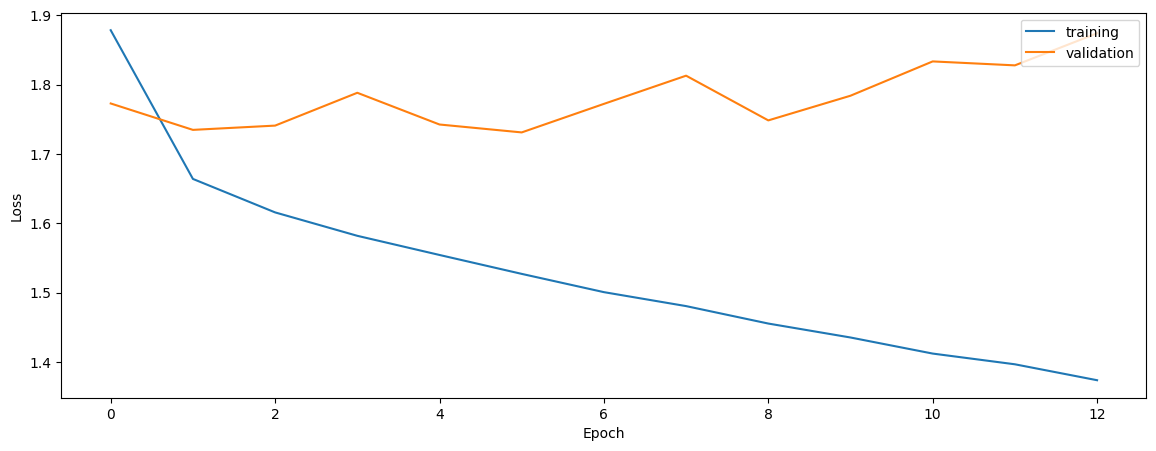

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.40822399853471497
0.33163354029266284
0.3417100866693124


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.41967846008845067
0.3965312895069532
0.34443006229269474


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.4208782716589131
0.4074069058903182
0.34991087541379273


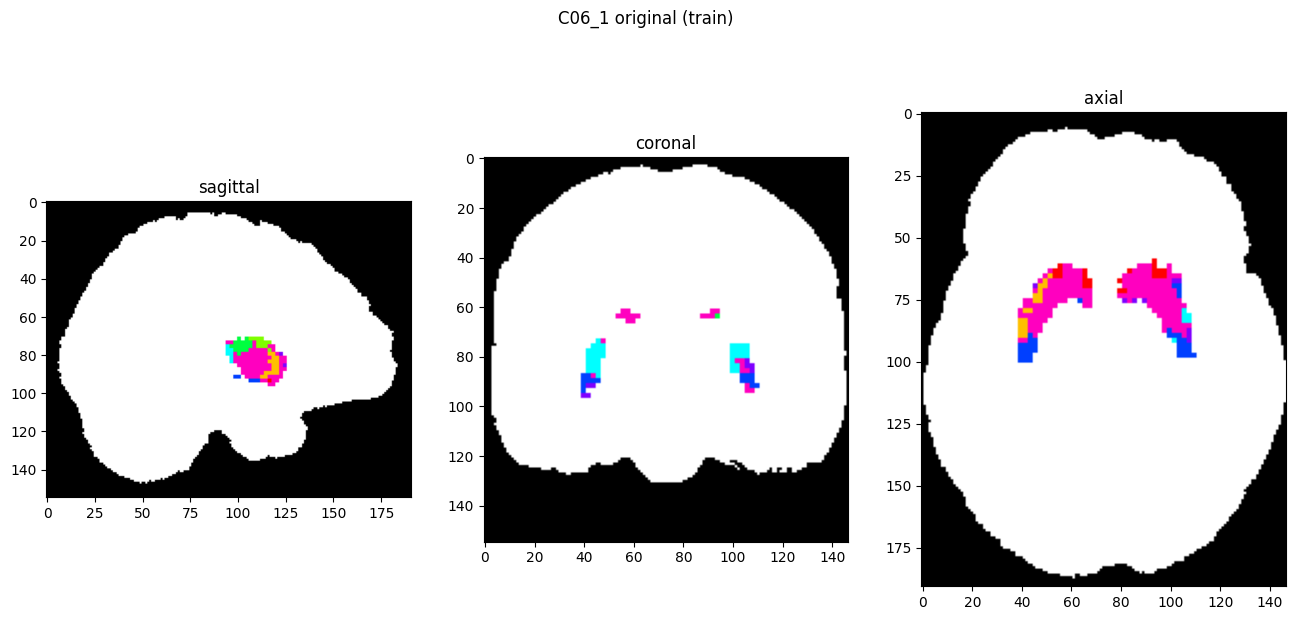

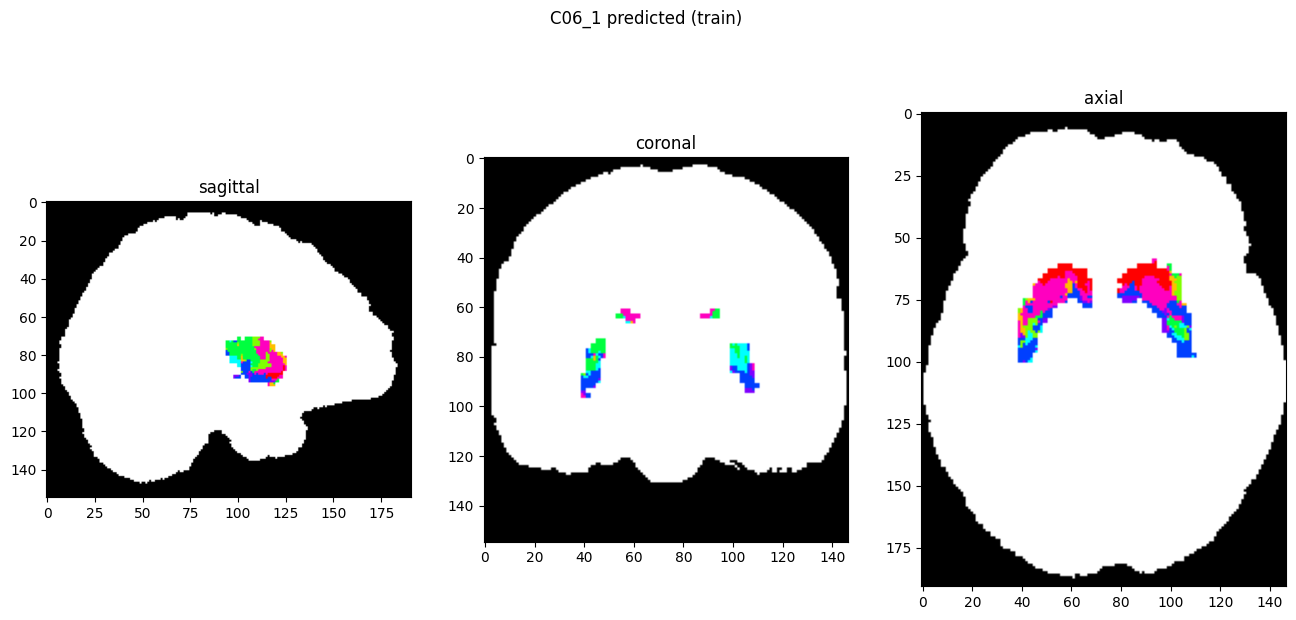

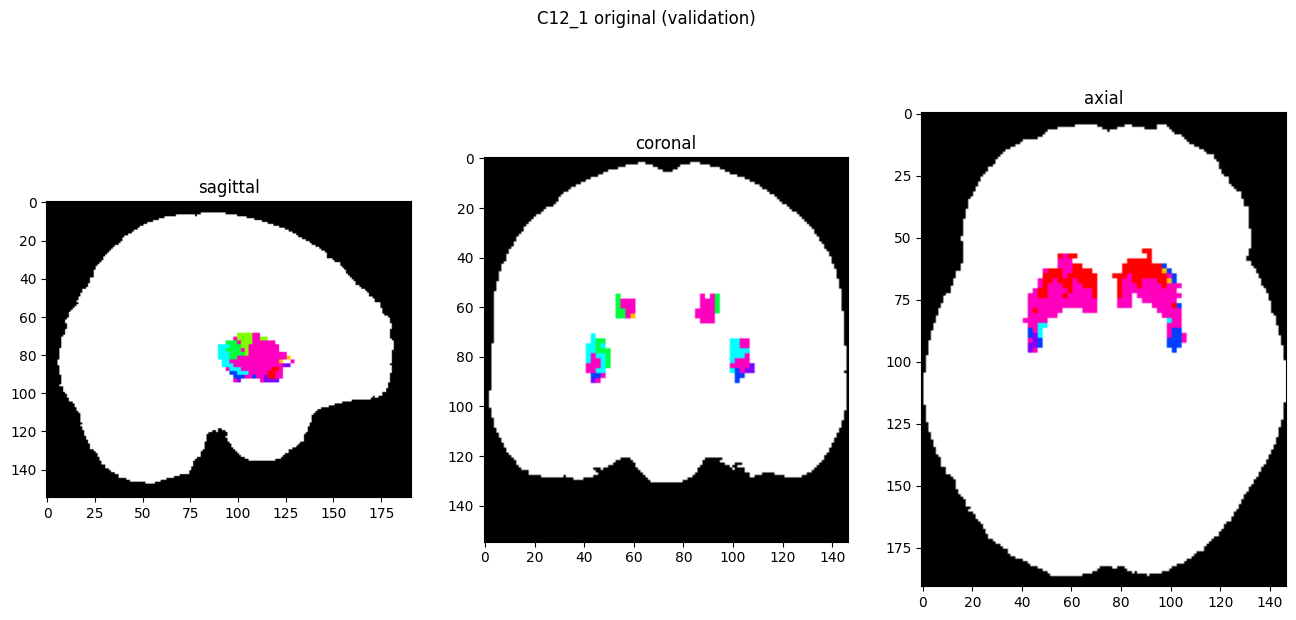

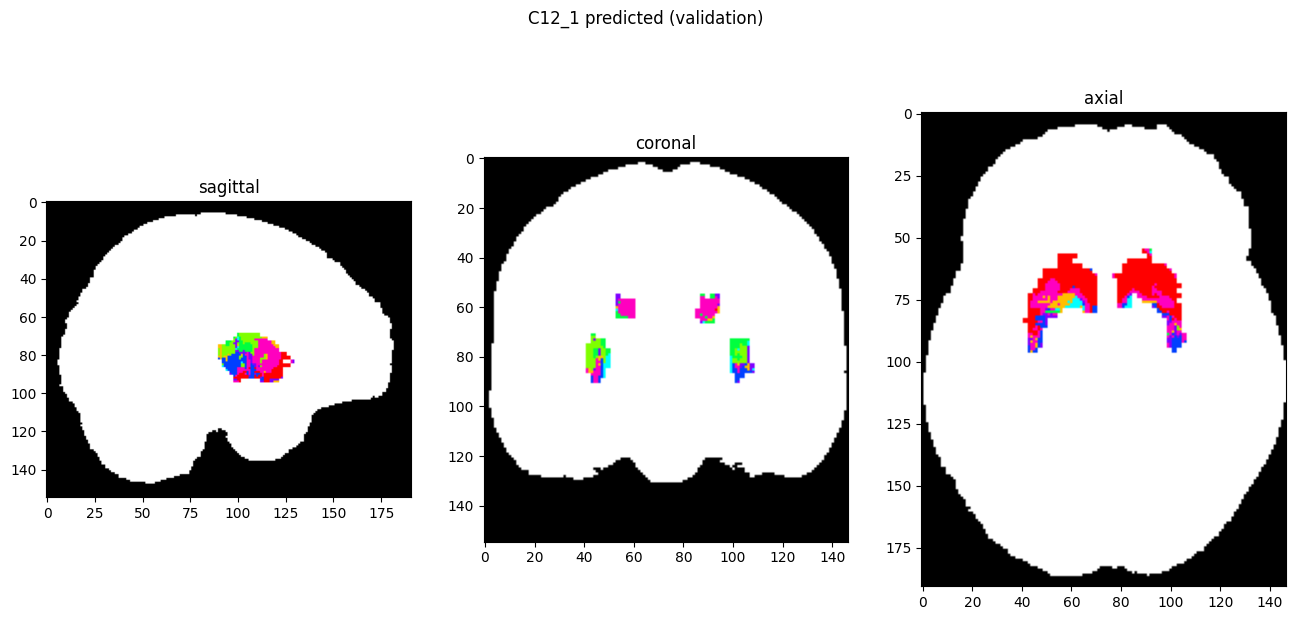

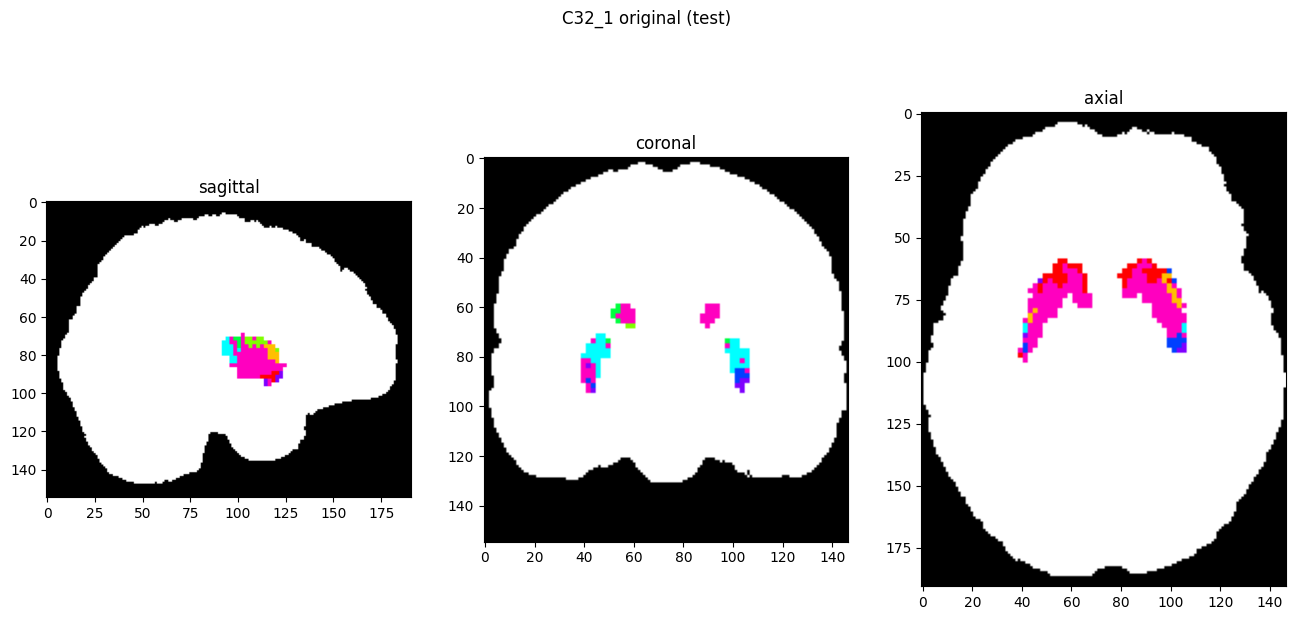

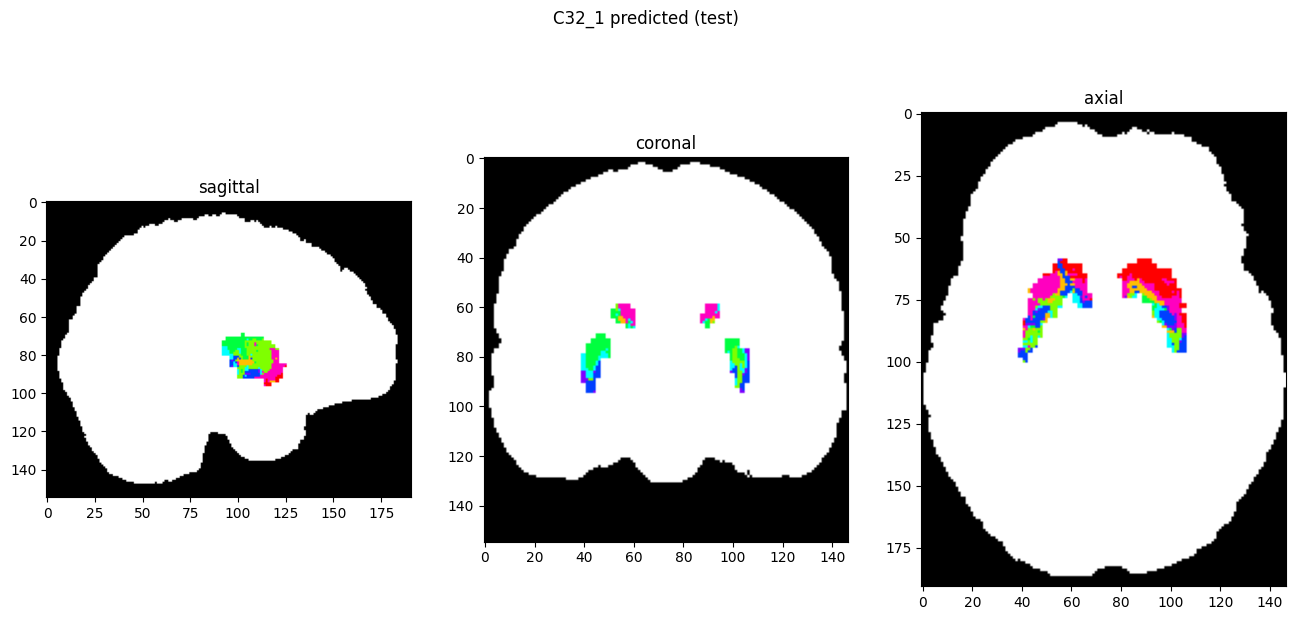

In [10]:
showResults(model, gen, threshold=0)